In [5]:
using Arpack
using LinearAlgebra
using LaTeXStrings
using Revise
using PyPlot
using MeshGrid
includet("/Users/avadali/Desktop/Desktop - Avi's Mac/Summer2024/AHC_code/Lattice_setup/lattice_BZ.jl")
includet("/Users/avadali/Desktop/Desktop - Avi's Mac/Summer2024/AHC_code/3P_funcs/patch_methods.jl")
includet("/Users/avadali/Desktop/Desktop - Avi's Mac/Summer2024/AHC_code/3P_funcs/lambda_funcs.jl")

# Helper functions

In [6]:
function approx_sign(x; tol=1e-13)
    if x > tol
        return 1
    elseif x < -tol
        return -1
    else
        return 0
    end
end

approx_sign (generic function with 1 method)

In [7]:
function grid_bc(grid, lambda, rs, kappa, V, shells, index, spacing)
    num_vertices = 4

    mBZ_count = num_mBZ(shells)
    shell_parts = sgn_parts(shells)
    partitions = sgn_parts(shells - 1)
    part_1s = sgn_parts(1)
    dict = part_dict(shells)

    ham = zeros(ComplexF64, mBZ_count, mBZ_count)
    spinors = Array{ComplexF64}(undef, num_vertices, mBZ_count, 2)
    grounds = Array{ComplexF64}(undef, num_vertices, mBZ_count)
    plaq_area = area(spacing * sqrt(2), num_vertices)

    g1 = kappa * sqrt(3) * [-sqrt(3)/2, 1/2]
    g2 = kappa * sqrt(3) * [0, 1]

    gi = zeros(2)
    gj = zeros(2)

    berry_list = Array{Float64}(undef, size(grid, 1))

    for i in 1:size(grid, 1)
        berry_list[i] = lambda_mBZ_bc!(g1, g2, num_vertices, plaq_area, shell_parts, partitions, part_1s, dict, ham, spinors, grounds, 
        grid[i, :], lambda, rs, kappa, V, shells, index, spacing)
    end
    return berry_list
end

grid_bc (generic function with 1 method)

In [8]:
function plot_bc(lambda, rs, kappa, V, shells, index, spacing)
    n_pts = 10^2

    k_list = range(-kappa, kappa, n_pts)
    grid = mesh_grid(k_list, k_list, Float64)


    bc_list = grid_bc(grid, lambda, rs, kappa, V, shells, index, spacing)

    grid_new = reshape(grid, (n_pts, n_pts, 2))
    bc_list_new = reshape(bc_list, (n_pts, n_pts))

    bc_min = minimum(bc_list_new)
    bc_max = maximum(bc_list_new)
    bc_abs = maximum(abs.([bc_min, bc_max]))

    figure()
    xlabel(L"k_x")
    ylabel(L"k_y")
    title(L"\Omega(k_x, k_y) \text{ vs } (k_x, k_y)")
    pcolormesh(grid_new[:, :, 1], grid_new[:, :, 2], bc_list_new, cmap="RdBu", vmin = -bc_abs, vmax = bc_abs)
    colorbar()
    display(gcf())
end

plot_bc (generic function with 1 method)

# Initial experiments

## Comparison against 3-patch

## Error Figs

In [216]:
function near_crit_bc_comp(bc_spacing, lambda, rs, kappa, V, shells)
    n_pts = 40

    kappa_1 = kappa * [1, 0]

    shift = 1 * range(-1, 1, n_pts)

    kx_list = kappa_1[1] * ones(n_pts) .+ shift
    ky_list = kappa_1[2] * ones(n_pts) .+ shift

    mBZ_grid = mesh_grid(kx_list, ky_list, Float64)
    patch_grid = mesh_grid(shift, shift, Float64)

    # patch_grid = make_circle(kappa, 10^(-1.5))

    # temp_kap = ones(size(patch_grid))
    # temp_kap[:, 1] .= kappa
    # temp_kap[:, 2] .= 0
    # mBZ_grid = temp_kap .+ patch_grid

    mBZ_bc = grid_bc(mBZ_grid, lambda, rs, kappa, V, shells, 1, bc_spacing) / pi
    
    mBZ_grid_new = reshape(mBZ_grid, (n_pts, n_pts, 2))
    mBZ_bc_new = reshape(mBZ_bc, (n_pts, n_pts))

    mBZ_min = minimum(mBZ_bc_new)
    mBZ_max = maximum(mBZ_bc_new)
    mBZ_abs = maximum(abs.([mBZ_min, mBZ_max]))
    # mBZ_min = minimum(mBZ_bc)
    # mBZ_max = maximum(mBZ_bc)
    # mBZ_abs = maximum(abs.([mBZ_min, mBZ_max]))
    
    v1 = V[1, 1]
    v2 = V[2, 2]

    delta = 1/2 * lambda_delta(kappa, lambda, v1, v2)
    alpha = 1/2 * lambda_alpha(kappa, lambda, v1, v2)

    vF = 2 * kappa / rs^2

    patch_bc = bc_no_spinors(patch_grid, bc_spacing, vF, delta, alpha, 1) / pi

    # patch_bc = lambda_patch_bc(patch_grid, bc_spacing, lambda, kappa, vF, delta, alpha, 1) / pi

    patch_grid_new = reshape(patch_grid, (n_pts, n_pts, 2))
    patch_bc_new = reshape(patch_bc, (n_pts, n_pts))

    patch_min = minimum(patch_bc_new)
    patch_max = maximum(patch_bc_new)
    patch_abs = maximum(abs.([patch_min, patch_max]))
    # patch_min = minimum(patch_bc)
    # patch_max = maximum(patch_bc)
    # patch_abs = maximum(abs.([patch_min, patch_max]))

    error = log10.(abs.(1 .- patch_bc_new ./ mBZ_bc_new))
    # error = log10.(abs.(patch_bc_new - mBZ_bc_new))
    err_min = minimum(error)
    err_max = maximum(error)
    err_abs = maximum(abs.([err_min, err_max]))

    # error = log10.(abs.(1 .- patch_bc ./ mBZ_bc))
    # err_min = minimum(error)
    # err_max = maximum(error)
    # err_abs = maximum(abs.([err_min, err_max]))

#     fig, ((ax1, ax2)) = plt.subplots(1,2,figsize=(15, 6))  

#     mBZ_mesh = ax1.pcolormesh(mBZ_grid_new[:, :, 1], mBZ_grid_new[:, :, 2], mBZ_bc_new, cmap="RdBu", vmin = -mBZ_abs, vmax = mBZ_abs)
#     ax1.set_xlabel(L"$k_x$")
#     ax1.set_ylabel(L"$k_y$")
#     ax1.set_title(L"$\Omega^\text{mBZ}(k_x, k_y)$")
#     fig.colorbar(mBZ_mesh, ax=ax1)

#     patch_mesh = ax2.pcolormesh(patch_grid_new[:, :, 1], patch_grid_new[:, :, 2], abs.(1 .- patch_bc_new ./ mBZ_bc_new), cmap="RdBu")
#     ax2.set_xlabel(L"$k_x$")
#     ax2.set_ylabel(L"$k_y$")
#     ax2.set_title(L"$\Omega^\text{3p}(k_x, k_y)$")
#     fig.colorbar(patch_mesh, ax=ax2)

    hex1 = hex_outline([-1, 0], kappa, 10^(-2))
    hex2 = hex_outline([-1, 0] + [3*kappa/2, kappa*sqrt(3)/2], kappa, 10^(-2))
    hex3 = hex_outline([-1, 0] + [3*kappa/2, -kappa*sqrt(3)/2], kappa, 10^(-2))

    trunc_hex1 = zeros(size(hex1))
    trunc_hex2 = zeros(size(hex2))
    trunc_hex3 = zeros(size(hex3))
    for j in 1:length(hex1[:, 1])
        if shift[1] <= hex1[j, 1] &&  hex1[j, 1] <= shift[n_pts]
            if shift[1] <= hex1[j, 2] && hex1[j, 2] <= shift[n_pts]
                trunc_hex1[j, : ] = hex1[j, :]
            end
        end
        if shift[1] <= hex2[j, 1] && hex2[j, 1] <= shift[n_pts]
            if shift[1] <= hex2[j, 2] && hex2[j, 2] <= shift[n_pts]
                trunc_hex2[j, : ] = hex2[j, :]
            end
        end
        if shift[1] <= hex3[j, 1] && hex3[j, 1] <= shift[n_pts]
            if shift[1] <= hex3[j, 2] && hex3[j, 2] <= shift[n_pts]
                trunc_hex3[j, : ] = hex3[j, :]
            end
        end
    end
    trunc_hex1 = reshape(trunc_hex1, (:, 2))
    trunc_hex2 = reshape(trunc_hex2, (:, 2))
    trunc_hex3 = reshape(trunc_hex3, (:, 2))
   
# fig
    fig, axs = plt.subplots(1,2,figsize=(10, 6))

    # axs.set_xlabel(L"q_x", fontsize = 16)
    # axs.set_ylabel(L"q_y", fontsize = 16, rotation=0, labelpad=10)

    # xticks = [-1, -0.5, 0, 0.5, 1]
    # xlabels = [L"-\kappa", L"-\kappa/2", L"0", L"\kappa/2", L"\kappa"]
    # axs.set_xticks(xticks, labels=xlabels)
    # yticks = [-1, -0.5, 0, 0.5, 1]
    # ylabels = [L"-\kappa", L"-\kappa/2", L"0", L"\kappa/2", L"\kappa"]
    # axs.set_yticks(yticks, labels=ylabels)

    # axs.yaxis.set_label_coords(-0.15, 0.47)

    berry = axs[1].pcolormesh(patch_grid_new[:, :, 1], patch_grid_new[:, :, 2], patch_bc_new, cmap="RdBu")
    cbar = fig.colorbar(berry, orientation="horizontal", location="top")

    berry = axs[2].pcolormesh(patch_grid_new[:, :, 1], patch_grid_new[:, :, 2], mBZ_bc_new, cmap="RdBu")
    cbar = fig.colorbar(berry, orientation="horizontal", location="top")

    # cbar.set_ticks([-6, -4, -2, 0, 2, 4, 6])
    # cbar.set_ticklabels([L"10^{-6}", L"10^{-4}", L"10^{-2}", L"1", L"10^{2}",  L"10^4", L"10^6"])

    # axs.scatter(trunc_hex1[:, 1], trunc_hex1[:, 2], s = ones(length(trunc_hex1[:, 1])), alpha=0.4, c="k")
    # axs.scatter(trunc_hex2[:, 1], trunc_hex2[:, 2], s = ones(length(trunc_hex2[:, 1])), alpha=0.4, c="k")
    # axs.scatter(trunc_hex3[:, 1], trunc_hex3[:, 2], s = ones(length(trunc_hex3[:, 1])), alpha=0.4, c="k")
    # axs.scatter(hex1[:, 1], hex1[:, 2], s = ones(length(hex1[:, 1])), alpha=0.4, c="k")
    # axs.scatter(hex2[:, 1], hex2[:, 2], s = ones(length(hex2[:, 1])), alpha=0.4, c="k")
    # axs.scatter(hex3[:, 1], hex3[:, 2], s = ones(length(hex3[:, 1])), alpha=0.4, c="k")
    
    # cbar.set_ticks([-0.4, -0.2, 0, 0.2, 0.4])
    # cbar.set_ticklabels([L"-2 \pi / 5", L"-\pi / 5", L"0", L"\pi / 5", L"2 \pi / 5"])
    # cbar.set_ticks([-6, -3, 0, 3, 6])
    # cbar.set_ticklabels([L"10^{-6}", L"10^{-3}", L"1", L"10^3", L"10^6"])
    fig.tight_layout()
    fig

end

near_crit_bc_comp (generic function with 1 method)

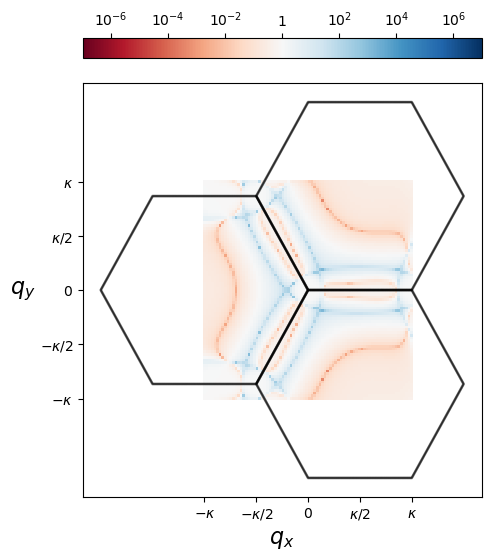

In [183]:
bc_spacing = 10^(-6)
lambda = 0.9
rs = sqrt(2/10^(0))
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
near_crit_bc_comp(bc_spacing, lambda, rs, kappa, V, shells)

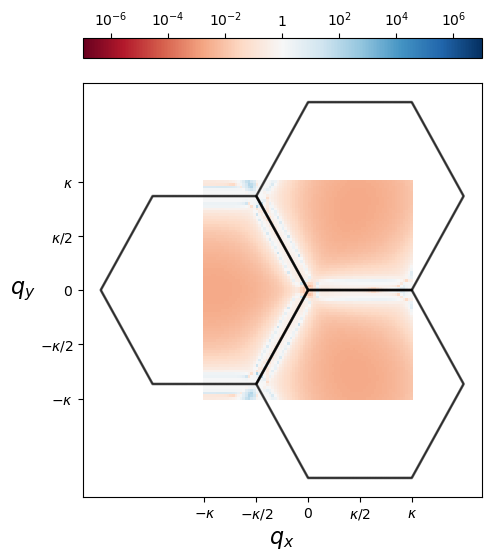

In [184]:
bc_spacing = 10^(-6)
lambda = 0.9
rs = sqrt(2/10^(1))
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
near_crit_bc_comp(bc_spacing, lambda, rs, kappa, V, shells)

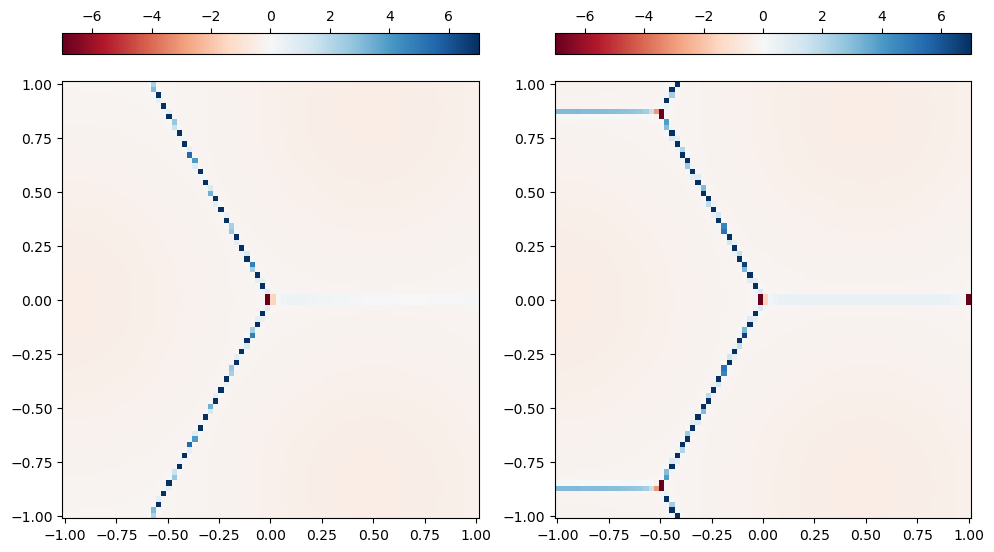

In [200]:
bc_spacing = 10^(-6)
lambda = 0.9
rs = sqrt(2/10^(2))
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
near_crit_bc_comp(bc_spacing, lambda, rs, kappa, V, shells)

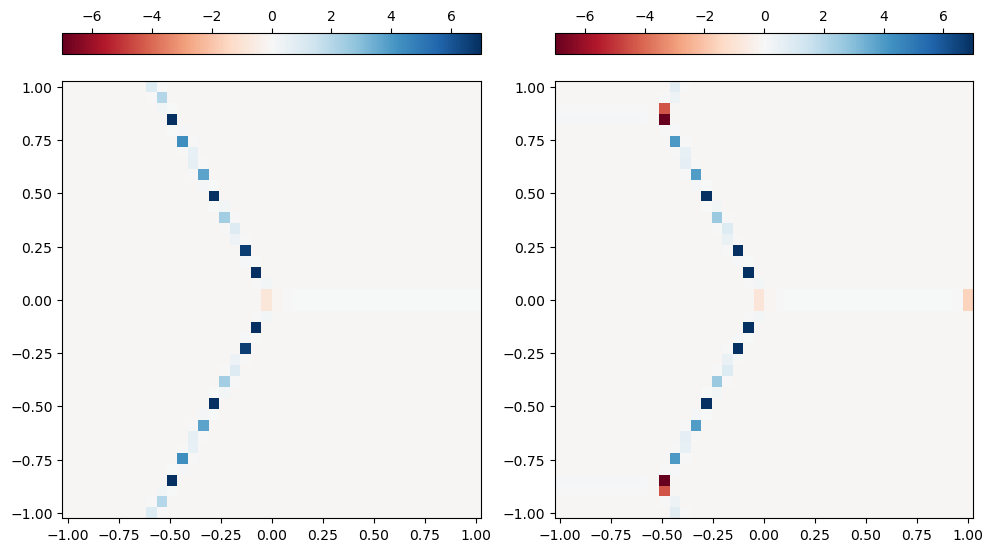

In [203]:
bc_spacing = 10^(-6)
lambda = 0.4
rs = sqrt(2/10^(2))
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
near_crit_bc_comp(bc_spacing, lambda, rs, kappa, V, shells)

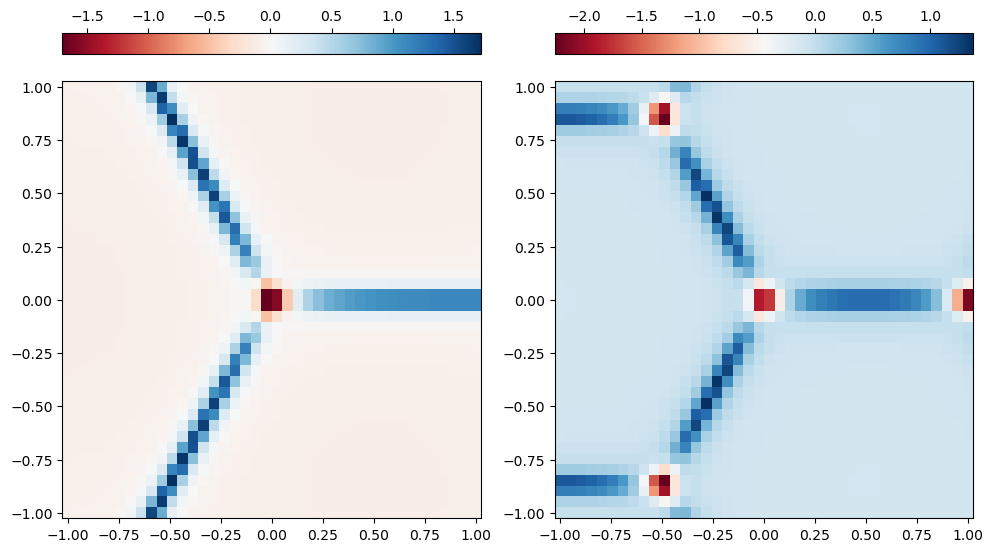

In [209]:
bc_spacing = 10^(-6)
lambda = 0.4
rs = sqrt(2/10^(1))
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
near_crit_bc_comp(bc_spacing, lambda, rs, kappa, V, shells)

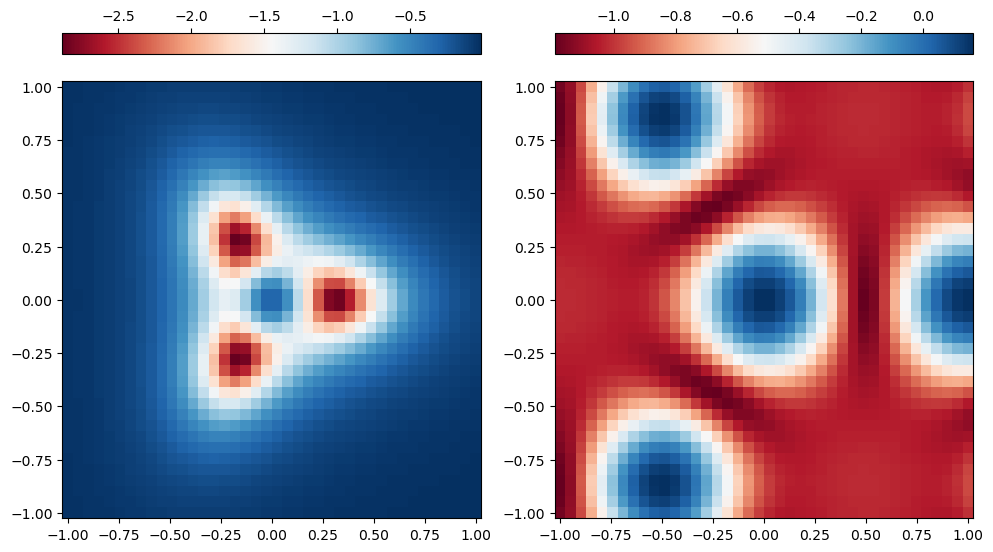

In [226]:
bc_spacing = 10^(-6)
lambda = 1.1
rs = sqrt(2/10^(0))
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
near_crit_bc_comp(bc_spacing, lambda, rs, kappa, V, shells)

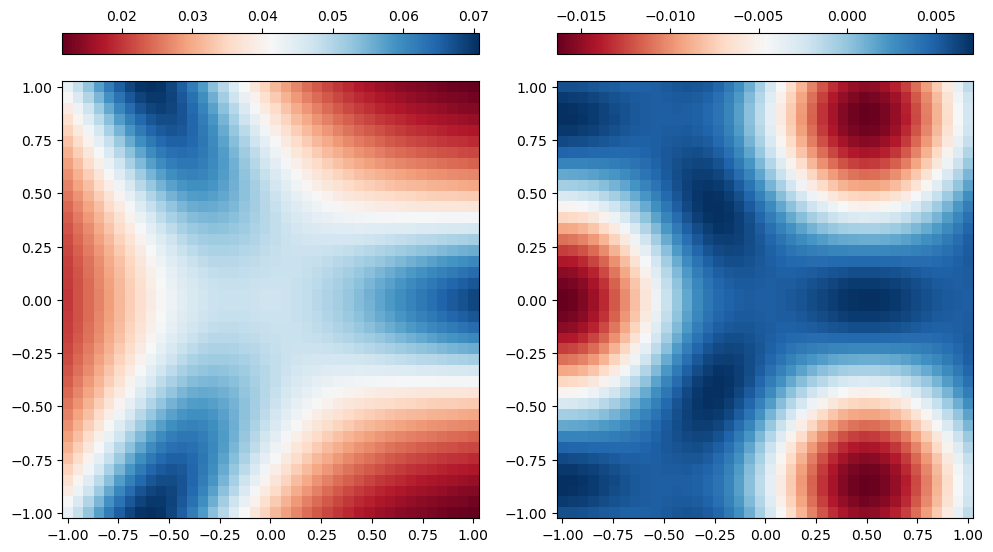

In [217]:
bc_spacing = 10^(-6)
lambda = 0.4
rs = sqrt(2/10^(0))
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
near_crit_bc_comp(bc_spacing, lambda, rs, kappa, V, shells)

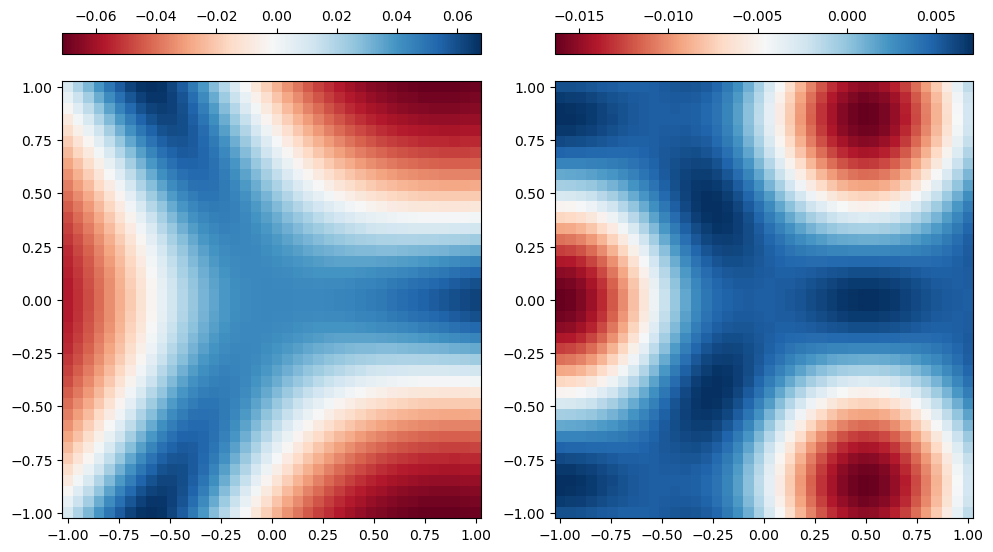

In [208]:
bc_spacing = 10^(-6)
lambda = 0.4
rs = sqrt(2/10^(0))
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
near_crit_bc_comp(bc_spacing, lambda, rs, kappa, V, shells)

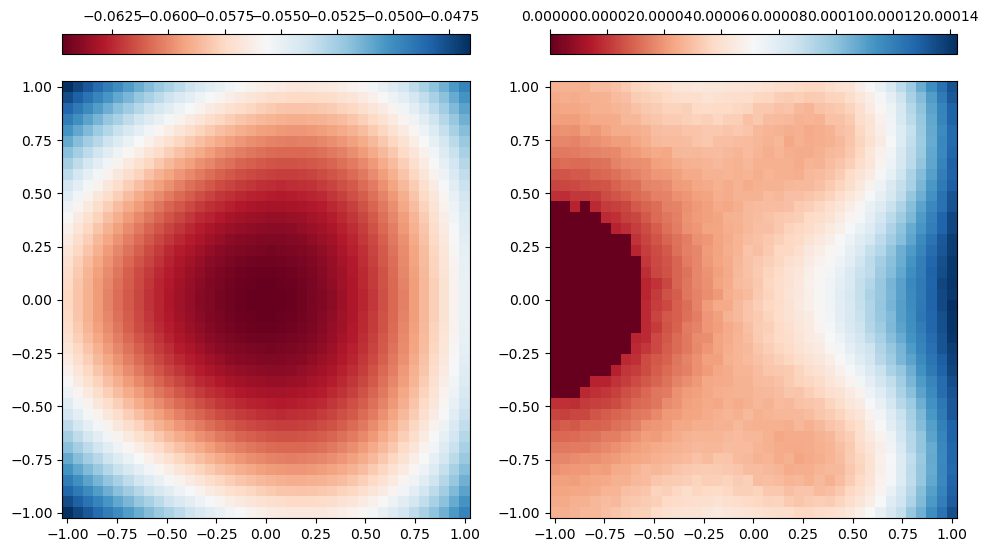

In [210]:
bc_spacing = 10^(-6)
lambda = 0.4
rs = sqrt(2/10^(-1))
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
near_crit_bc_comp(bc_spacing, lambda, rs, kappa, V, shells)

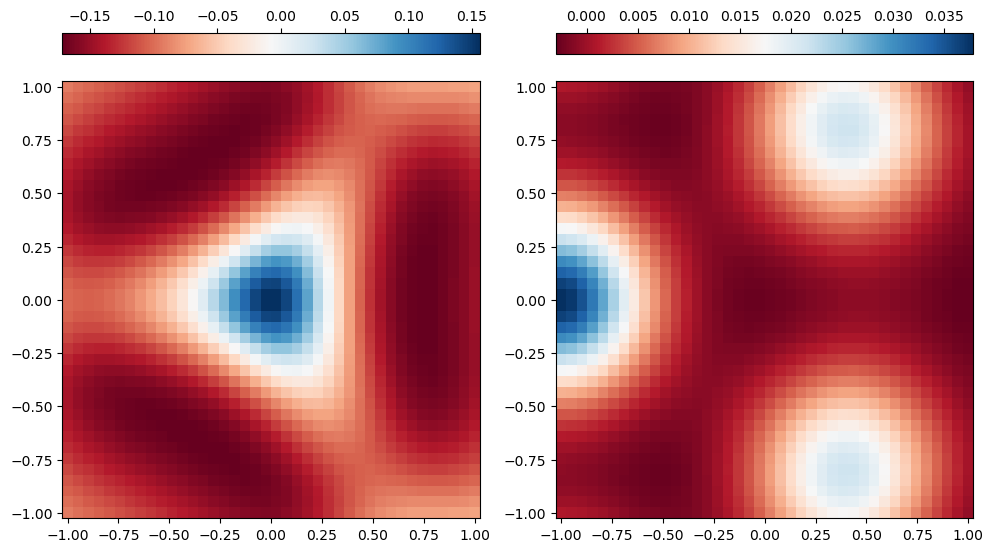

In [214]:
bc_spacing = 10^(-6)
lambda = 1.4
rs = sqrt(2/10^(-3))
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
near_crit_bc_comp(bc_spacing, lambda, rs, kappa, V, shells)

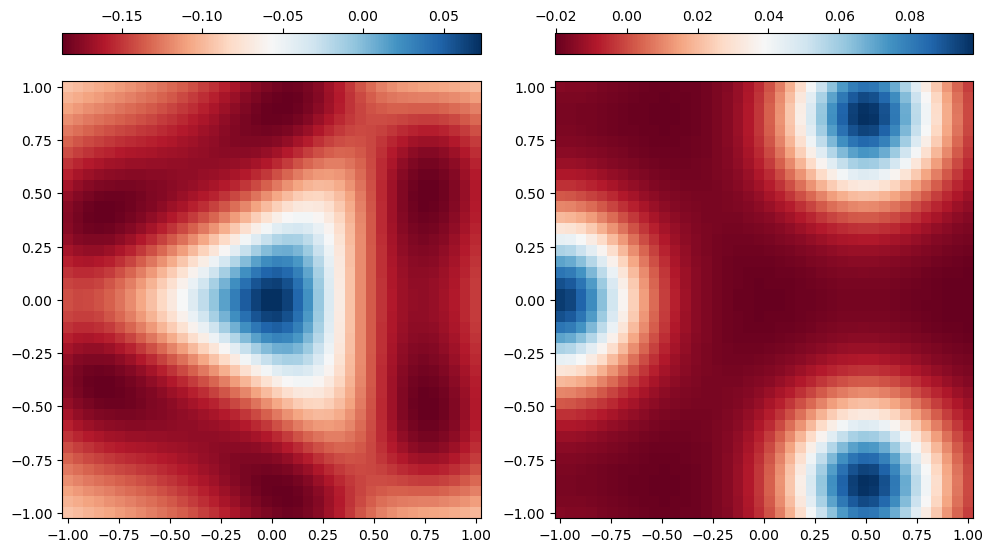

In [211]:
bc_spacing = 10^(-6)
lambda = 1.4
rs = sqrt(2/10^(-1))
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
near_crit_bc_comp(bc_spacing, lambda, rs, kappa, V, shells)

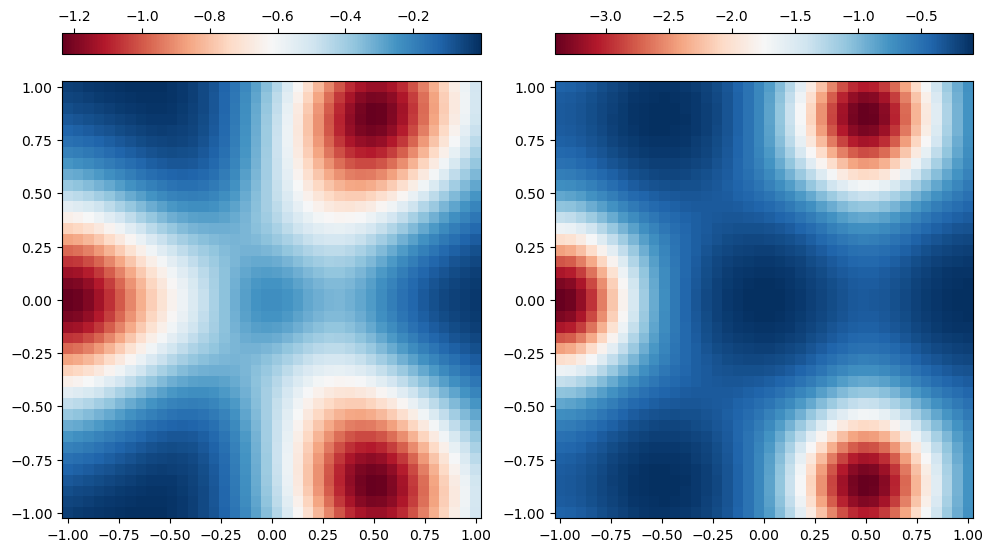

In [212]:
bc_spacing = 10^(-6)
lambda = 1.4
rs = sqrt(2/10^(0))
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
near_crit_bc_comp(bc_spacing, lambda, rs, kappa, V, shells)

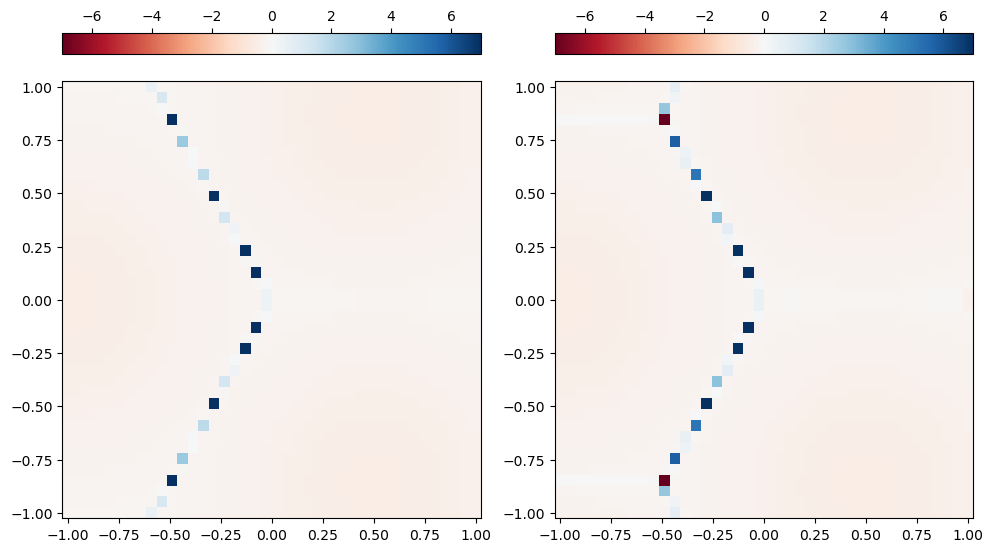

In [202]:
bc_spacing = 10^(-6)
lambda = 0.9
rs = sqrt(2/10^(2))
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 7
near_crit_bc_comp(bc_spacing, lambda, rs, kappa, V, shells)

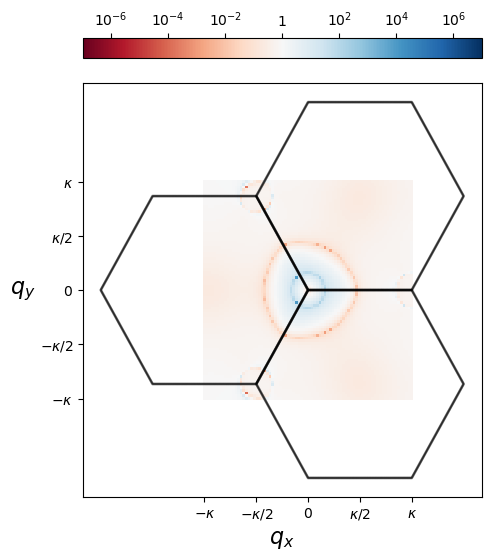

In [186]:
bc_spacing = 10^(-6)
lambda = 1.1
rs = sqrt(2/10^(0))
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
near_crit_bc_comp(bc_spacing, lambda, rs, kappa, V, shells)

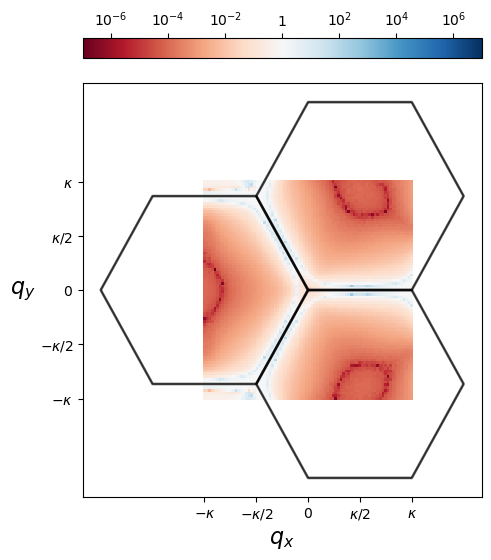

In [187]:
bc_spacing = 10^(-6)
lambda = 1.1
rs = sqrt(2/10^(1))
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
near_crit_bc_comp(bc_spacing, lambda, rs, kappa, V, shells)

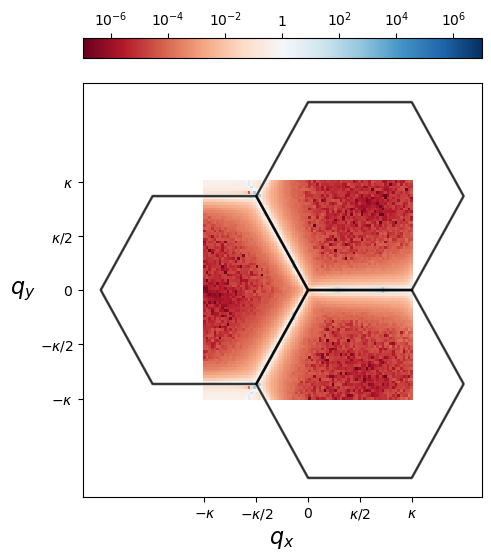

In [188]:
bc_spacing = 10^(-6)
lambda = 1.1
rs = sqrt(2/10^(2))
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
near_crit_bc_comp(bc_spacing, lambda, rs, kappa, V, shells)

In [339]:
function angular_bc_plots(bc_spacing, lambda, rs, kappa, V, shells, k_mag)
    n_pts = 10^3
    angs = range(-pi, pi, n_pts)
    berry_list = Array{Float64}(undef, n_pts, 2)

    kappa_1 = kappa * [1, 0]
    
    for j in 1:n_pts
        mom = k_mag * [cos(angs[j]), sin(angs[j])]
        mBZ_mom = kappa_1 .+ mom

        berry_list[j, 1] = grid_bc(reshape(mBZ_mom, (1, 2)), lambda, rs, kappa, V, shells, 1, bc_spacing)[1]

        v1 = V[1, 1]
        v2 = V[2, 2]
        delta = 1/2 * lambda_delta(kappa, lambda, v1, v2)
        alpha = 1/2 * lambda_alpha(kappa, lambda, v1, v2)
        vF = 2 * kappa / rs^2
        berry_list[j, 2] = lambda_patch_bc(reshape(mom, (1, 2)), bc_spacing, lambda, kappa, vF, delta, alpha, 1)[1]
    end

    fig, axs = plt.subplots(1,1,figsize=(8, 6))


    axs.plot(angs/pi, berry_list[:, 1]/pi, label=L"\text{full mBZ}")
    axs.plot(angs/pi, berry_list[:, 2]/pi, label=L"\text{3-patch}")

    axs.set_xlabel(L"$\varphi$")
    axs.set_ylabel(L"$\Omega$")
    # axs.set_title(L"$\Omega \text{ vs } \arg(q)$")
    axs.legend()

    xticks = [-2/3, 0, 2/3]
    xlabels = [L"-2 \pi /3", L"0", L"2 \pi / 3"]
    axs.set_xticks(xticks, labels=xlabels)

    # yticks = [0, 0.01, 0.02, 0.03, 0.04, 0.05]
    # ylabels = [L"0", L"0.01 \pi", L"0.02 \pi", L"0.03 \pi", L"0.04 \pi", L"0.05 \pi"]
    # axs.set_yticks(yticks, labels=ylabels)

    # yticks = [0, 0.1, 0.2, 0.3, 0.4, 0.5]
    # ylabels = [L"0", L"0.1 \pi ", L"0.2 \pi ", L"0.3 \pi", L"0.4 \pi", L"0.5 \pi"]
    # axs.set_yticks(yticks, labels=ylabels)

    # yticks = [0, 4, 8, 12, 16]
    # ylabels = [L"0", L"4 \pi", L"8 \pi", L"12 \pi", L"16 \pi"]
    # axs.set_yticks(yticks, labels=ylabels)



    # yticks = [-0.3, -0.25, -0.2, -0.15, -0.1]
    # ylabels = [L"-0.3 \pi", L"-0.25 \pi", L"-0.2 \pi", L"-0.15 \pi", L"-0.1 \pi"]
    # axs.set_yticks(yticks, labels=ylabels)

    # yticks = [-0.2, 0.2, 0.6, 1, 1.4]
    # ylabels = [L"-0.2 \pi", L"0.2 \pi", L"0.6 \pi", L"\pi", L"1.4 \pi"]
    # axs.set_yticks(yticks, labels=ylabels)

    yticks = [-20, -15, -10, -5, 0]
    ylabels = [L"-20 \pi", L"-15 \pi", L"-10 \pi", L"-5 \pi", L"0"]
    axs.set_yticks(yticks, labels=ylabels)

    fig.tight_layout()

    fig
end

angular_bc_plots (generic function with 1 method)

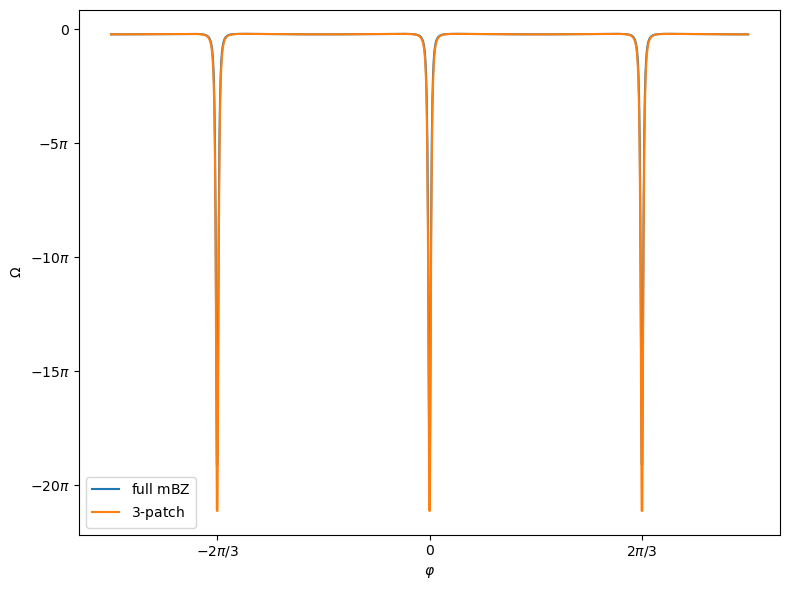

In [340]:
bc_spacing = 10^(-6)
lambda = 1.4
rs = sqrt(2/10^(2))
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
k_mag = 0.15 * kappa

angular_bc_plots(bc_spacing, lambda, rs, kappa, V, shells, k_mag)

## More stuff

In [230]:
bc_spacing = 10^(-4)
lambda = 1
rs = 1
kappa = 1
V = 0.1 * [[-1, 0] [0, -1.1]]
shells = 5

q = 0.1 * [1, 1]

display(grid_bc(reshape(kappa * [1, 0] .+ q, (1, 2)), lambda, rs, kappa, V, shells, 1, bc_spacing))

v1 = V[1, 1]
v2 = V[2, 2]
delta = 1/2 * lambda_delta(kappa, lambda, v1, v2)
alpha = 1/2 * lambda_alpha(kappa, lambda, v1, v2)
vF = 2 * kappa / rs^2

display(lambda_patch_bc(reshape([0, 0] .+ q, (1, 2)), bc_spacing, lambda, kappa, vF, delta, alpha))

1-element Vector{Float64}:
 -0.5641456624875716

1-element Vector{Float64}:
 -0.5816649309921046

In [199]:
bc_spacing = 10^(-4)
lambda = 1
rs = 1
kappa = 1
V = [[-1, 0] [0, -1.01]]
shells = 5
display(grid_bc(reshape(kappa * [1, 0], (1, 2)), lambda, rs, kappa, V, shells, 1, bc_spacing))

1-element Vector{Float64}:
 106.60875257675318

In [213]:
bc_spacing = 10^(-4)
lambda = 1
rs = 1
kappa = 1
V = 0.1 * [[-1, 0] [0, -1.1]]
shells = 5
display(grid_bc(reshape(kappa * [1, 0], (1, 2)), lambda, rs, kappa, V, shells, 1, bc_spacing))

1-element Vector{Float64}:
 25415.842468131847

## Near-critical correspondance

I want to see how close 3-patch and total mBZ Berry curvatures are near criticality. Particularly, I want to check at finite momentum. I want to check with and without $\alpha$ and ensure that $\alpha$ actually captures some of the correct behavior.

In [7]:
function q_agreement(bc_spacing, lambda, rs, kappa, V, shells, k_angle)
    q_list = range(0, 0.1*kappa, 10^2)
    kappa_1 = kappa * [1, 0]
    mBZ_bc = Array{Float64}(undef, length(q_list))
    patch_bc = Array{Float64}(undef, length(q_list), 2)
    rel_error = Array{Float64}(undef, length(q_list), 2)

    for j in 1:length(q_list)
        mom = q_list[j] .* [cos(k_angle), sin(k_angle)]
        mBZ_mom = mom .+ kappa_1
        mBZ_bc[j] = grid_bc(reshape(mBZ_mom, (1, 2)), lambda, rs, kappa, V, shells, 1, bc_spacing)[1]

        v1 = V[1, 1]
        v2 = V[2, 2]
        delta = 1/2 * lambda_delta(kappa, lambda, v1, v2)
        alpha = 1/2 * lambda_alpha(kappa, lambda, v1, v2)
        vF = 2 * kappa / rs^2
        patch_bc[j, 1] = lambda_patch_bc(reshape(mom, (1, 2)), bc_spacing, lambda, kappa, vF, delta, alpha)[1]

        patch_bc[j, 2] = lambda_patch_bc(reshape(mom, (1, 2)), bc_spacing, lambda, kappa, vF, delta, 0)[1]

        rel_error[j, 1] = abs(1 - (patch_bc[j, 1]/mBZ_bc[j]))
        rel_error[j, 2] = abs(1 - (patch_bc[j, 2]/mBZ_bc[j]))
    end
    fig, axs = plt.subplots(1,2,figsize=(15, 6))

    axs[1].plot(q_list, mBZ_bc, label=L"\text{mBZ}")
    axs[1].plot(q_list, patch_bc[:, 1], label=L"\text{3p}")

    axs[1].set_xlabel(L"$k$")
    axs[1].set_ylabel(L"$\Omega$")
    axs[1].set_title(L"$\Omega \text{ vs } k$")
    axs[1].legend()

    axs[2].plot(q_list, rel_error[:, 1], label=L"$\alpha \neq 0$")
    axs[2].plot(q_list, rel_error[:, 2], label=L"$\alpha = 0$")

    axs[2].set_xlabel(L"$k$")
    axs[2].set_ylabel(L"$\delta \Omega$")
    axs[2].set_title(L"$\delta \Omega \text{ vs } k$")
    axs[2].set_yscale("log")
    axs[2].legend()

    fig.tight_layout()

    fig
end

q_agreement (generic function with 1 method)

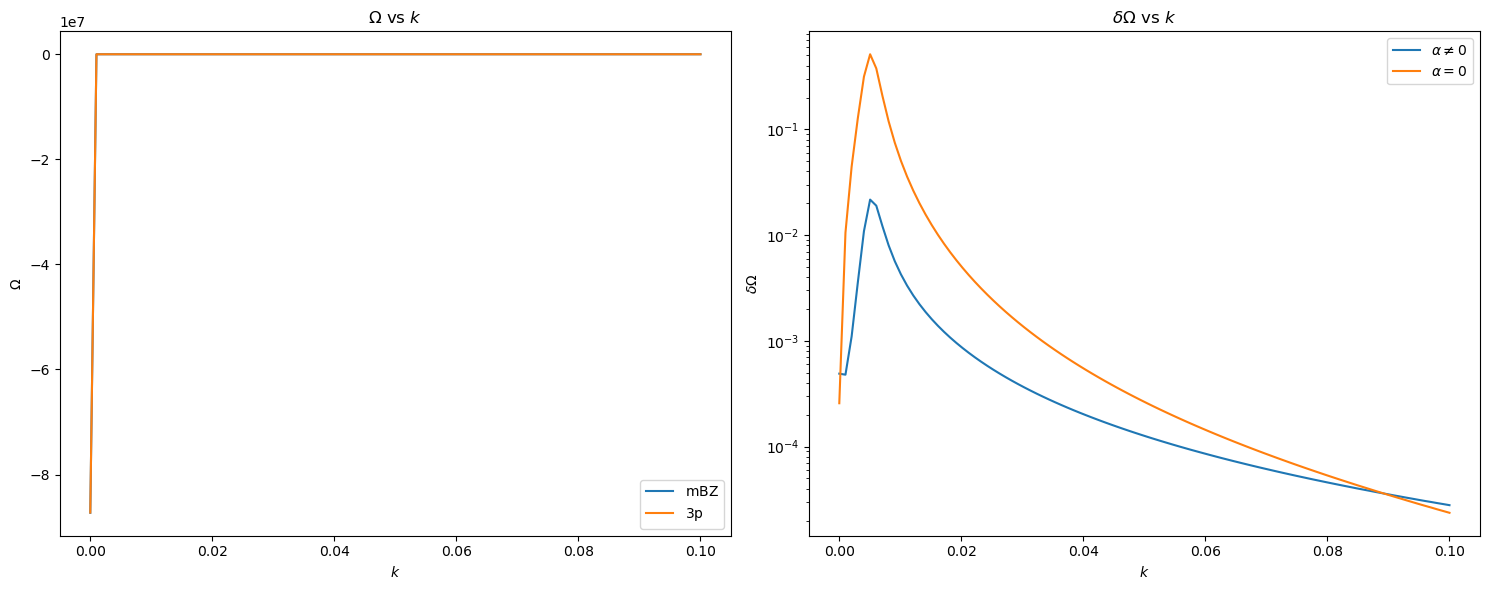

In [327]:
bc_spacing = 10^(-4)
lambda = 1
rs = 1
kappa = 1
V = 0.001 * [[-1, 0] [0, -0.9]]
shells = 5
k_angle = pi/7
q_agreement(bc_spacing, lambda, rs, kappa, V, shells, k_angle)

In [8]:
function ang_agreement(bc_spacing, lambda, rs, kappa, V, shells, q)
    ang_list = range(-pi, pi, 10^2)
    kappa_1 = kappa * [1, 0]
    mBZ_bc = Array{Float64}(undef, length(ang_list))
    patch_bc = Array{Float64}(undef, length(ang_list), 2)
    rel_error = Array{Float64}(undef, length(ang_list), 2)

    for j in 1:length(ang_list)
        mom = q .* [cos(ang_list[j]), sin(ang_list[j])]
        mBZ_mom = mom .+ kappa_1
        mBZ_bc[j] = grid_bc(reshape(mBZ_mom, (1, 2)), lambda, rs, kappa, V, shells, 1, bc_spacing)[1]

        v1 = V[1, 1]
        v2 = V[2, 2]
        delta = 1/2 * lambda_delta(kappa, lambda, v1, v2)
        alpha = 1/2 * lambda_alpha(kappa, lambda, v1, v2)
        vF = 2 * kappa / rs^2
        patch_bc[j, 1] = lambda_patch_bc(reshape(mom, (1, 2)), bc_spacing, lambda, kappa, vF, delta, alpha)[1]

        patch_bc[j, 2] = lambda_patch_bc(reshape(mom, (1, 2)), bc_spacing, lambda, kappa, vF, delta, 0)[1]

        rel_error[j, 1] = abs(1 - (patch_bc[j, 1]/mBZ_bc[j]))
        rel_error[j, 2] = abs(1 - (patch_bc[j, 2]/mBZ_bc[j]))
    end
    fig, axs = plt.subplots(1,2,figsize=(15, 6))

    axs[1].plot(ang_list, mBZ_bc, label=L"\text{mBZ}")
    axs[1].plot(ang_list, patch_bc[:, 1], label=L"\text{3p}")

    axs[1].set_xlabel(L"$\arg(k)$")
    axs[1].set_ylabel(L"$\Omega$")
    axs[1].set_title(L"$\Omega \text{ vs } \arg(k)$")
    axs[1].legend()

    axs[2].plot(ang_list, rel_error[:, 1], label=L"$\alpha \neq 0$")
    axs[2].plot(ang_list, rel_error[:, 2], label=L"$\alpha = 0$")

    axs[2].set_xlabel(L"$\arg(k)$")
    axs[2].set_ylabel(L"$\delta \Omega$")
    axs[2].set_title(L"$\delta \Omega \text{ vs } \arg(k)$")
    axs[2].set_yscale("log")
    axs[2].legend()

    fig.tight_layout()

    fig
end

ang_agreement (generic function with 1 method)

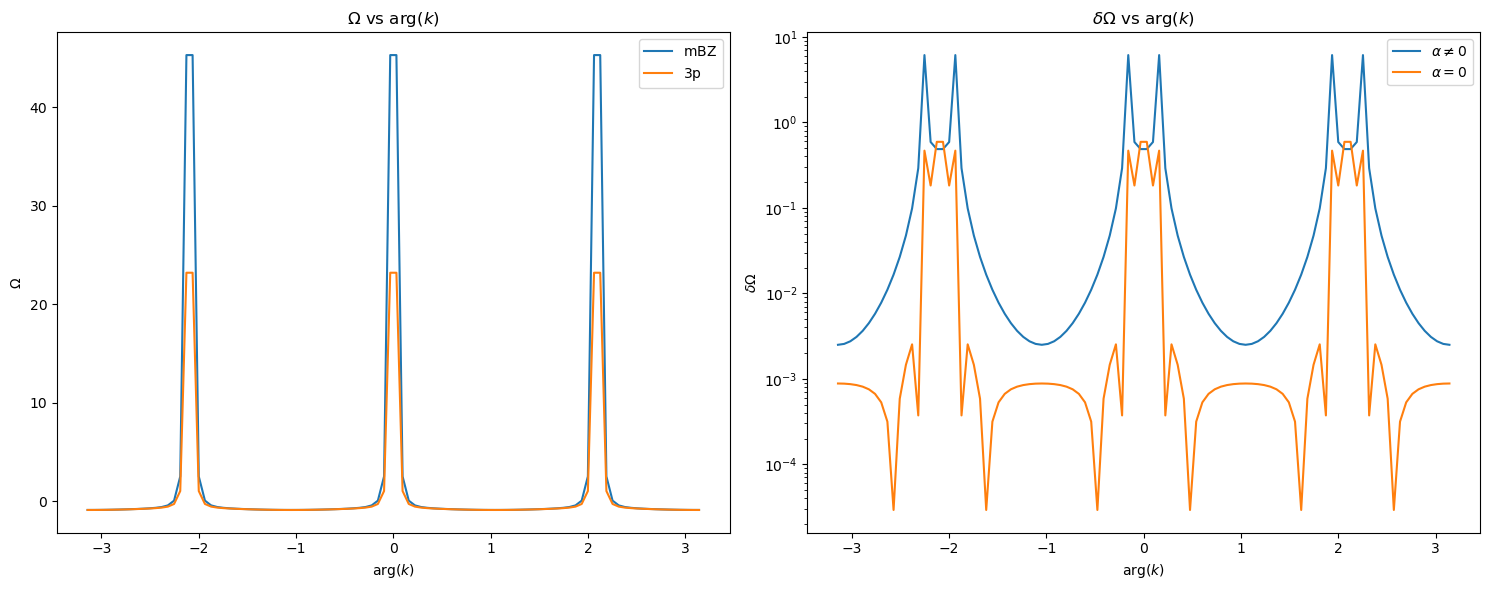

In [326]:
bc_spacing = 10^(-4)
lambda = 1
rs = 1
kappa = 1
V = 0.1 * [[-1, 0] [0, -0.9]]
shells = 5
q = 0.3 * kappa
ang_agreement(bc_spacing, lambda, rs, kappa, V, shells, q)

## Sign Charts

In [9]:
# Berry curvature sign plot
function lambda_mBZ_sgn_plot(bc_spacing, rs, kappa, shells, k, v1_sgn, v2_sgn)
    n_pts = 50

    lambda_list = range(10^(-3), 5, n_pts)
    v_list = range(10^(-3), 5, n_pts)

    pos_x = []
    pos_y = []
    neg_x = []
    neg_y = []
    zero_x = []
    zero_y = []

    for i in 1:n_pts
        lambda = lambda_list[i]
        for j in 1:n_pts
            V = [[v1_sgn * v_list[j], 0] [0, v2_sgn]]
            temp_bc = grid_bc(reshape(k, (1, 2)), lambda, rs, kappa, V, shells, 1, bc_spacing)[1]
            bc_sgn = approx_sign(temp_bc)
            if bc_sgn < 0
                push!(pos_x, lambda)
                push!(pos_y, v_list[j])
            elseif bc_sgn > 0
                push!(neg_x, lambda)
                push!(neg_y, v_list[j])
            else
                push!(zero_x, lambda)
                push!(zero_y, v_list[j])
            end
        end
    end

    fig, ax = plt.subplots(1,1,figsize=(15, 10))

    # phase_boundary_RMG_exp
    # lambda_boundary = range(10^(-3), 10, 10^4)
    # ax.scatter(lambda_boundary, lambda_boundary .^2, c="black")
    
    # Berry curvature
    ax.scatter(pos_x, pos_y, c="lightcoral", marker = "s", label = L"$\Omega > 0$")
    ax.scatter(neg_x, neg_y, c="skyblue", marker = "s", label = L"$\Omega < 0$")

    ax.set_xlabel(L"$\lambda$")
    ax.set_ylabel(L"$|v_1 / v_2|$")
    ax.set_title(L"\text{sgn}(\Omega) \text{ in } (\lambda, |v_1/v_2|) \text{ for } v_1 > 0, v_2 > 0")
    ax.legend()

    fig
end
    

lambda_mBZ_sgn_plot (generic function with 1 method)

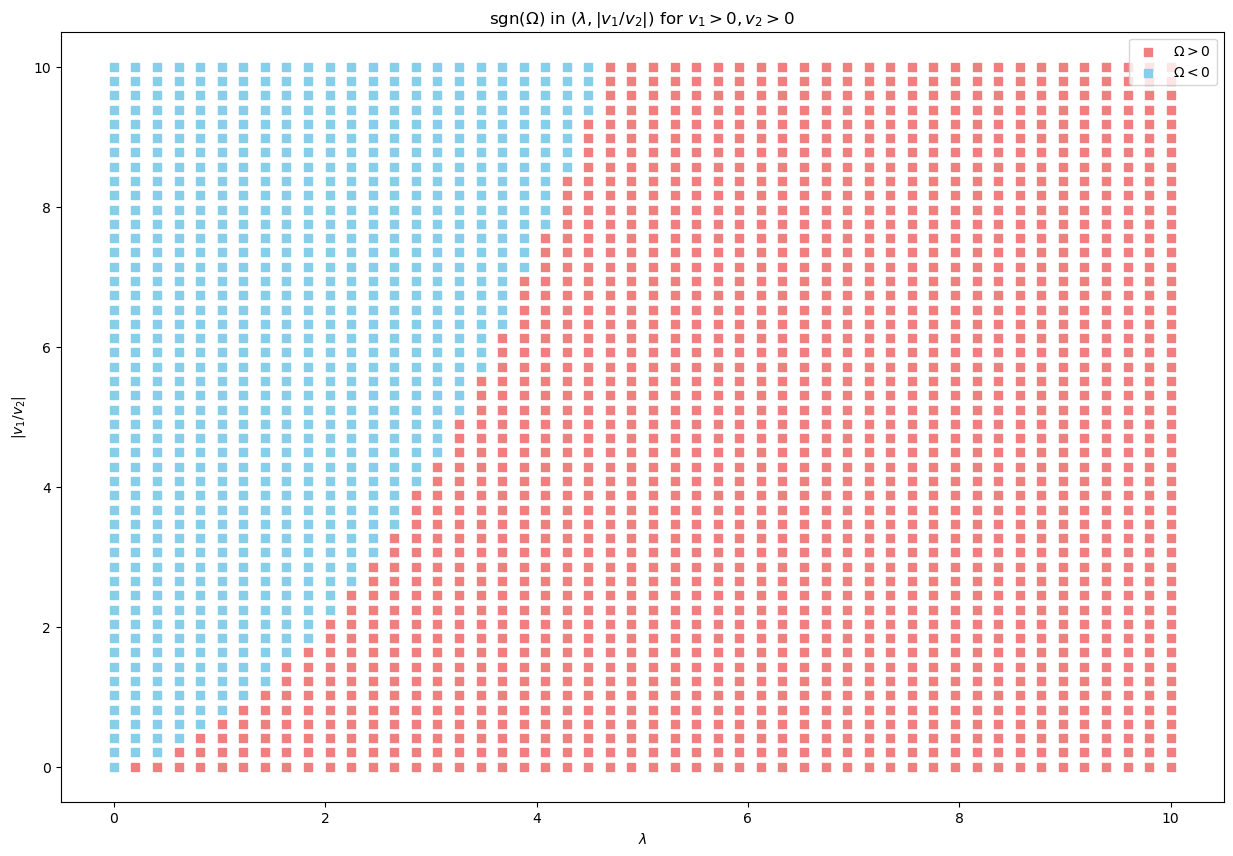

In [397]:
bc_spacing = 10^(-4)
rs = 1
kappa = 1
shells = 5
k = kappa * [1, 0]
v1_sgn = 1
v2_sgn = 1
lambda_mBZ_sgn_plot(bc_spacing, rs, kappa, shells, k, v1_sgn, v2_sgn)

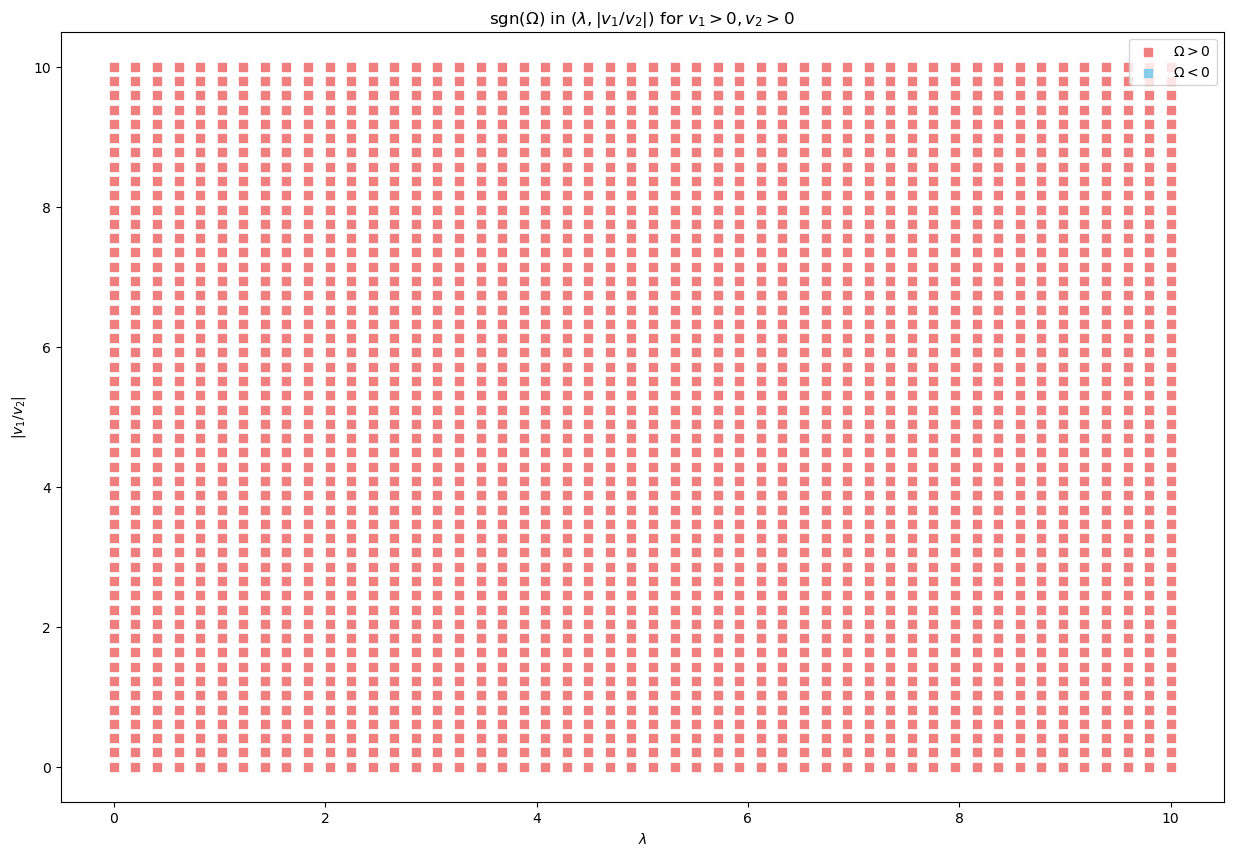

In [398]:
bc_spacing = 10^(-4)
rs = 1
kappa = 1
shells = 5
k = kappa * [1, 0]
v1_sgn = 1
v2_sgn = -1
lambda_mBZ_sgn_plot(bc_spacing, rs, kappa, shells, k, v1_sgn, v2_sgn)

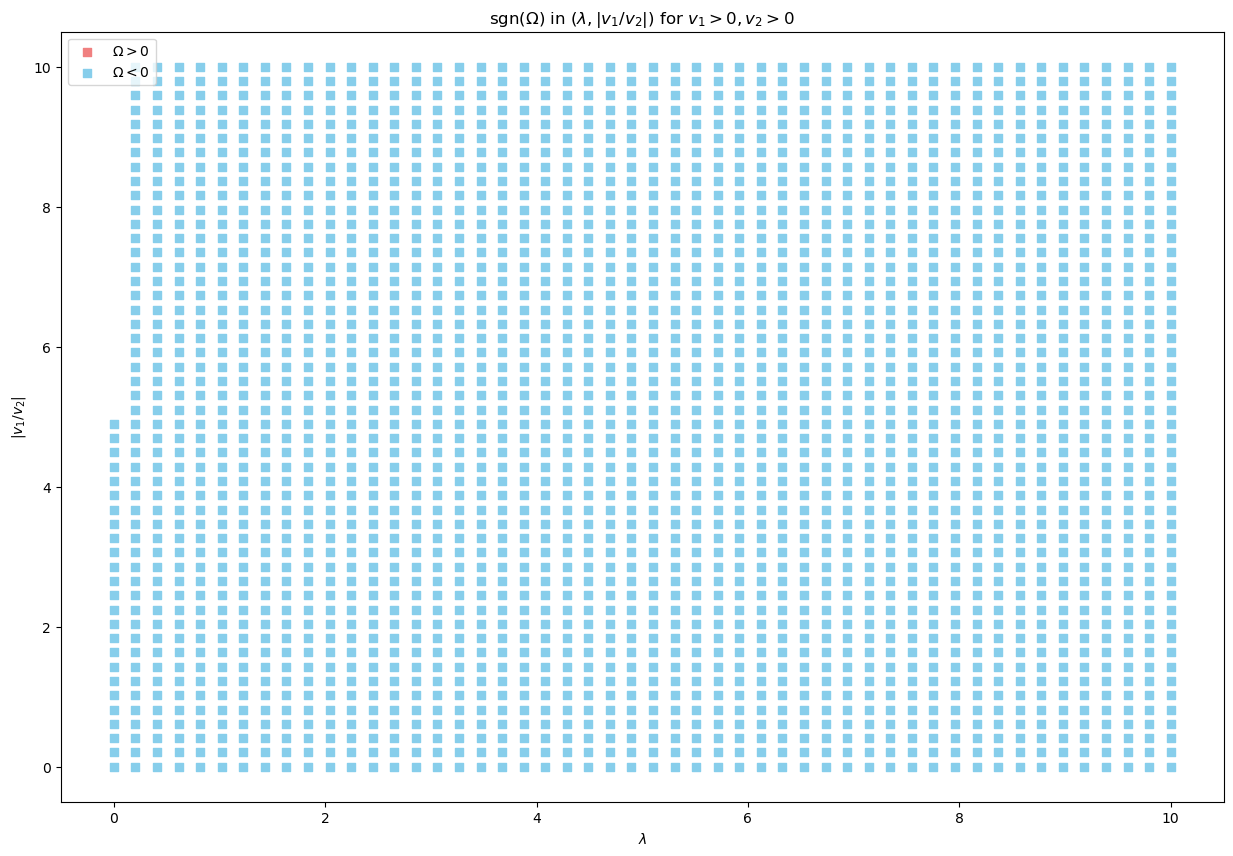

In [415]:
bc_spacing = 10^(-4)
rs = 1
kappa = 1
shells = 5
k = kappa * [1, 0]
v1_sgn = -1
v2_sgn = 1
lambda_mBZ_sgn_plot(bc_spacing, rs, kappa, shells, k, v1_sgn, v2_sgn)

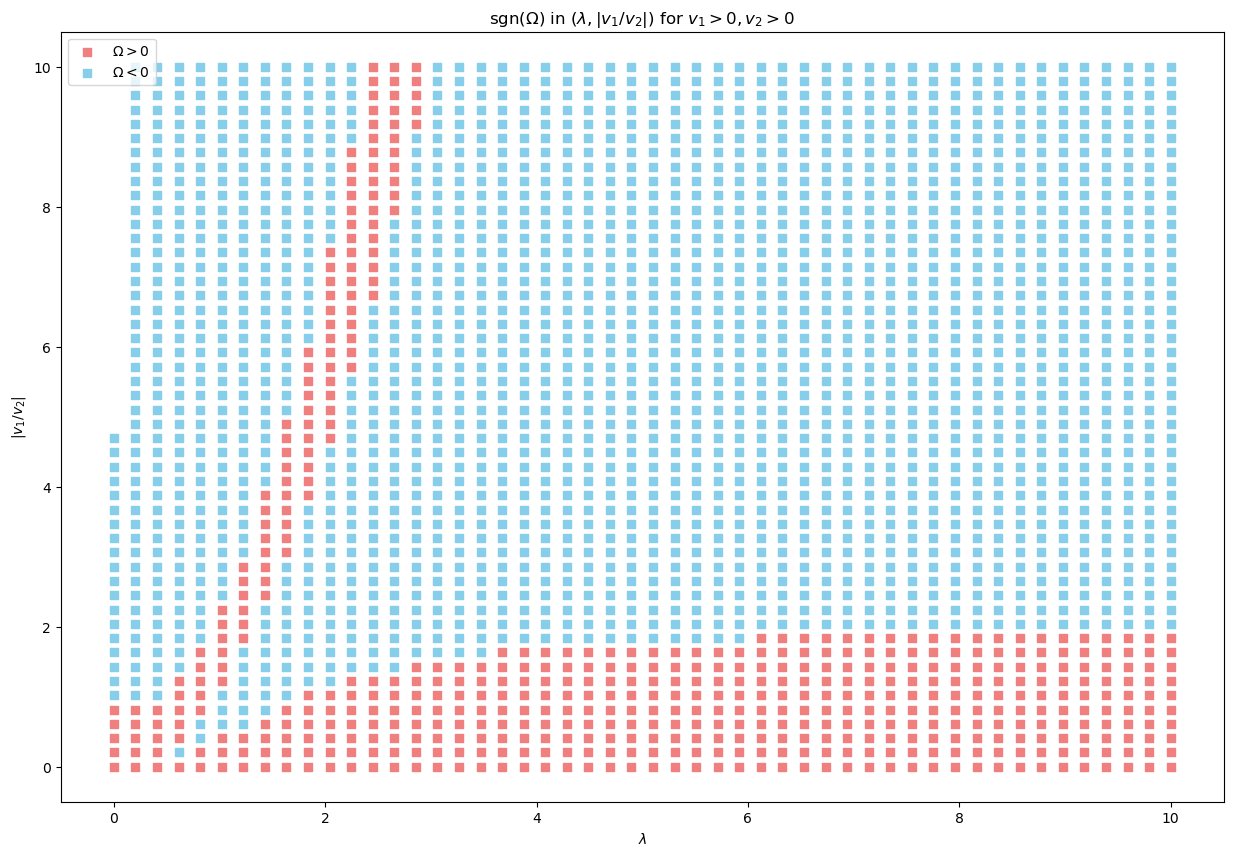

In [400]:
bc_spacing = 10^(-4)
rs = 1
kappa = 1
shells = 5
k = kappa * [1, 0]
v1_sgn = -1
v2_sgn = -1
lambda_mBZ_sgn_plot(bc_spacing, rs, kappa, shells, k, v1_sgn, v2_sgn)

## 3-patch signs

In [5]:
# Berry curvature sign plot
function lambda_3p_sgn_plot(bc_spacing, rs, kappa, shells, k, v1_sgn, v2_sgn)
    n_pts = 50

    lambda_list = range(10^(-3), 5, n_pts)
    v_list = range(10^(-3), 5, n_pts)

    pos_x = []
    pos_y = []
    neg_x = []
    neg_y = []
    zero_x = []
    zero_y = []

    for i in 1:n_pts
        lambda = lambda_list[i]
        for j in 1:n_pts
            delta = 1/2 * lambda_delta(kappa, lambda, v1_sgn * v_list[j], v2_sgn)
            alpha = 1/2 * lambda_alpha(kappa, lambda, v1_sgn * v_list[j], v2_sgn)
            vF = 2 * kappa / rs^2

            temp_bc = bc_no_spinors(reshape(k, (1, 2)), bc_spacing, vF, delta, alpha)[1]

            # temp_bc = lambda_patch_bc(reshape(k, (1, 2)), bc_spacing, lambda, kappa, vF, delta, alpha)[1]
            bc_sgn = approx_sign(temp_bc)
            if bc_sgn < 0
                push!(pos_x, lambda)
                push!(pos_y, v_list[j])
            elseif bc_sgn > 0
                push!(neg_x, lambda)
                push!(neg_y, v_list[j])
            else
                push!(zero_x, lambda)
                push!(zero_y, v_list[j])
            end
        end
    end

    fig, ax = plt.subplots(1,1,figsize=(15, 10))

    # phase_boundary_RMG_exp
    # lambda_boundary = range(10^(-3), 10, 10^4)
    # ax.scatter(lambda_boundary, lambda_boundary .^2, c="black")
    
    # Berry curvature
    ax.scatter(pos_x, pos_y, c="lightcoral", marker = "s", label = L"$\Omega > 0$")
    ax.scatter(neg_x, neg_y, c="skyblue", marker = "s", label = L"$\Omega < 0$")

    ax.set_xlabel(L"$\lambda$")
    ax.set_ylabel(L"$|v_1 / v_2|$")
    ax.set_title(L"\text{sgn}(\tilde{\Omega}) \text{ in } (\lambda, |v_1/v_2|) \text{ for } v_1 > 0, v_2 > 0")
    ax.legend()

    fig
end
    

lambda_3p_sgn_plot (generic function with 1 method)

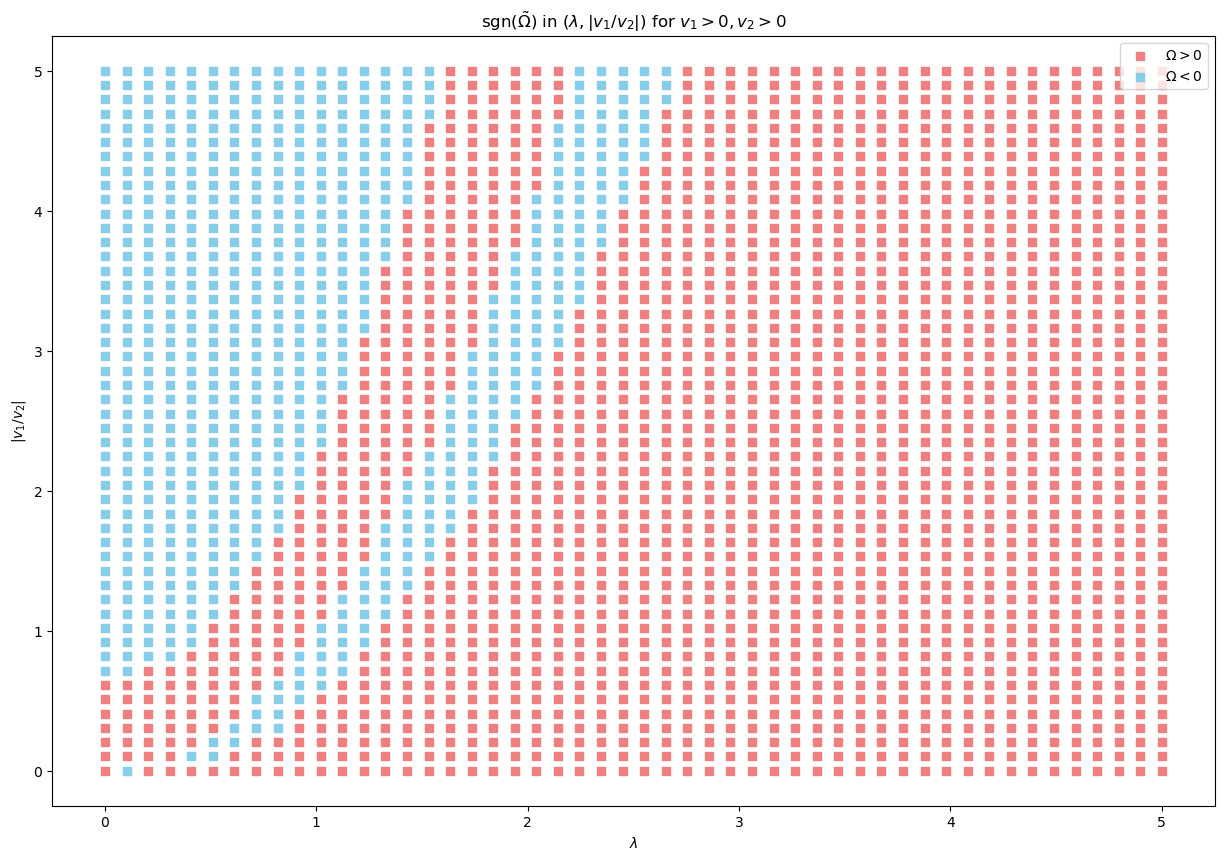

In [430]:
bc_spacing = 10^(-4)
rs = 1
kappa = 1
shells = 5
k = [0, 0]
v1_sgn = -1
v2_sgn = -1
lambda_3p_sgn_plot(bc_spacing, rs, kappa, shells, k, v1_sgn, v2_sgn)

## Comparison Plots

In [6]:
# Berry curvature sign plot
function lambda_all_sgn_plot(bc_spacing, rs, kappa, shells, q, v1_sgn, v2_sgn)
    n_pts = 50

    lambda_list = range(10^(-3), 5, n_pts)
    v_list = range(10^(-3), 5, n_pts)

    mBZ_pos_x = []
    mBZ_pos_y = []
    mBZ_neg_x = []
    mBZ_neg_y = []
    mBZ_zero_x = []
    mBZ_zero_y = []

    p_pos_x = []
    p_pos_y = []
    p_neg_x = []
    p_neg_y = []
    p_zero_x = []
    p_zero_y = []

    pure_3p_pos_x = []
    pure_3p_pos_y = []
    pure_3p_neg_x = []
    pure_3p_neg_y = []
    pure_3p_zero_x = []
    pure_3p_zero_y = []

    for i in 1:n_pts
        lambda = lambda_list[i]
        for j in 1:n_pts
            V = [[v1_sgn * v_list[j], 0] [0, v2_sgn]]
            k = kappa * [1, 0] .+ q
            temp_bc = grid_bc(reshape(k, (1, 2)), lambda, rs, kappa, V, shells, 1, bc_spacing)[1]
            mBZ_sgn = approx_sign(temp_bc)

            delta = 1/2 * lambda_delta(kappa, lambda, v1_sgn * v_list[j], v2_sgn)
            alpha = 1/2 * lambda_alpha(kappa, lambda, v1_sgn * v_list[j], v2_sgn)
            vF = 2 * kappa / rs^2

            temp_bc = lambda_patch_bc(reshape(q, (1, 2)), bc_spacing, lambda, kappa, vF, delta, alpha)[1]
            p_sgn = approx_sign(temp_bc)

            temp_bc = bc_no_spinors(reshape(q, (1, 2)), bc_spacing, vF, delta, alpha)[1]
            pure_3p_sgn = approx_sign(temp_bc)

            if mBZ_sgn > 0
                push!(mBZ_pos_x, lambda)
                push!(mBZ_pos_y, v_list[j])
            elseif mBZ_sgn < 0
                push!(mBZ_neg_x, lambda)
                push!(mBZ_neg_y, v_list[j])
            else
                push!(mBZ_zero_x, lambda)
                push!(mBZ_zero_y, v_list[j])
            end

            if p_sgn > 0
                push!(p_pos_x, lambda)
                push!(p_pos_y, v_list[j])
            elseif p_sgn < 0
                push!(p_neg_x, lambda)
                push!(p_neg_y, v_list[j])
            else
                push!(p_zero_x, lambda)
                push!(p_zero_y, v_list[j])
            end

            if pure_3p_sgn > 0
                push!(pure_3p_pos_x, lambda)
                push!(pure_3p_pos_y, v_list[j])
            elseif pure_3p_sgn < 0
                push!(pure_3p_neg_x, lambda)
                push!(pure_3p_neg_y, v_list[j])
            else
                push!(pure_3p_zero_x, lambda)
                push!(pure_3p_zero_y, v_list[j])
            end
        end
    end

    fig, axs = plt.subplots(1,3,figsize=(25, 8))

    
    # Berry curvature
    axs[1].scatter(mBZ_pos_x, mBZ_pos_y, c="lightcoral", marker = "s", label = L"$\Omega > 0$")
    axs[1].scatter(mBZ_neg_x, mBZ_neg_y, c="skyblue", marker = "s", label = L"$\Omega < 0$")
    axs[1].set_xlabel(L"$\lambda$")
    axs[1].set_ylabel(L"$|v_1 / v_2|$")
    axs[1].set_title(L"\text{sgn}(\Omega^\text{mBZ}) \text{ in } (\lambda, |v_1/v_2|)")
    axs[1].legend()

    axs[2].scatter(p_pos_x, p_pos_y, c="lightcoral", marker = "s", label = L"$\Omega > 0$")
    axs[2].scatter(p_neg_x, p_neg_y, c="skyblue", marker = "s", label = L"$\Omega < 0$")
    axs[2].set_xlabel(L"$\lambda$")
    axs[2].set_ylabel(L"$|v_1 / v_2|$")
    axs[2].set_title(L"\text{sgn}(\Omega^\text{3p}) \text{ in } (\lambda, |v_1/v_2|)")
    axs[2].legend()

    axs[3].scatter(pure_3p_pos_x, pure_3p_pos_y, c="lightcoral", marker = "s", label = L"$\Omega > 0$")
    axs[3].scatter(pure_3p_neg_x, pure_3p_neg_y, c="skyblue", marker = "s", label = L"$\Omega < 0$")
    axs[3].set_xlabel(L"$\lambda$")
    axs[3].set_ylabel(L"$|v_1 / v_2|$")
    axs[3].set_title(L"\text{sgn}(\tilde{\Omega}) \text{ in } (\lambda, |v_1/v_2|)")
    axs[3].legend()

    fig
end
    

lambda_all_sgn_plot (generic function with 1 method)

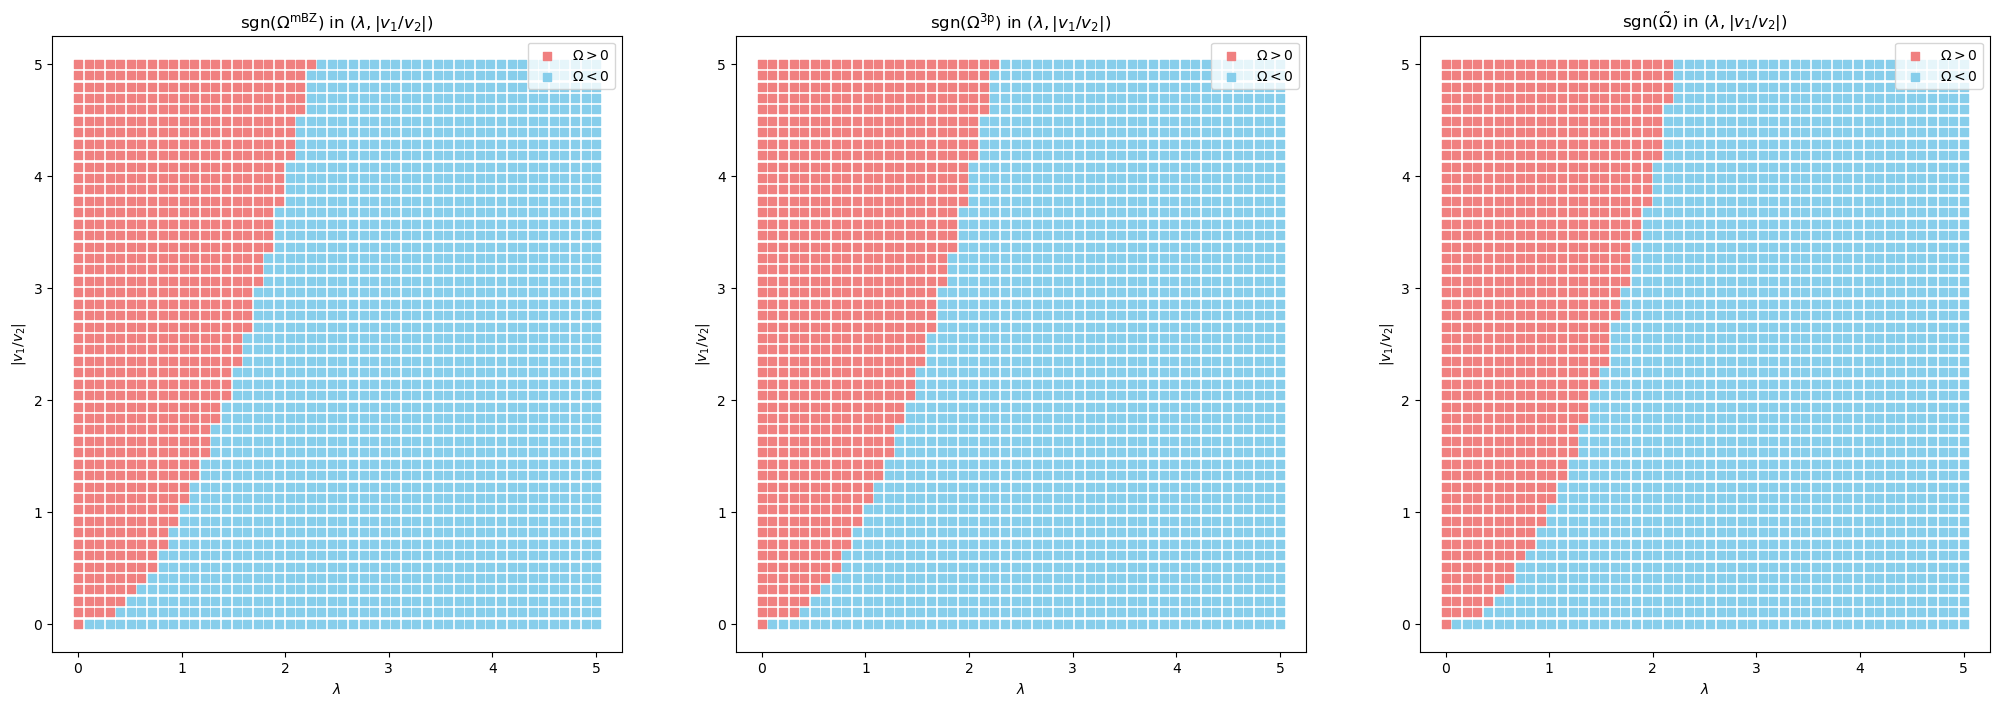

In [229]:
bc_spacing = 10^(-4)
rs = 0.1
kappa = 1
shells = 5
q = [0, 0]
v1_sgn = 1
v2_sgn = 1
lambda_all_sgn_plot(bc_spacing, rs, kappa, shells, q, v1_sgn, v2_sgn)

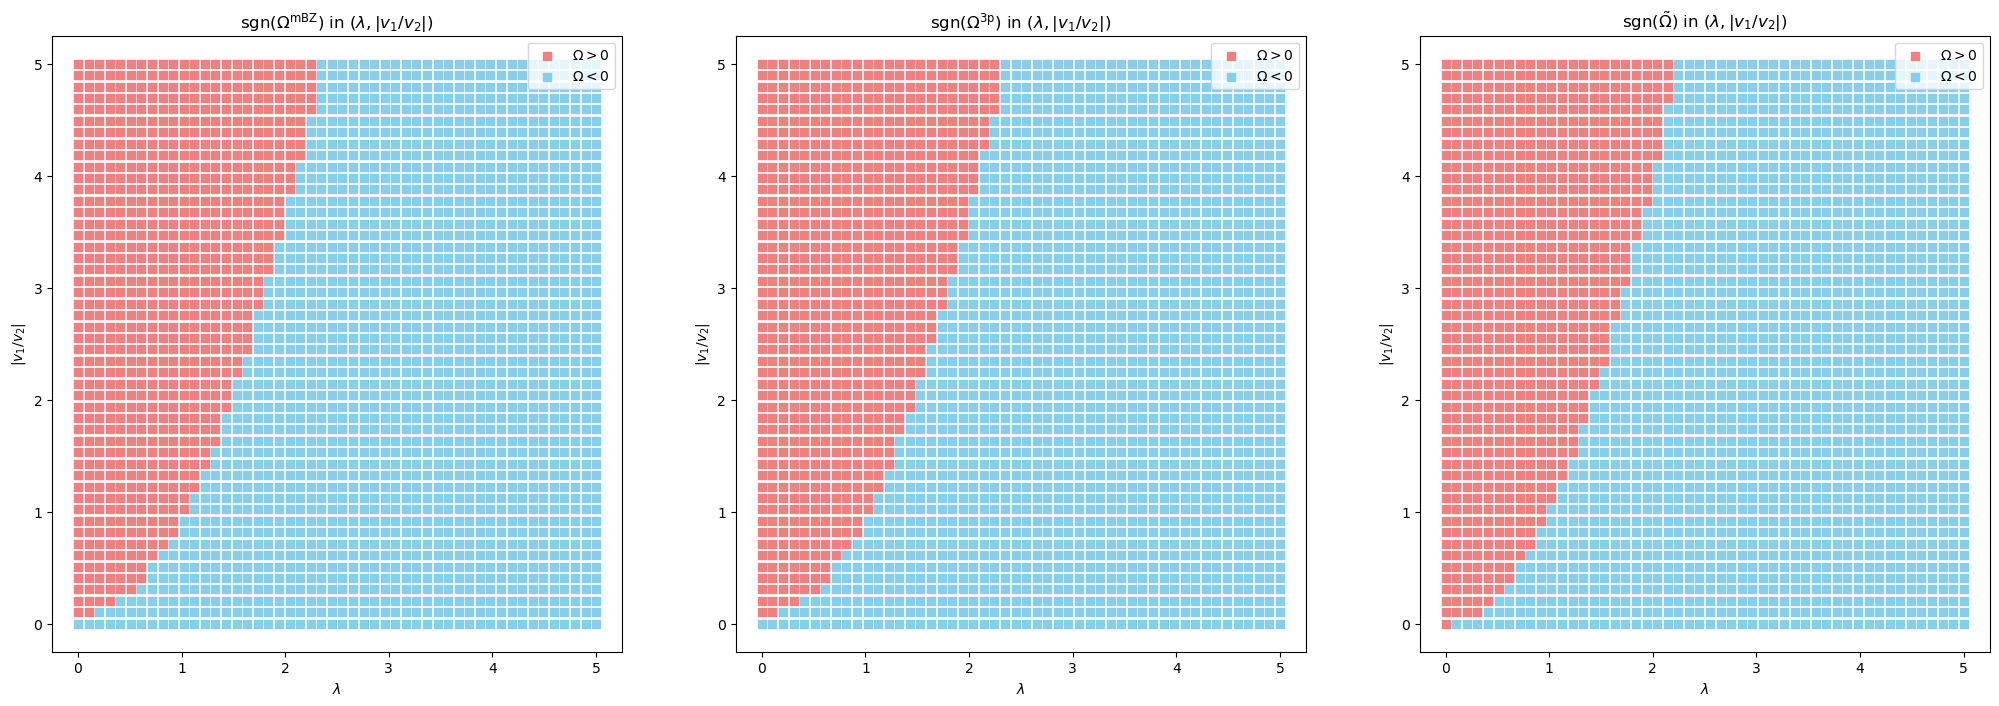

In [230]:
bc_spacing = 10^(-4)
rs = 0.1
kappa = 1
shells = 5
q = [0.01, 0.01]
v1_sgn = 1
v2_sgn = 1
lambda_all_sgn_plot(bc_spacing, rs, kappa, shells, q, v1_sgn, v2_sgn)

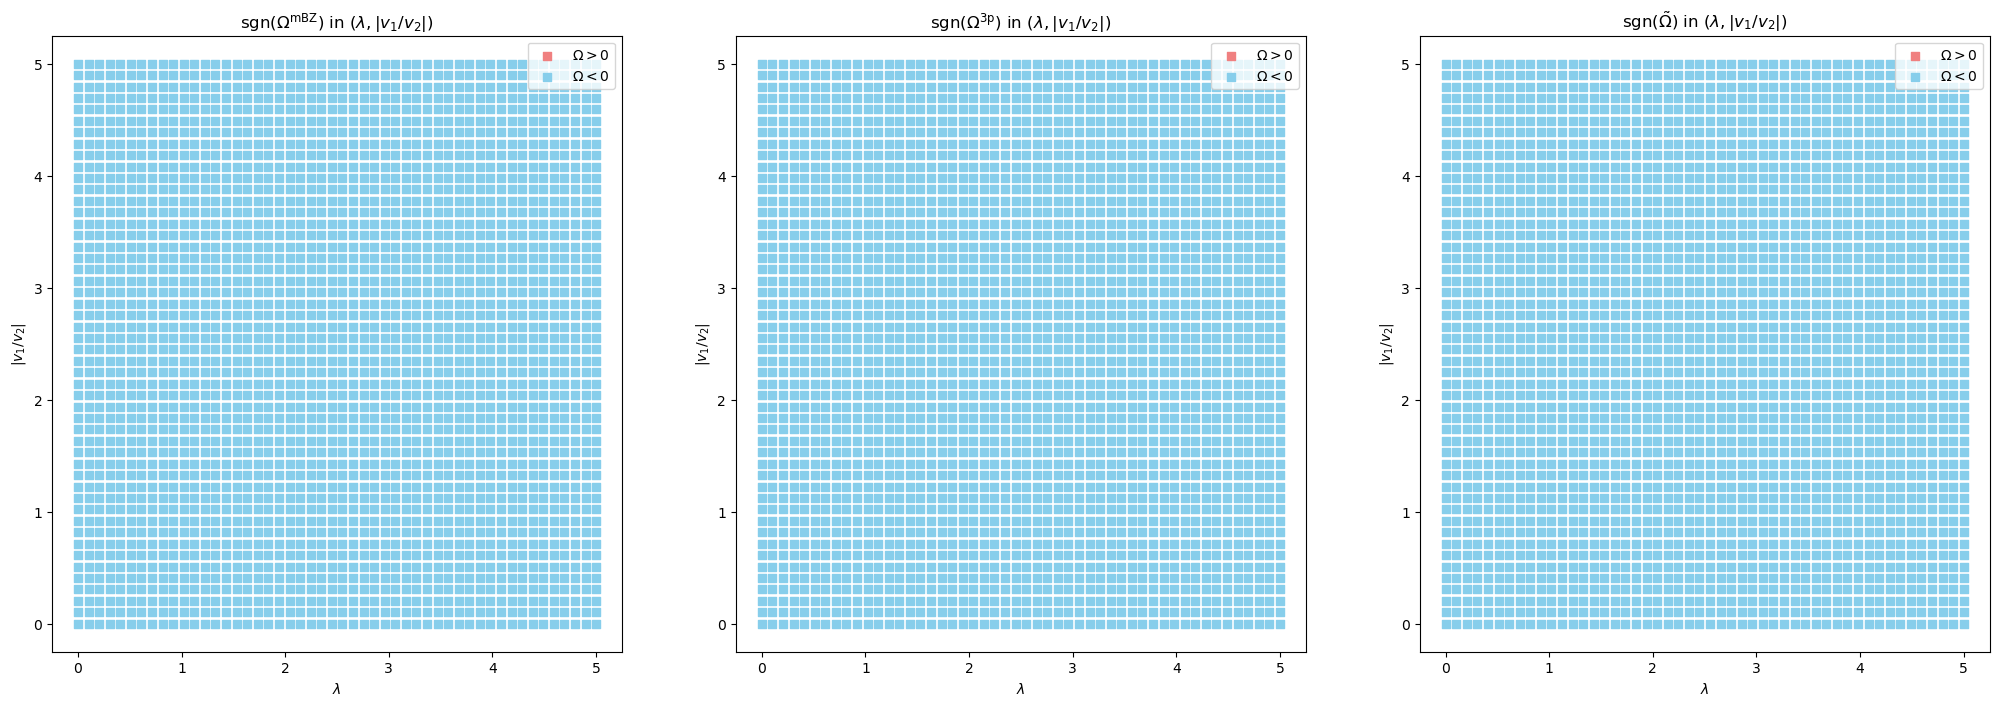

In [231]:
bc_spacing = 10^(-4)
rs = 0.1
kappa = 1
shells = 5
q = [0, 0]
v1_sgn = 1
v2_sgn = -1
lambda_all_sgn_plot(bc_spacing, rs, kappa, shells, q, v1_sgn, v2_sgn)

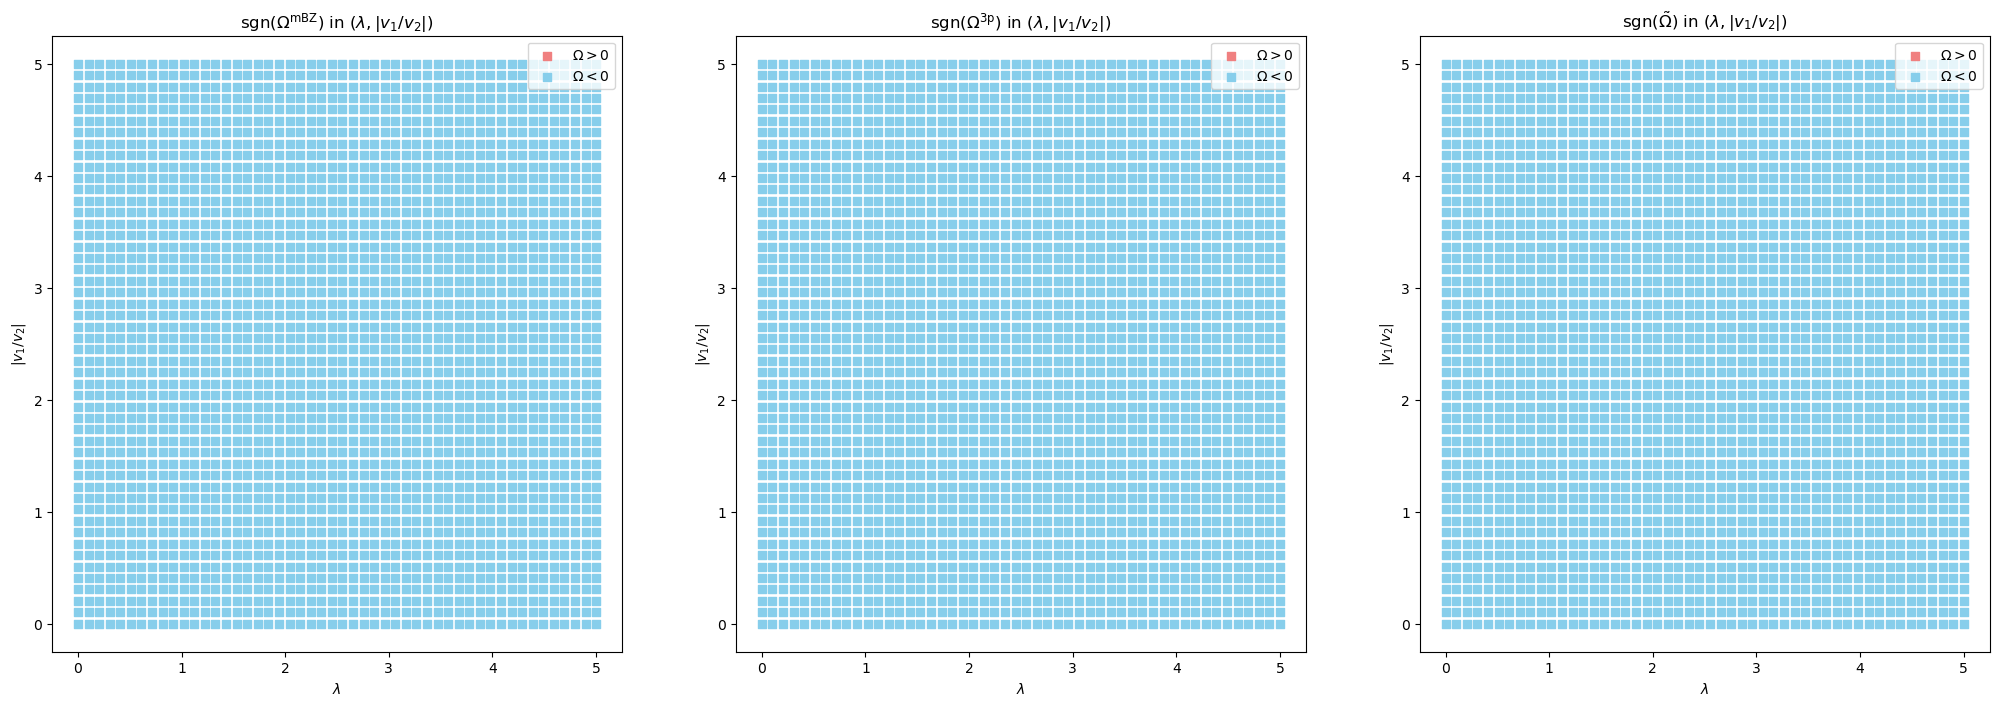

In [232]:
bc_spacing = 10^(-4)
rs = 0.1
kappa = 1
shells = 5
q = [0.01, 0.01]
v1_sgn = 1
v2_sgn = -1
lambda_all_sgn_plot(bc_spacing, rs, kappa, shells, q, v1_sgn, v2_sgn)

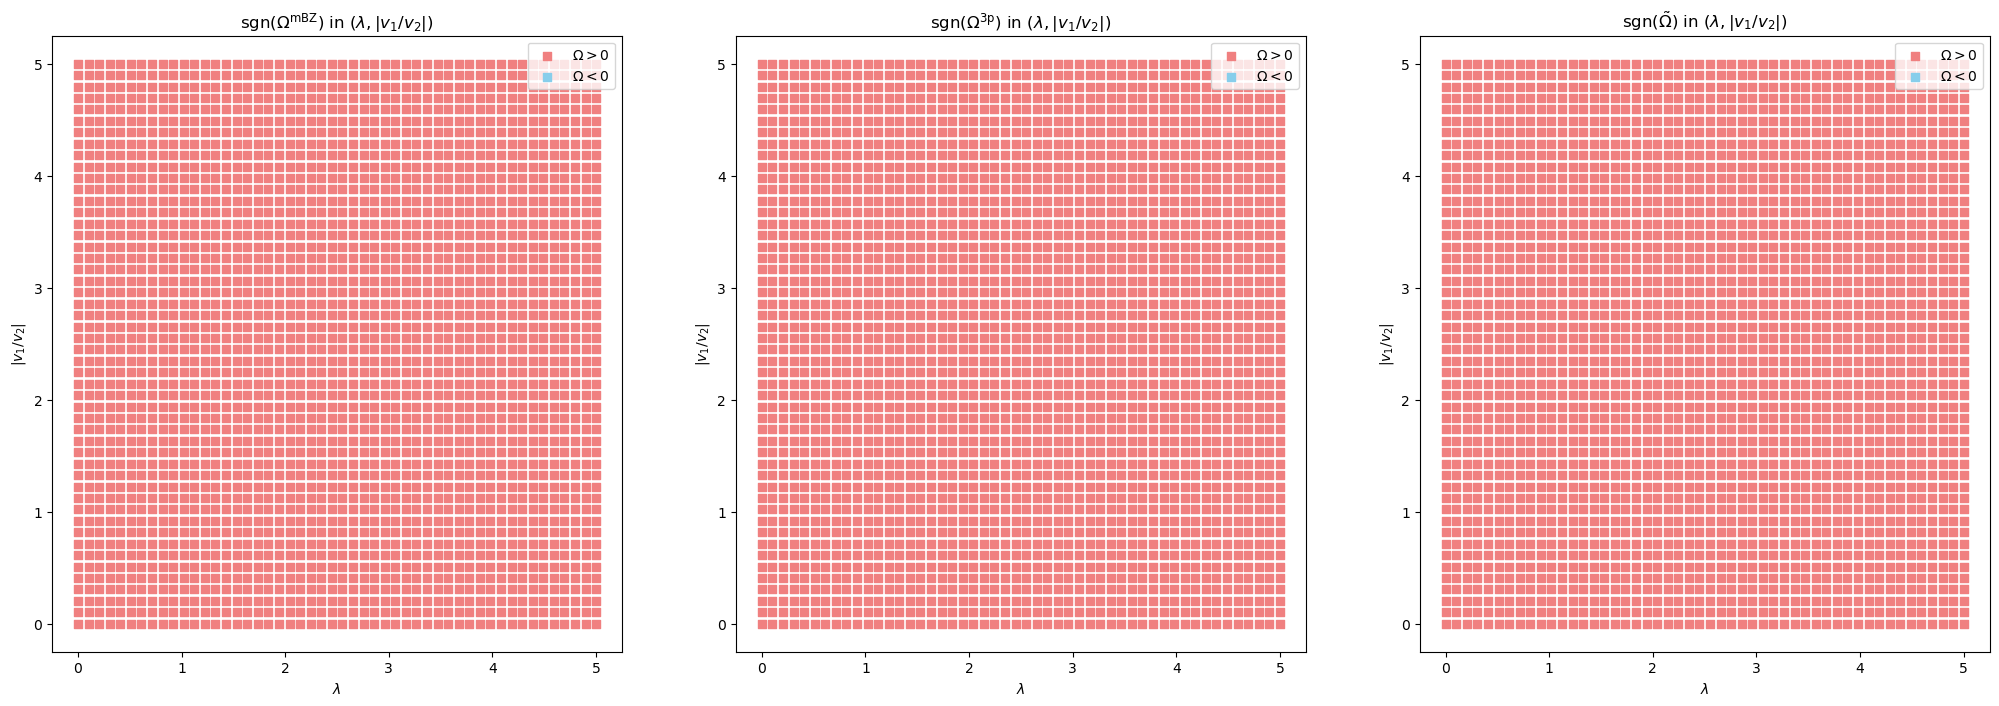

In [233]:
bc_spacing = 10^(-4)
rs = 0.1
kappa = 1
shells = 5
q = [0, 0]
v1_sgn = -1
v2_sgn = 1
lambda_all_sgn_plot(bc_spacing, rs, kappa, shells, q, v1_sgn, v2_sgn)

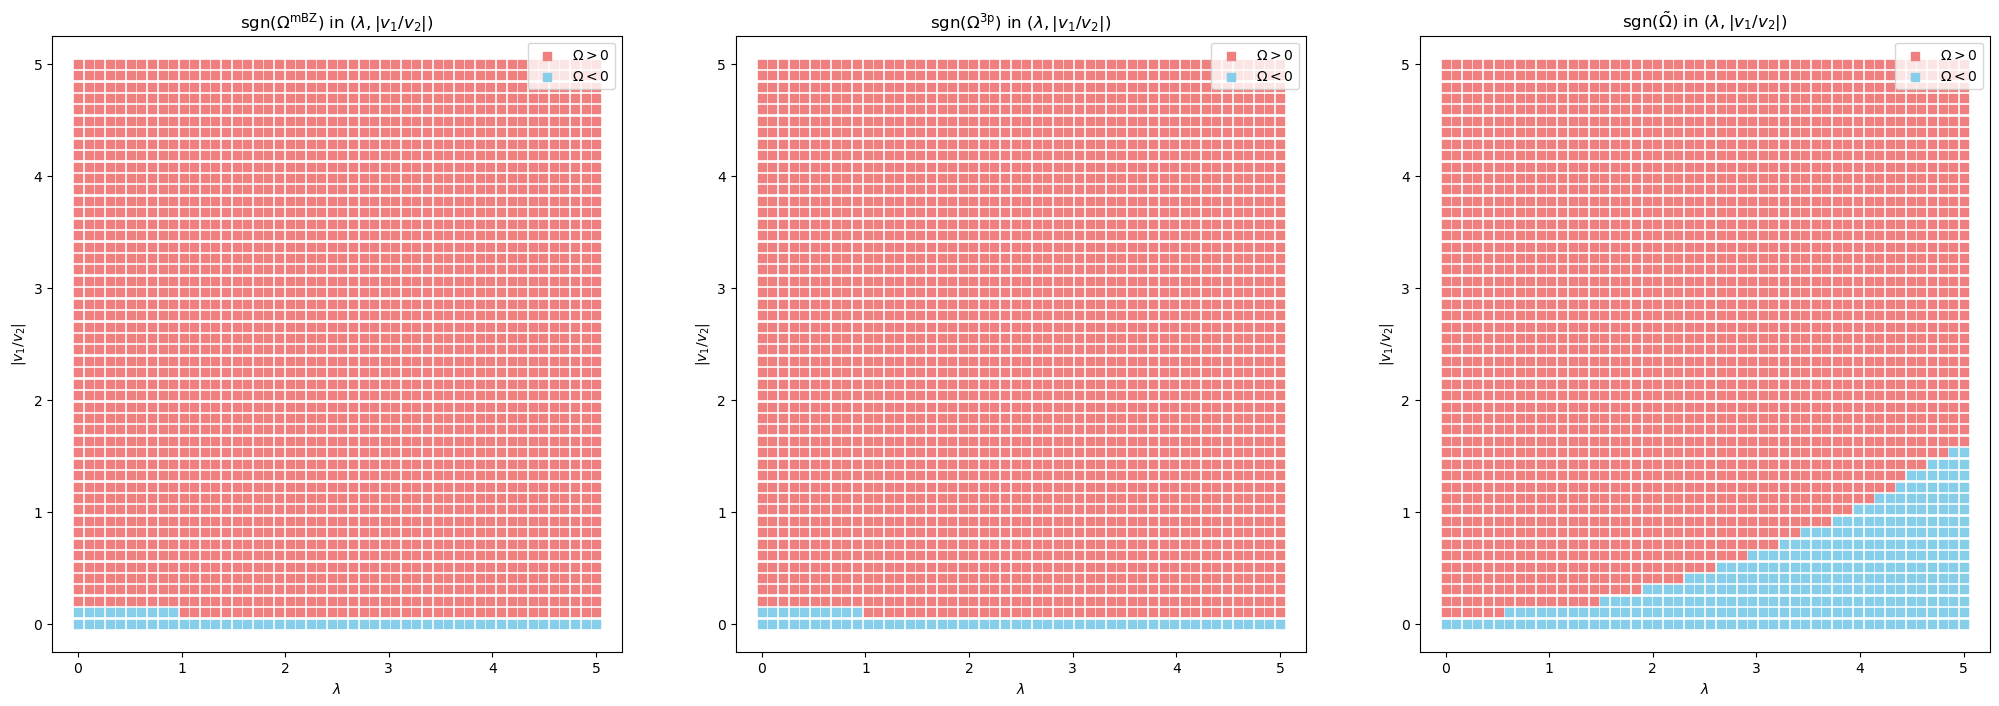

In [234]:
bc_spacing = 10^(-4)
rs = 0.1
kappa = 1
shells = 5
q = [0.01, 0.01]
v1_sgn = -1
v2_sgn = 1
lambda_all_sgn_plot(bc_spacing, rs, kappa, shells, q, v1_sgn, v2_sgn)

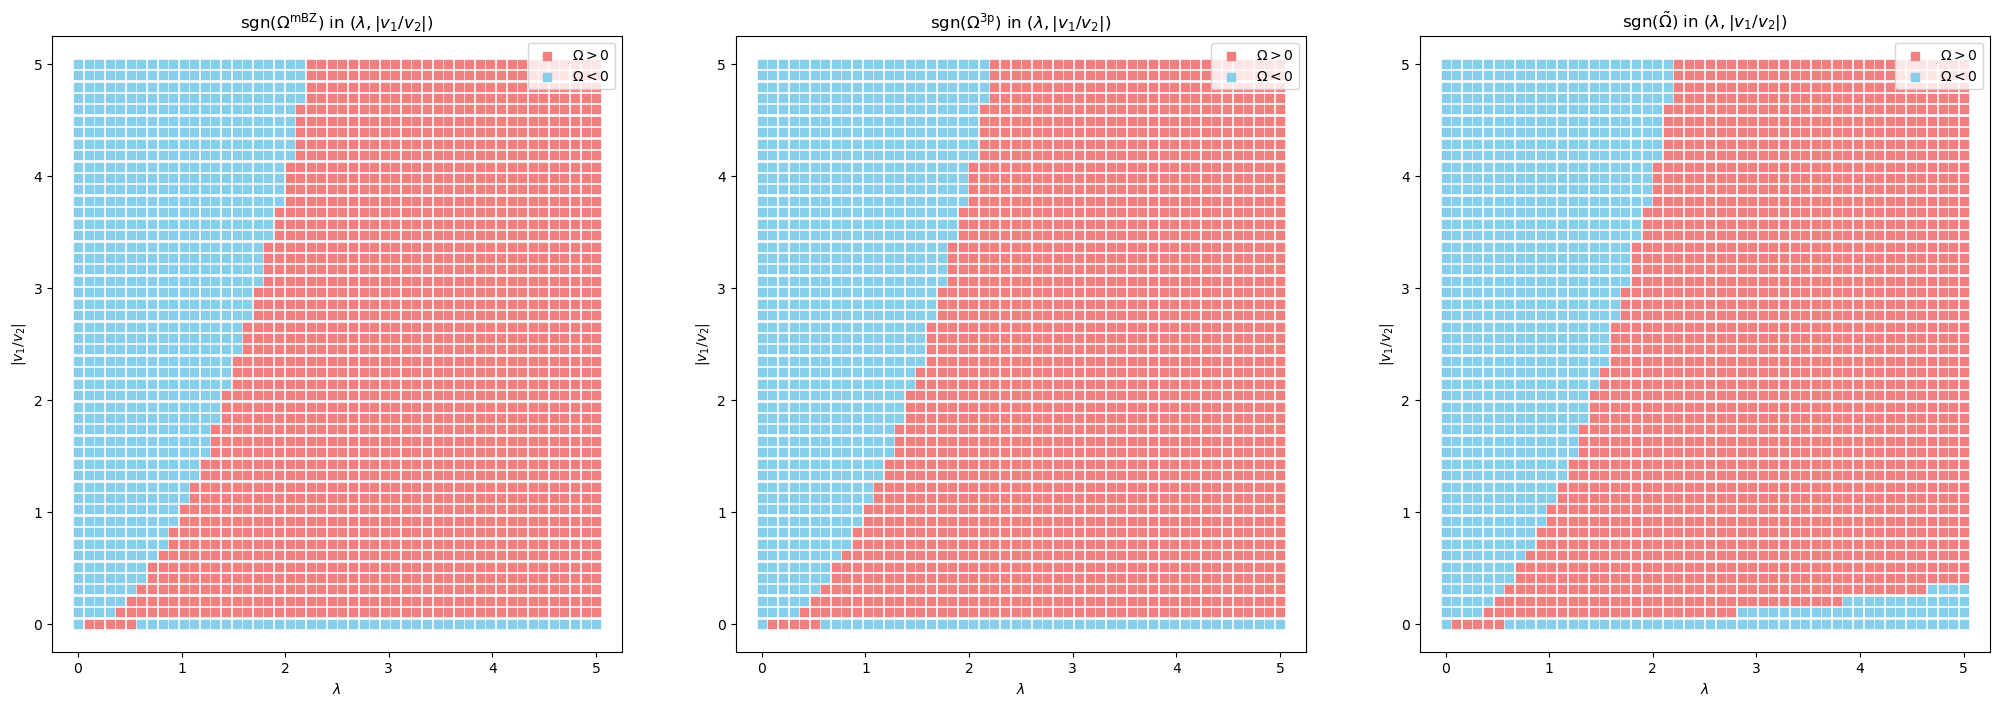

In [235]:
bc_spacing = 10^(-4)
rs = 0.1
kappa = 1
shells = 5
q = [0, 0]
v1_sgn = -1
v2_sgn = -1
lambda_all_sgn_plot(bc_spacing, rs, kappa, shells, q, v1_sgn, v2_sgn)

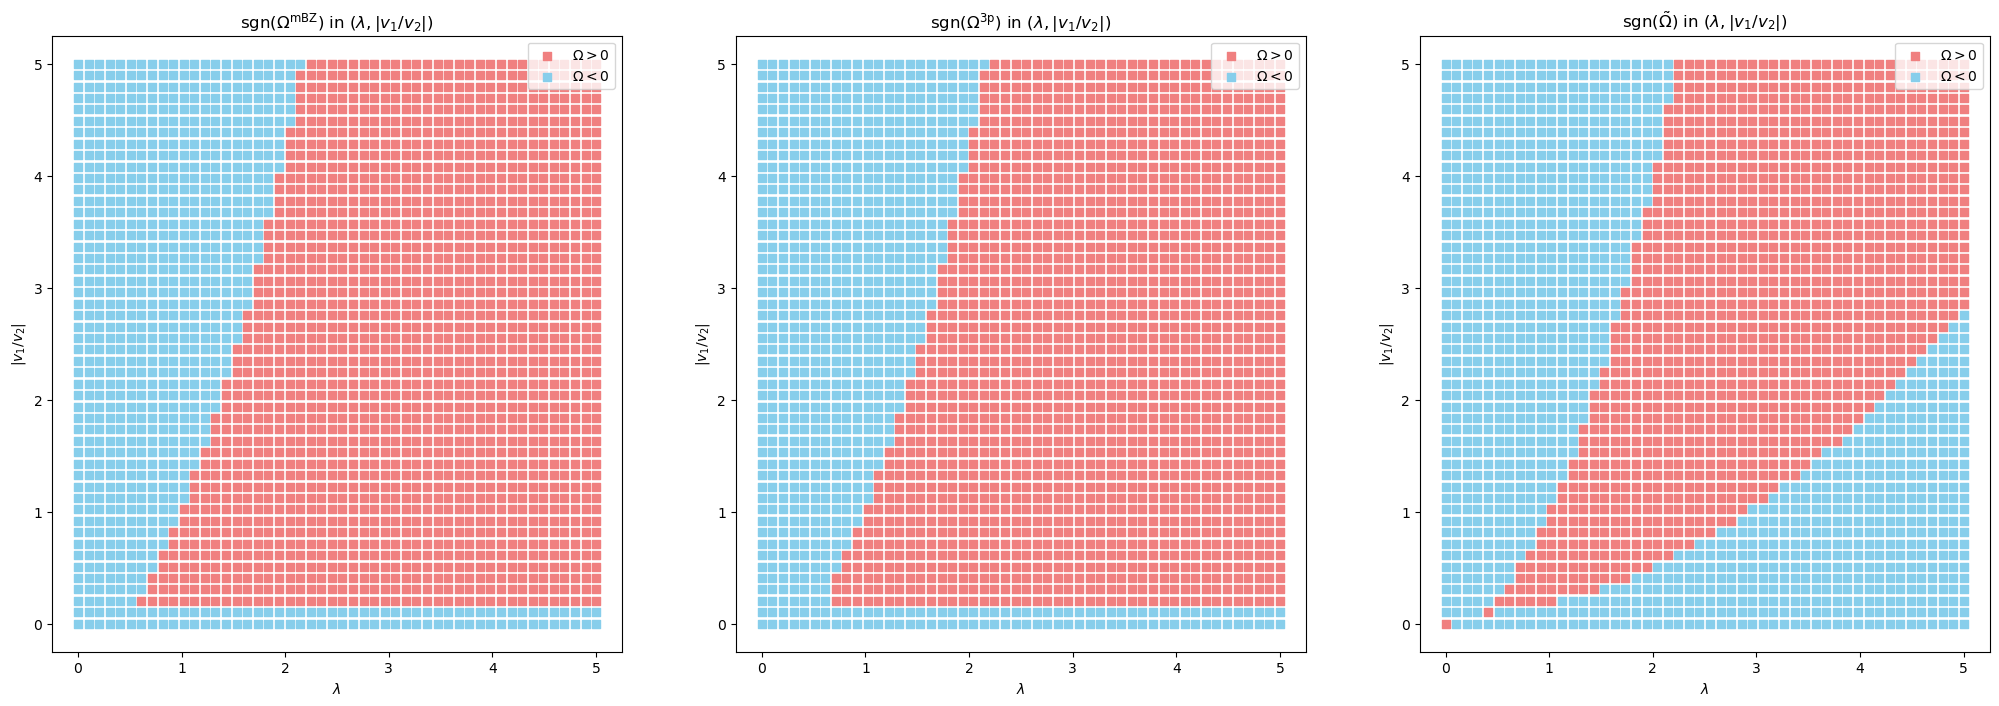

In [236]:
bc_spacing = 10^(-4)
rs = 0.1
kappa = 1
shells = 5
q = [0.01, 0.01]
v1_sgn = -1
v2_sgn = -1
lambda_all_sgn_plot(bc_spacing, rs, kappa, shells, q, v1_sgn, v2_sgn)

# Dispersion $\epsilon_k = \frac{2 \kappa^2 }{n} \bigg(\frac{k}{\kappa} \bigg)^n \implies v_F = 2 \kappa$

With this modified dispersion, the hope is that higher-shell participation in the ground state is sufficiently suppressed that we can recover 3-patch behavior for stronger moire potentials.

In [379]:
function mod_lambda_epsilon(k, n, vF, kappa)
    return vF * kappa/n * (norm(k)/kappa)^n
end
function mod_lambda_ham!(g1, g2, shell_parts, partitions, part_1s, dict, ham, k, lambda, n, vF, V)
    kappa = norm(g2)/sqrt(3)
    # connect all lower order mBZ's to their nn
    for i in 1:length(partitions)
        part_i = partitions[i]
        idex = dict[part_i]
        for j in 1:7
            part_j = part_1s[j]
            gi = part_i[1] * g1 + part_i[2] * g2
            gj = gi .+ part_j[1] * g1 + part_j[2] * g2
            jdex = dict[part_i .+ part_j]
            if part_j != (0, 0)
                val = 1/2 * lambda_ff(V, lambda, k .+ gi, k .+ gj)
                ham[idex, jdex] = val
                ham[jdex, idex] = conj(val)
            end
        end
    end
    # connect outside ring of mBZ's together
    outer_ring = setdiff(shell_parts, partitions)
    for i in 1:length(outer_ring)
        part_i = outer_ring[i]
        idex = dict[part_i]
        for j in 1:7
            part_j = part_1s[j]
            gi = part_i[1] * g1 + part_i[2] * g2
            gj = gi .+ part_j[1] * g1 + part_j[2] * g2
            if (part_i .+ part_j) in outer_ring && part_j != (0, 0)
                jdex = dict[part_i .+ part_j]
                val = 1/2 * lambda_ff(V, lambda, k .+ gi, k .+ gj)
                ham[idex, jdex] = val
                ham[jdex, idex] = conj(val)
            end
        end
    end
    # add in kinetic terms
    for i in 1:length(shell_parts)
        part = shell_parts[i]
        idex = dict[part]
        gi = part[1] * g1 + part[2] * g2
        ham[idex, idex] = mod_lambda_epsilon(gi .+ k, n, vF, kappa)
    end
    return ham
end
function mod_lambda_ham(k, lambda, n, vF, kappa, V, shells)
    mBZ_count = num_mBZ(shells)
    ham = zeros(ComplexF64, mBZ_count, mBZ_count)
    shell_parts = sgn_parts(shells)
    partitions = sgn_parts(shells - 1)
    part_1s = sgn_parts(1)
    dict = part_dict(shells)
    g1 = kappa * sqrt(3) * [-sqrt(3)/2, 1/2]
    g2 = kappa * sqrt(3) * [0, 1]
    mod_lambda_ham!(g1, g2, shell_parts, partitions, part_1s, dict, ham, k, lambda, n, vF, V)
end
function mod_lambda_mBZ_bc(k, lambda, n, vF, kappa, V, shells, index, spacing)
    num_vertices = 4

    g1 = kappa * sqrt(3) * [-sqrt(3)/2, 1/2]
    g2 = kappa * sqrt(3) * [0, 1]

    mBZ_count = num_mBZ(shells)
    shell_parts = sgn_parts(shells)
    partitions = sgn_parts(shells - 1)
    part_1s = sgn_parts(1)
    dict = part_dict(shells)

    ham = zeros(ComplexF64, mBZ_count, mBZ_count)
    
    spinors = Array{ComplexF64}(undef, num_vertices, mBZ_count, 2)
    grounds = Array{ComplexF64}(undef, num_vertices, mBZ_count)

    plaq_area = area(spacing * sqrt(2), num_vertices)
    mod_lambda_mBZ_bc!(g1, g2, num_vertices, plaq_area, shell_parts, partitions, part_1s, dict, ham, spinors, grounds, k, lambda, n, vF, kappa, V, shells, index, spacing)
end
function mod_lambda_mBZ_bc!(g1, g2, num_vertices, plaq_area, shell_parts, partitions, part_1s, dict, ham, spinors, grounds, k, lambda, n, vF, kappa, V, shells, index, spacing)
    for j in 1:num_vertices
        x_new = k[1] + spacing * cos(2 * pi * (j - 1) / num_vertices)
        y_new = k[2] + spacing * sin(2 * pi * (j - 1) / num_vertices)
        ham = mod_lambda_ham!(g1, g2, shell_parts, partitions, part_1s, dict, ham, [x_new, y_new], lambda, n, vF, V)
        grounds[j, :] = gauge_fix(normalize(eigvecs(Hermitian(ham))[:, index]))
        for m in 1:length(shell_parts)
            momentum = g1 * shell_parts[m][1] + g2 * shell_parts[m][2] + [x_new, y_new]
            spinors[j, m, :] = lambda_spinor(lambda, momentum)
        end
    end
    P = 1
    for j in 1:num_vertices
        if j < num_vertices
            temp = spinor_inner(grounds[j, :], grounds[j + 1, :], spinors[j, :, :], spinors[j + 1, :, :])
            P *= temp / abs(temp)
        else
            temp = spinor_inner(grounds[j, :], grounds[1, :], spinors[j, :, :], spinors[1, :, :])
            P *= temp / abs(temp)
        end
    end
    if abs(imag(P)) < 10^(-16)
        return -(angle(real(P))) / plaq_area
    else
        return -angle(P) / plaq_area
    end
end
function mod_grid_bc(grid, lambda, n, vF, kappa, V, shells, index, spacing)
    num_vertices = 4

    mBZ_count = num_mBZ(shells)
    shell_parts = sgn_parts(shells)
    partitions = sgn_parts(shells - 1)
    part_1s = sgn_parts(1)
    dict = part_dict(shells)

    ham = zeros(ComplexF64, mBZ_count, mBZ_count)
    spinors = Array{ComplexF64}(undef, num_vertices, mBZ_count, 2)
    grounds = Array{ComplexF64}(undef, num_vertices, mBZ_count)
    plaq_area = area(spacing * sqrt(2), num_vertices)

    g1 = kappa * sqrt(3) * [-sqrt(3)/2, 1/2]
    g2 = kappa * sqrt(3) * [0, 1]

    gi = zeros(2)
    gj = zeros(2)

    berry_list = Array{Float64}(undef, size(grid, 1))

    for i in 1:size(grid, 1)
        berry_list[i] = mod_lambda_mBZ_bc!(g1, g2, num_vertices, plaq_area, shell_parts, partitions, part_1s, dict, ham, spinors, grounds, 
        grid[i, :], lambda, n, vF, kappa, V, shells, index, spacing)
    end
    return berry_list
end
function mod_q_agreement(bc_spacing, lambda, n, vF, kappa, V, shells, k_angle)
    q_list = range(0, 0.1*kappa, 10^2)
    kappa_1 = kappa * [1, 0]
    mBZ_bc = Array{Float64}(undef, length(q_list))
    patch_bc = Array{Float64}(undef, length(q_list), 2)
    rel_error = Array{Float64}(undef, length(q_list), 2)

    for j in 1:length(q_list)
        mom = q_list[j] .* [cos(k_angle), sin(k_angle)]
        mBZ_mom = mom .+ kappa_1
        mBZ_bc[j] = mod_grid_bc(reshape(mBZ_mom, (1, 2)), lambda, n, vF, kappa, V, shells, 1, bc_spacing)[1]

        v1 = V[1, 1]
        v2 = V[2, 2]
        delta = 1/2 * lambda_delta(kappa, lambda, v1, v2)
        alpha = 1/2 * lambda_alpha(kappa, lambda, v1, v2)
        patch_bc[j, 1] = lambda_patch_bc(reshape(mom, (1, 2)), bc_spacing, lambda, kappa, vF, delta, alpha)[1]

        patch_bc[j, 2] = lambda_patch_bc(reshape(mom, (1, 2)), bc_spacing, lambda, kappa, vF, delta, 0)[1]

        rel_error[j, 1] = abs(1 - (patch_bc[j, 1]/mBZ_bc[j]))
        rel_error[j, 2] = abs(1 - (patch_bc[j, 2]/mBZ_bc[j]))
    end
    fig, axs = plt.subplots(1,2,figsize=(15, 6))

    axs[1].plot(q_list, mBZ_bc, label=L"\text{mBZ}")
    axs[1].plot(q_list, patch_bc[:, 1], label=L"\text{3p}")

    axs[1].set_xlabel(L"$k$")
    axs[1].set_ylabel(L"$\Omega$")
    axs[1].set_title(L"$\Omega \text{ vs } k$")
    axs[1].legend()

    axs[2].plot(q_list, rel_error[:, 1], label=L"$\alpha \neq 0$")
    axs[2].plot(q_list, rel_error[:, 2], label=L"$\alpha = 0$")

    axs[2].set_xlabel(L"$k$")
    axs[2].set_ylabel(L"$\delta \Omega$")
    axs[2].set_title(L"$\delta \Omega \text{ vs } k$")
    axs[2].set_yscale("log")
    axs[2].legend()

    fig.tight_layout()

    fig
end
function mod_ang_agreement(bc_spacing, lambda, n, vF, kappa, V, shells, q)
    ang_list = range(-pi, pi, 10^2)
    kappa_1 = kappa * [1, 0]
    mBZ_bc = Array{Float64}(undef, length(ang_list))
    patch_bc = Array{Float64}(undef, length(ang_list), 2)
    rel_error = Array{Float64}(undef, length(ang_list), 2)

    for j in 1:length(ang_list)
        mom = q .* [cos(ang_list[j]), sin(ang_list[j])]
        mBZ_mom = mom .+ kappa_1
        mBZ_bc[j] = grid_bc(reshape(mBZ_mom, (1, 2)), lambda, n, vF, kappa, V, shells, 1, bc_spacing)[1]

        v1 = V[1, 1]
        v2 = V[2, 2]
        delta = 1/2 * lambda_delta(kappa, lambda, v1, v2)
        alpha = 1/2 * lambda_alpha(kappa, lambda, v1, v2)
        patch_bc[j, 1] = lambda_patch_bc(reshape(mom, (1, 2)), bc_spacing, lambda, kappa, vF, delta, alpha)[1]

        patch_bc[j, 2] = lambda_patch_bc(reshape(mom, (1, 2)), bc_spacing, lambda, kappa, vF, delta, 0)[1]

        rel_error[j, 1] = abs(1 - (patch_bc[j, 1]/mBZ_bc[j]))
        rel_error[j, 2] = abs(1 - (patch_bc[j, 2]/mBZ_bc[j]))
    end
    fig, axs = plt.subplots(1,2,figsize=(15, 6))

    axs[1].plot(ang_list, mBZ_bc, label=L"\text{mBZ}")
    axs[1].plot(ang_list, patch_bc[:, 1], label=L"\text{3p}")

    axs[1].set_xlabel(L"$\arg(k)$")
    axs[1].set_ylabel(L"$\Omega$")
    axs[1].set_title(L"$\Omega \text{ vs } \arg(k)$")
    axs[1].legend()

    axs[2].plot(ang_list, rel_error[:, 1], label=L"$\alpha \neq 0$")
    axs[2].plot(ang_list, rel_error[:, 2], label=L"$\alpha = 0$")

    axs[2].set_xlabel(L"$\arg(k)$")
    axs[2].set_ylabel(L"$\delta \Omega$")
    axs[2].set_title(L"$\delta \Omega \text{ vs } \arg(k)$")
    axs[2].set_yscale("log")
    axs[2].legend()

    fig.tight_layout()

    fig
end

mod_ang_agreement (generic function with 1 method)

## Check ground state

In [380]:
function plot_ground_overlap(k, lambda, kappa, V, shells, vF)
    exp_list = range(-5, -1, 10^2)
    overlaps = Array{Float64}(undef, length(exp_list), 3)
    for j in 1:length(exp_list)
        rs = 10^exp_list[j]
        ham1 = lambda_ham(k, lambda, rs, kappa, V, shells)
        vec1 = normalize(eigvecs(Hermitian(ham1))[:, 1])

        n = 2
        ham2 = mod_lambda_ham(k, lambda, n, vF, kappa, V, shells)
        vec2 = normalize(eigvecs(Hermitian(ham2))[:, 1])
        overlaps[j, 1] = abs(dot(vec1, vec2))

        n = 5
        ham2 = mod_lambda_ham(k, lambda, n, vF, kappa, V, shells)
        vec2 = normalize(eigvecs(Hermitian(ham2))[:, 1])
        overlaps[j, 2] = abs(dot(vec1, vec2))

        n = 12
        ham2 = mod_lambda_ham(k, lambda, n, vF, kappa, V, shells)
        vec2 = normalize(eigvecs(Hermitian(ham2))[:, 1])
        overlaps[j, 3] = abs(dot(vec1, vec2))
    end
    rs_list = 10 .^exp_list
    fig, axs = plt.subplots(1,1,figsize=(12, 8))
    axs.plot(rs_list, overlaps[:, 1], label = L"$n = 2$")
    axs.plot(rs_list, overlaps[:, 2], label = L"$n = 5$")
    axs.plot(rs_list, overlaps[:, 3], label = L"$n = 12$")

    axs.set_xlabel(L"$r_s$")
    axs.set_ylabel(L"$|\langle \psi_1 | \psi_2 \rangle|$")
    axs.set_title(L"$|\langle \psi_1 | \psi_2 \rangle|\text{ vs } r_s$")
    axs.set_xscale("log")
    axs.legend()

    fig.tight_layout()

    fig
end

plot_ground_overlap (generic function with 1 method)

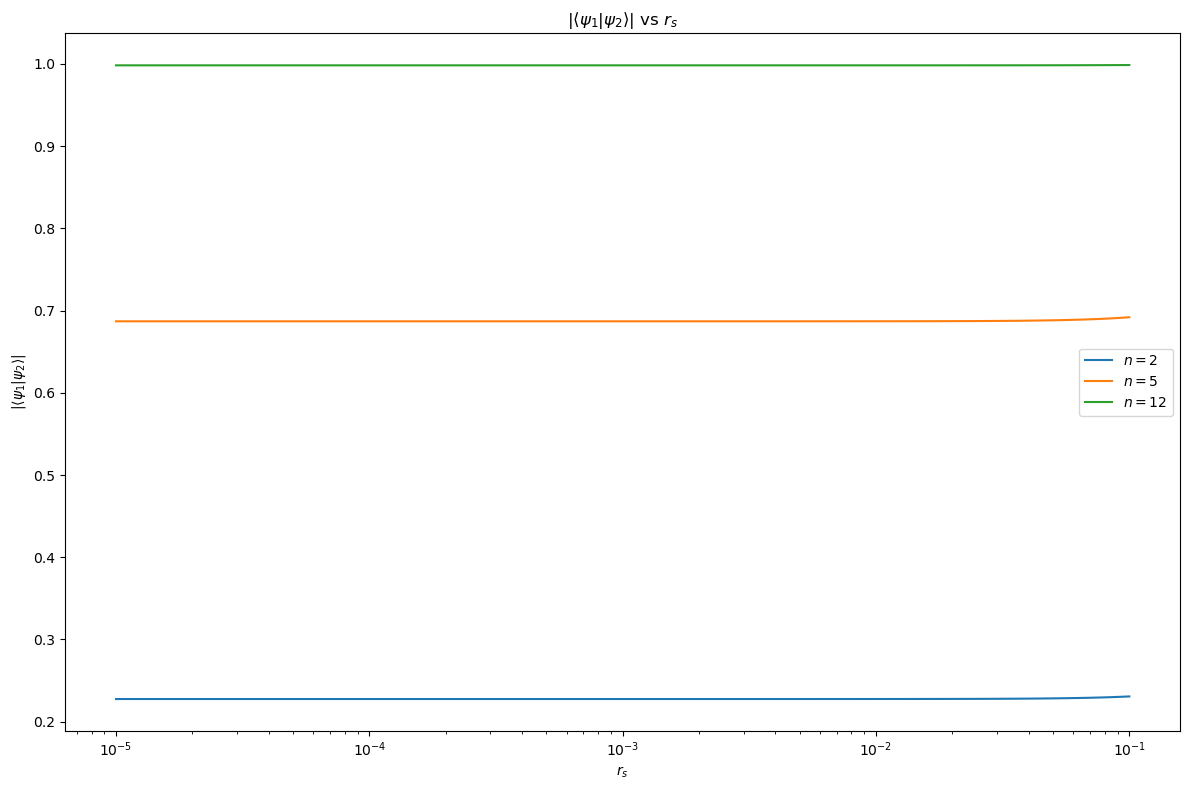

In [381]:
kappa = 1
k = kappa * [1, 0]
lambda = 1
V = [[-1, 0] [0, -3]]
shells = 5
vF = 0.1
plot_ground_overlap(k, lambda, kappa, V, shells, vF)

## Check Berry curvature

In [385]:
function mod_V_agreement(bc_spacing, lambda, n, vF, kappa, V, shells, q)
    V_scale = range(0.9, 1, 10^2)
    kappa_1 = kappa * [1, 0]
    mBZ_bc = Array{Float64}(undef, length(V_scale))
    patch_bc = Array{Float64}(undef, length(V_scale), 2)
    rel_error = Array{Float64}(undef, length(V_scale), 2)

    for j in 1:length(V_scale)
        mBZ_bc[j] = mod_grid_bc(reshape(kappa_1 .+ q, (1, 2)), lambda, n, vF, kappa, V_scale[j] * V, shells, 1, bc_spacing)[1]

        v1 = V[1, 1]
        v2 = V[2, 2]
        delta = V_scale[j] * 1/2 * lambda_delta(kappa, lambda, v1, v2)
        alpha = V_scale[j] * 1/2 * lambda_alpha(kappa, lambda, v1, v2)
        patch_bc[j, 1] = lambda_patch_bc(reshape(q, (1, 2)), bc_spacing, lambda, kappa, vF, delta, alpha, 1)[1]

        patch_bc[j, 2] = lambda_patch_bc(reshape(q, (1, 2)), bc_spacing, lambda, kappa, vF, delta, 0, 1)[1]

        rel_error[j, 1] = abs(1 - (patch_bc[j, 1]/mBZ_bc[j]))
        rel_error[j, 2] = abs(1 - (patch_bc[j, 2]/mBZ_bc[j]))
    end
    fig, axs = plt.subplots(1,2,figsize=(15, 6))

    axs[1].plot(V_scale, mBZ_bc, label=L"\text{mBZ}")
    axs[1].plot(V_scale, patch_bc[:, 1], label=L"\text{3p}")

    axs[1].set_xlabel(L"$|V|$")
    axs[1].set_ylabel(L"$\Omega$")
    axs[1].set_title(L"$\Omega \text{ vs } |V|$")
    axs[1].legend()

    axs[2].plot(V_scale, rel_error[:, 1], label=L"$\alpha \neq 0$")
    axs[2].plot(V_scale, rel_error[:, 2], label=L"$\alpha = 0$")

    axs[2].set_xlabel(L"$|V|$")
    axs[2].set_ylabel(L"$\delta \Omega$")
    axs[2].set_title(L"$\delta \Omega \text{ vs } |V|$")
    axs[2].set_yscale("log")
    axs[2].legend()

    fig.tight_layout()

    fig
end

mod_V_agreement (generic function with 1 method)

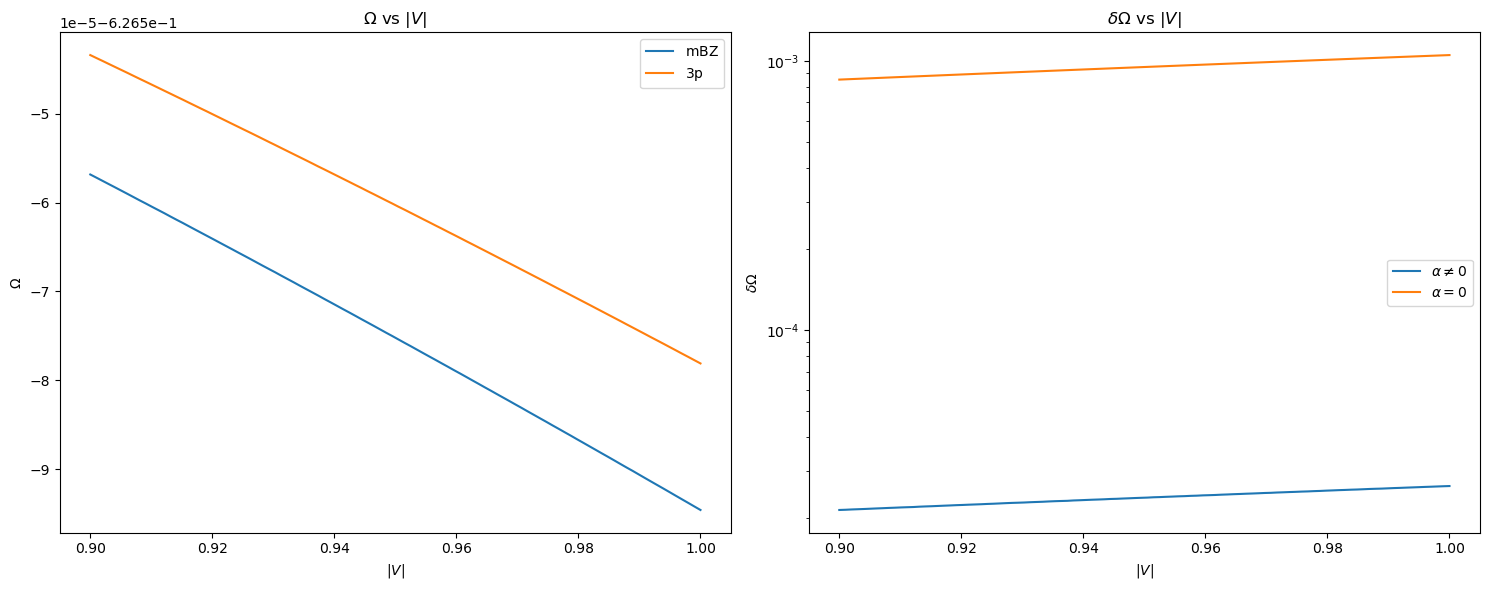

In [391]:
bc_spacing = 10^(-4)
lambda = 1.5
n = 2
vF = 1000
kappa = 1
V = [[1, 0] [0, 2]]
shells = 5
q = [0.1, 0.1]
mod_V_agreement(bc_spacing, lambda, n, vF, kappa, V, shells, q)

In [13]:
# Berry curvature sign plot
function mod_lambda_all_sgn_plot(bc_spacing, n, vF, kappa, shells, q, v1_sgn, v2_sgn)
    n_pts = 50

    lambda_list = range(10^(-3), 5, n_pts)
    v_list = range(10^(-3), 5, n_pts)

    mBZ_pos_x = []
    mBZ_pos_y = []
    mBZ_neg_x = []
    mBZ_neg_y = []
    mBZ_zero_x = []
    mBZ_zero_y = []

    p_pos_x = []
    p_pos_y = []
    p_neg_x = []
    p_neg_y = []
    p_zero_x = []
    p_zero_y = []

    pure_3p_pos_x = []
    pure_3p_pos_y = []
    pure_3p_neg_x = []
    pure_3p_neg_y = []
    pure_3p_zero_x = []
    pure_3p_zero_y = []

    for i in 1:n_pts
        lambda = lambda_list[i]
        for j in 1:n_pts
            V = [[v1_sgn * v_list[j], 0] [0, v2_sgn]]
            k = kappa * [1, 0] .+ q
            temp_bc = mod_grid_bc(reshape(k, (1, 2)), lambda, n, vF, kappa, V, shells, 1, bc_spacing)[1]
            mBZ_sgn = approx_sign(temp_bc)

            delta = 1/2 * lambda_delta(kappa, lambda, v1_sgn * v_list[j], v2_sgn)
            alpha = 1/2 * lambda_alpha(kappa, lambda, v1_sgn * v_list[j], v2_sgn)
            
            temp_bc = lambda_patch_bc(reshape(q, (1, 2)), bc_spacing, lambda, kappa, vF, delta, alpha)[1]
            p_sgn = approx_sign(temp_bc)

            temp_bc = bc_no_spinors(reshape(q, (1, 2)), bc_spacing, vF, delta, alpha)[1]
            pure_3p_sgn = approx_sign(temp_bc)

            if mBZ_sgn > 0
                push!(mBZ_pos_x, lambda)
                push!(mBZ_pos_y, v_list[j])
            elseif mBZ_sgn < 0
                push!(mBZ_neg_x, lambda)
                push!(mBZ_neg_y, v_list[j])
            else
                push!(mBZ_zero_x, lambda)
                push!(mBZ_zero_y, v_list[j])
            end

            if p_sgn > 0
                push!(p_pos_x, lambda)
                push!(p_pos_y, v_list[j])
            elseif p_sgn < 0
                push!(p_neg_x, lambda)
                push!(p_neg_y, v_list[j])
            else
                push!(p_zero_x, lambda)
                push!(p_zero_y, v_list[j])
            end

            if pure_3p_sgn > 0
                push!(pure_3p_pos_x, lambda)
                push!(pure_3p_pos_y, v_list[j])
            elseif pure_3p_sgn < 0
                push!(pure_3p_neg_x, lambda)
                push!(pure_3p_neg_y, v_list[j])
            else
                push!(pure_3p_zero_x, lambda)
                push!(pure_3p_zero_y, v_list[j])
            end
        end
    end

    fig, axs = plt.subplots(1,3,figsize=(25, 8))

    
    # Berry curvature
    axs[1].scatter(mBZ_pos_x, mBZ_pos_y, c="lightcoral", marker = "s", label = L"$\Omega > 0$")
    axs[1].scatter(mBZ_neg_x, mBZ_neg_y, c="skyblue", marker = "s", label = L"$\Omega < 0$")
    axs[1].set_xlabel(L"$\lambda$")
    axs[1].set_ylabel(L"$|v_1 / v_2|$")
    axs[1].set_title(L"\text{sgn}(\Omega^\text{mBZ}) \text{ in } (\lambda, |v_1/v_2|)")
    axs[1].legend()

    axs[2].scatter(p_pos_x, p_pos_y, c="lightcoral", marker = "s", label = L"$\Omega > 0$")
    axs[2].scatter(p_neg_x, p_neg_y, c="skyblue", marker = "s", label = L"$\Omega < 0$")
    axs[2].set_xlabel(L"$\lambda$")
    axs[2].set_ylabel(L"$|v_1 / v_2|$")
    axs[2].set_title(L"\text{sgn}(\Omega^\text{3p}) \text{ in } (\lambda, |v_1/v_2|)")
    axs[2].legend()

    axs[3].scatter(pure_3p_pos_x, pure_3p_pos_y, c="lightcoral", marker = "s", label = L"$\Omega > 0$")
    axs[3].scatter(pure_3p_neg_x, pure_3p_neg_y, c="skyblue", marker = "s", label = L"$\Omega < 0$")
    axs[3].set_xlabel(L"$\lambda$")
    axs[3].set_ylabel(L"$|v_1 / v_2|$")
    axs[3].set_title(L"\text{sgn}(\tilde{\Omega}) \text{ in } (\lambda, |v_1/v_2|)")
    axs[3].legend()

    fig
end
    

mod_lambda_all_sgn_plot (generic function with 1 method)

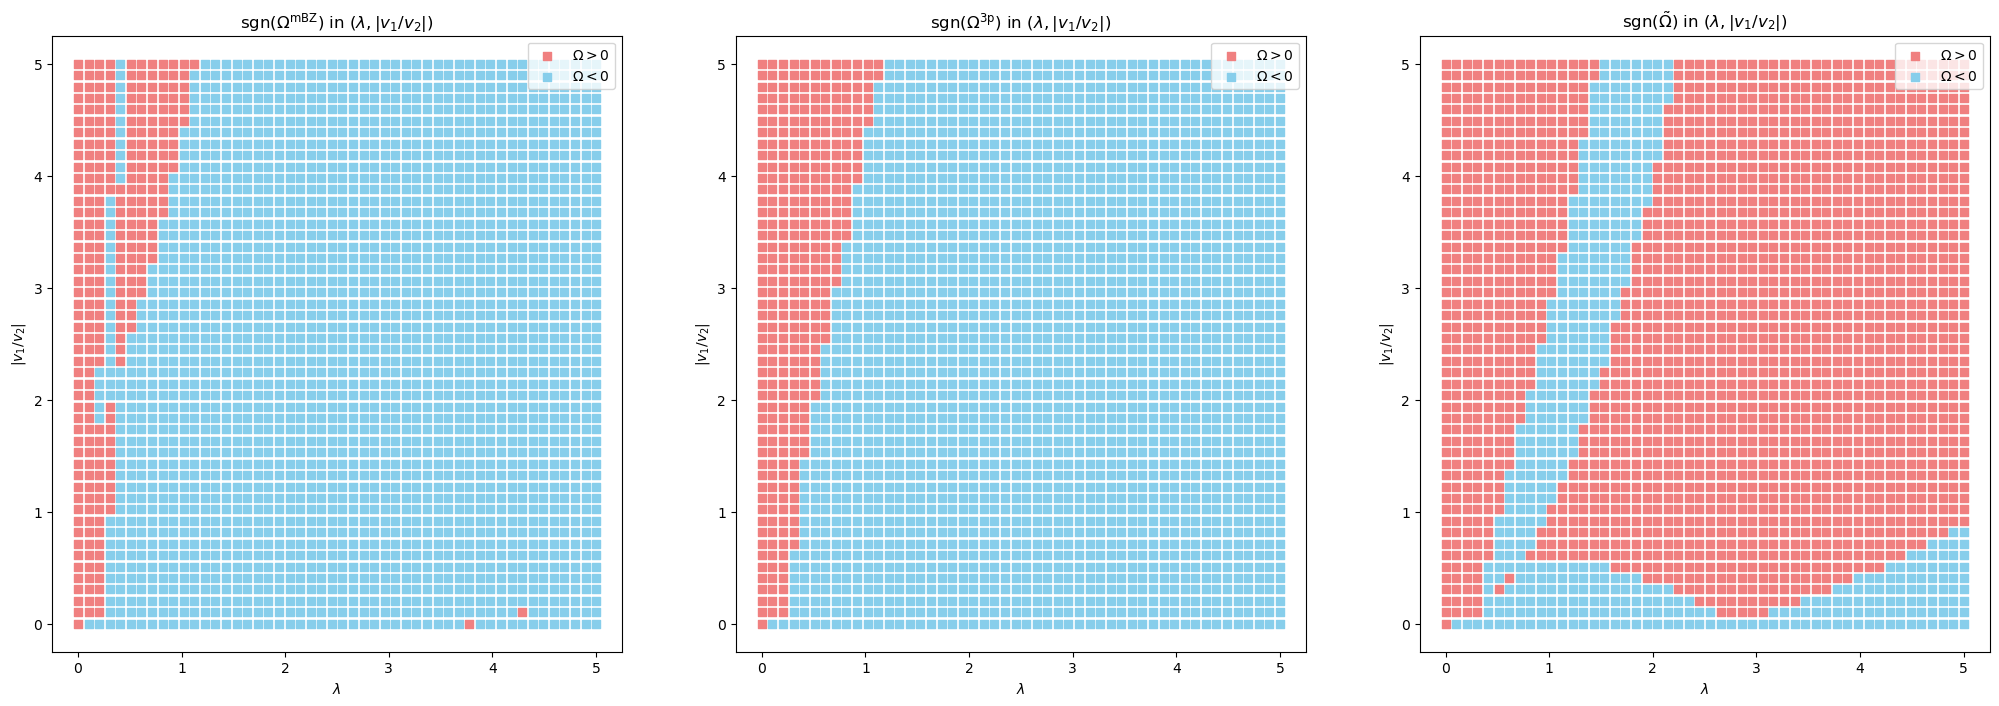

In [240]:
bc_spacing = 10^(-4)
n = 12
vF = 0.1
kappa = 1
shells = 5
q = [0, 0]
v1_sgn = 1
v2_sgn = 1
mod_lambda_all_sgn_plot(bc_spacing, n, vF, kappa, shells, q, v1_sgn, v2_sgn)

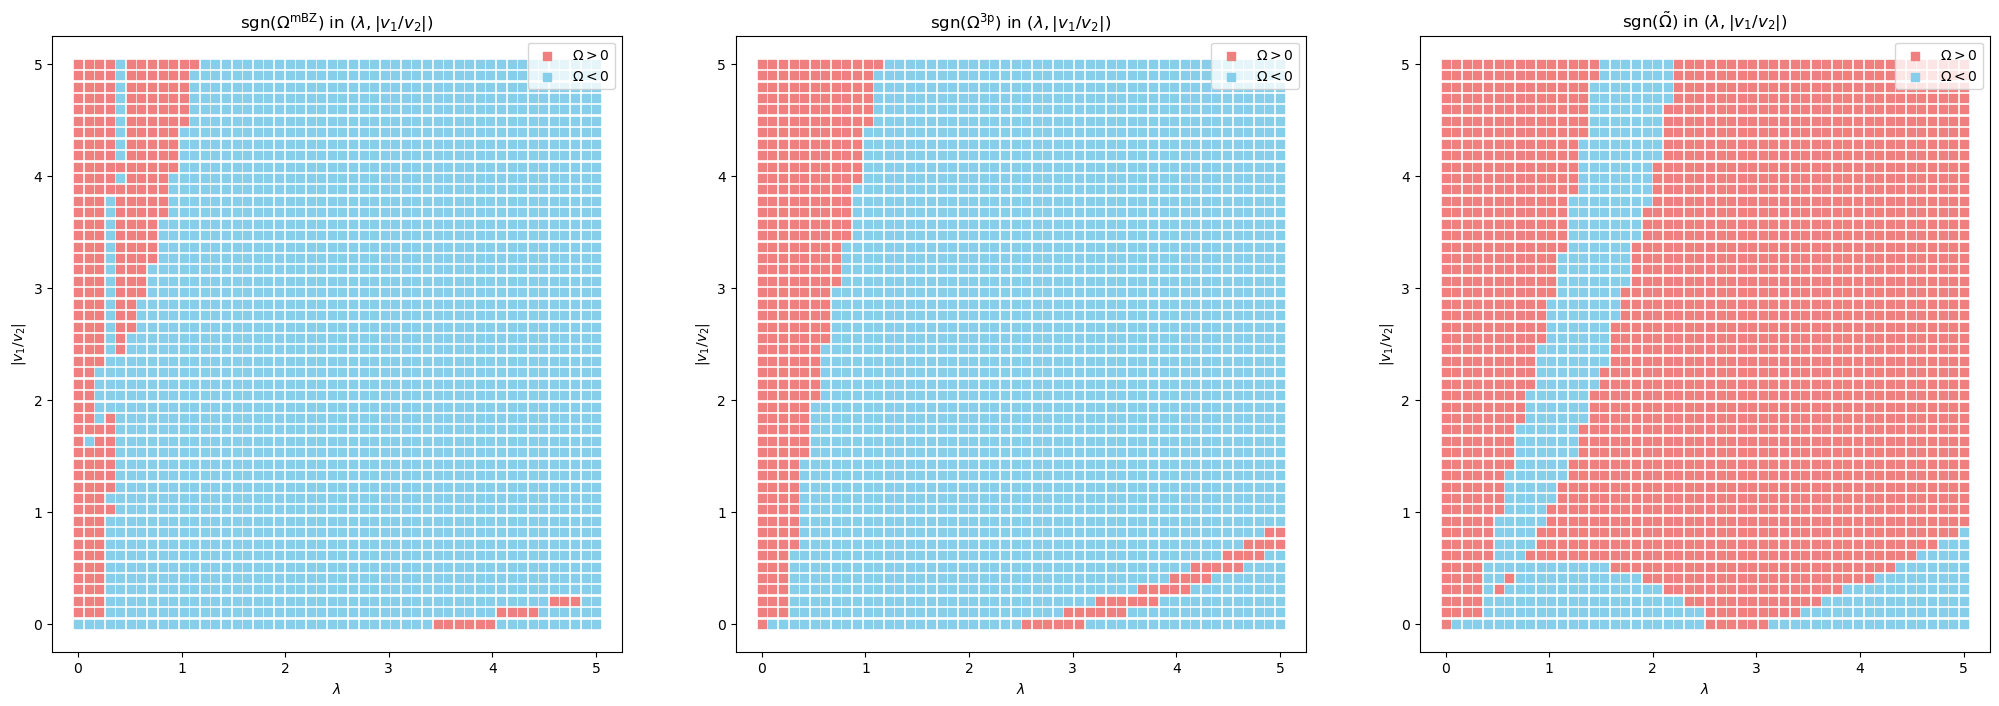

In [241]:
bc_spacing = 10^(-4)
n = 12
vF = 0.1
kappa = 1
shells = 5
q = [0.01, 0.01]
v1_sgn = 1
v2_sgn = 1
mod_lambda_all_sgn_plot(bc_spacing, n, vF, kappa, shells, q, v1_sgn, v2_sgn)

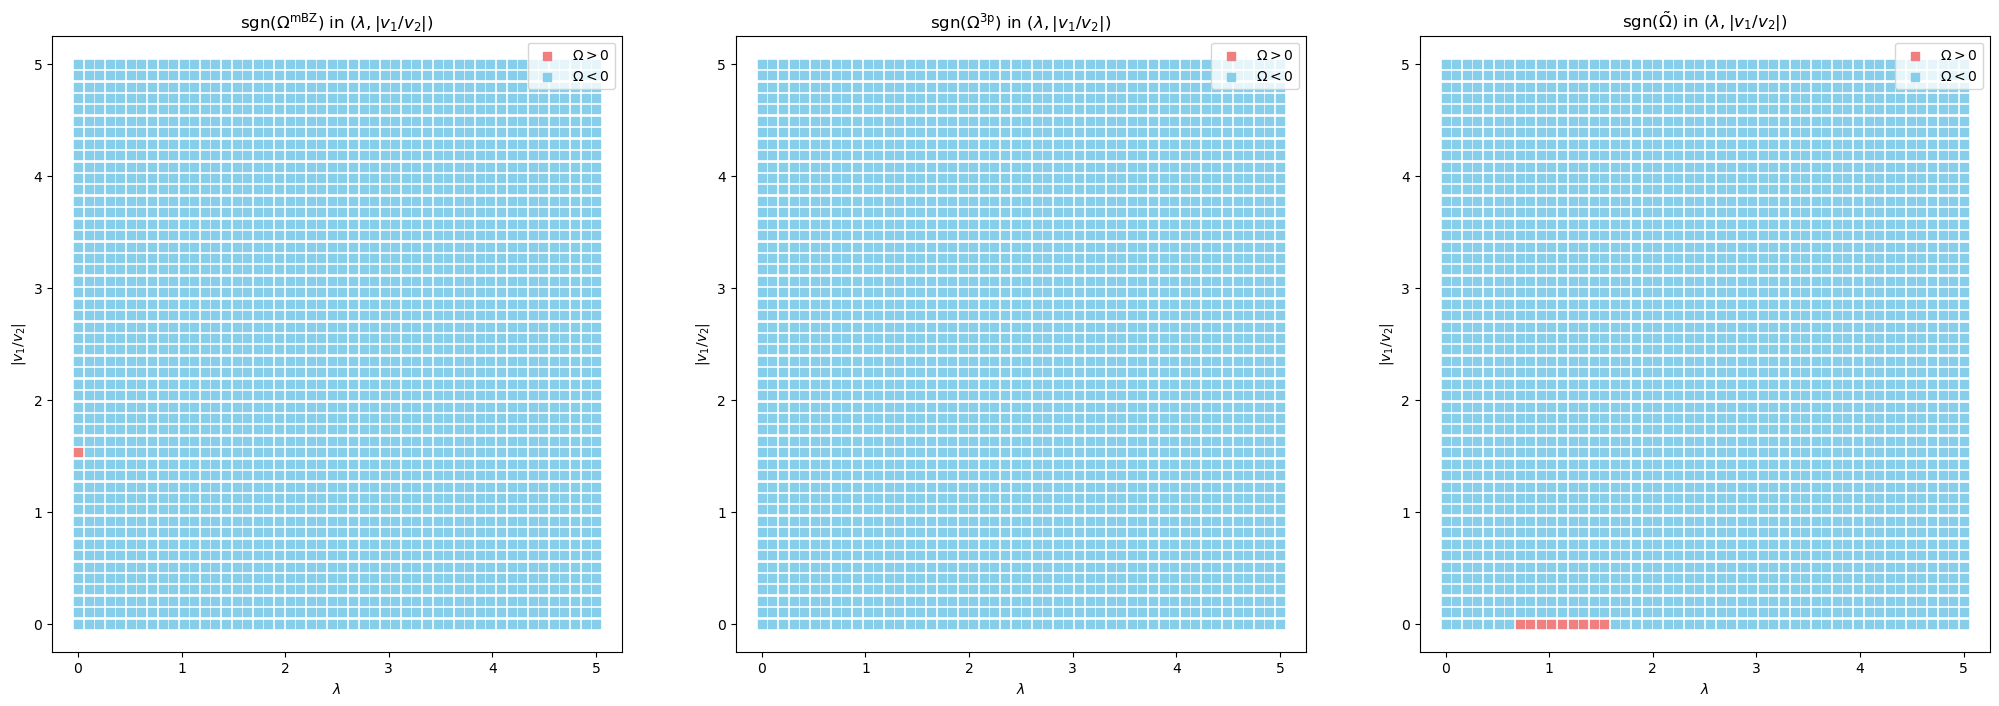

In [242]:
bc_spacing = 10^(-4)
n = 12
vF = 0.1
kappa = 1
shells = 5
q = [0, 0]
v1_sgn = 1
v2_sgn = -1
mod_lambda_all_sgn_plot(bc_spacing, n, vF, kappa, shells, q, v1_sgn, v2_sgn)

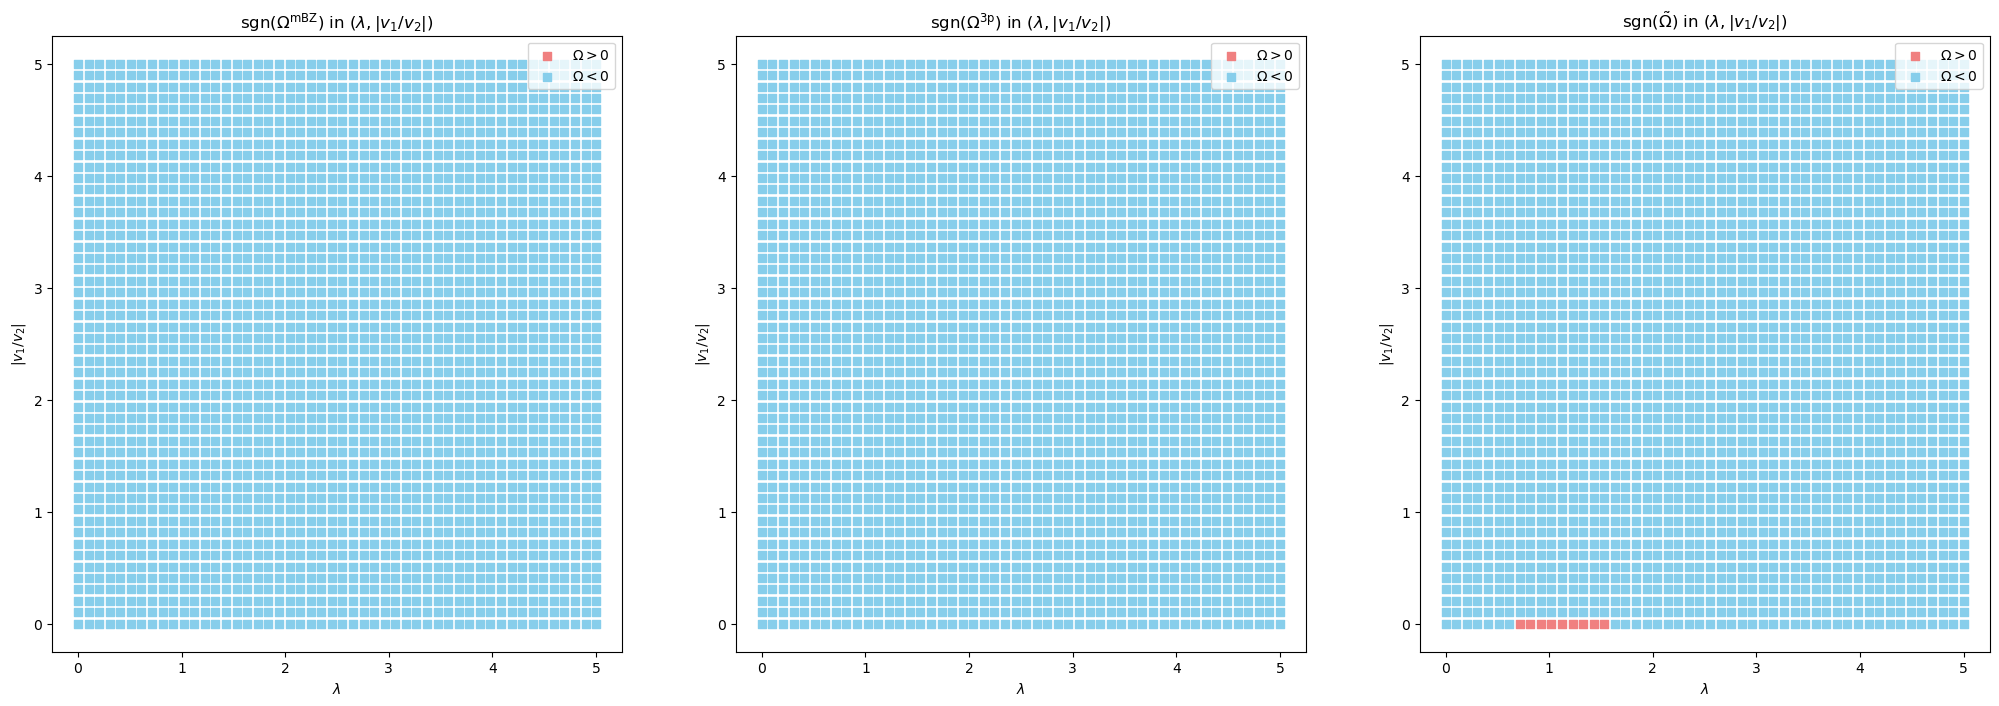

In [243]:
bc_spacing = 10^(-4)
n = 12
vF = 0.1
kappa = 1
shells = 5
q = [0.01, 0.01]
v1_sgn = 1
v2_sgn = -1
mod_lambda_all_sgn_plot(bc_spacing, n, vF, kappa, shells, q, v1_sgn, v2_sgn)

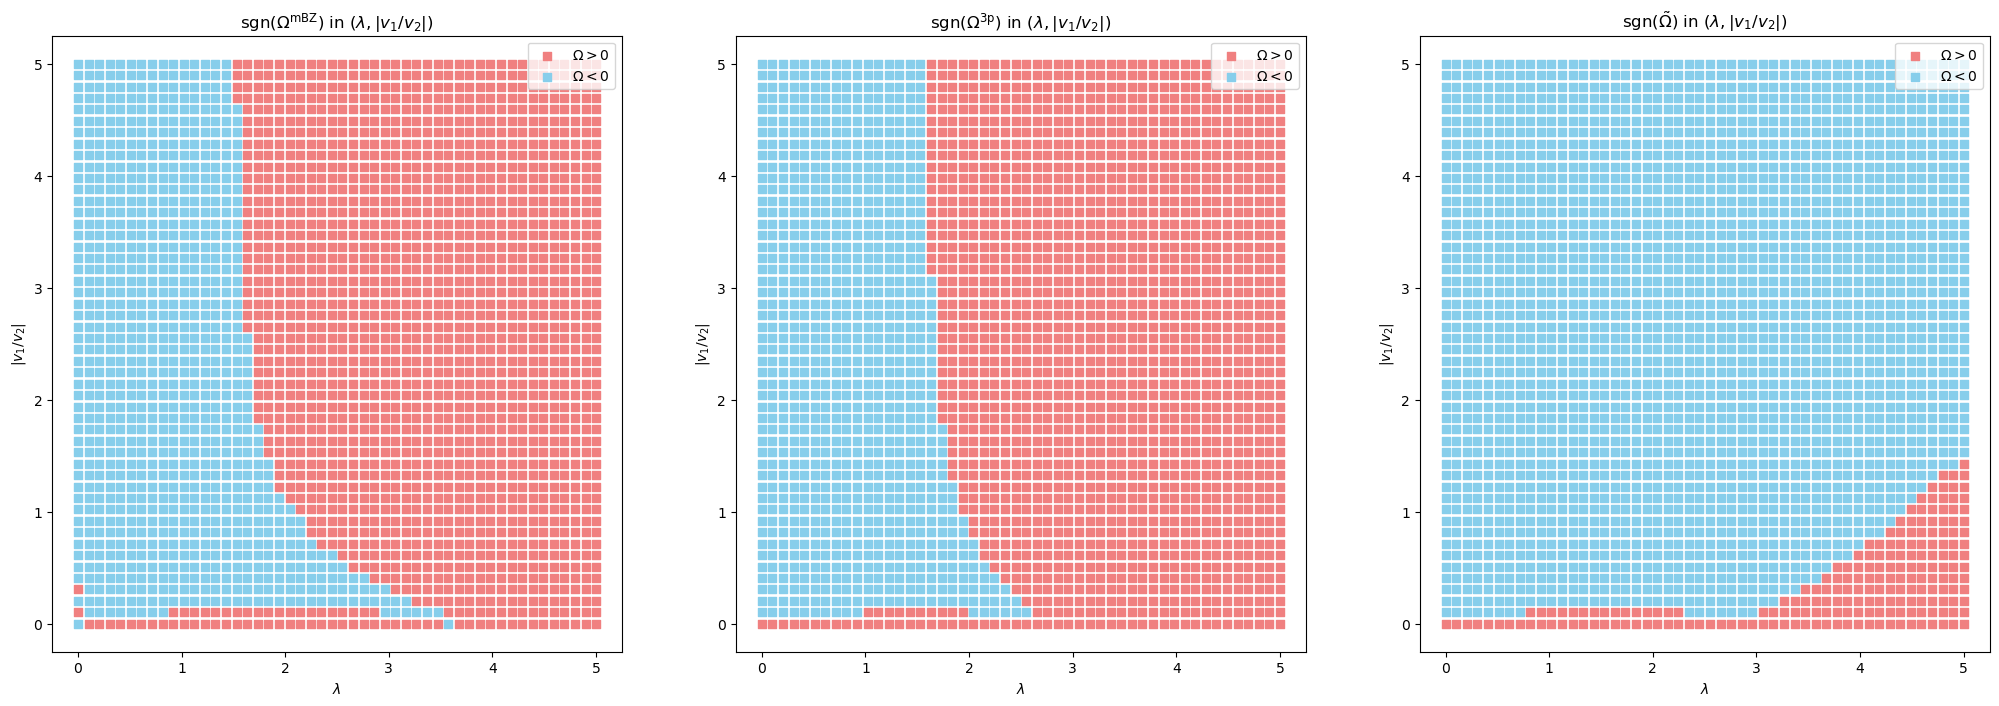

In [244]:
bc_spacing = 10^(-4)
n = 12
vF = 0.1
kappa = 1
shells = 5
q = [0, 0]
v1_sgn = -1
v2_sgn = 1
mod_lambda_all_sgn_plot(bc_spacing, n, vF, kappa, shells, q, v1_sgn, v2_sgn)

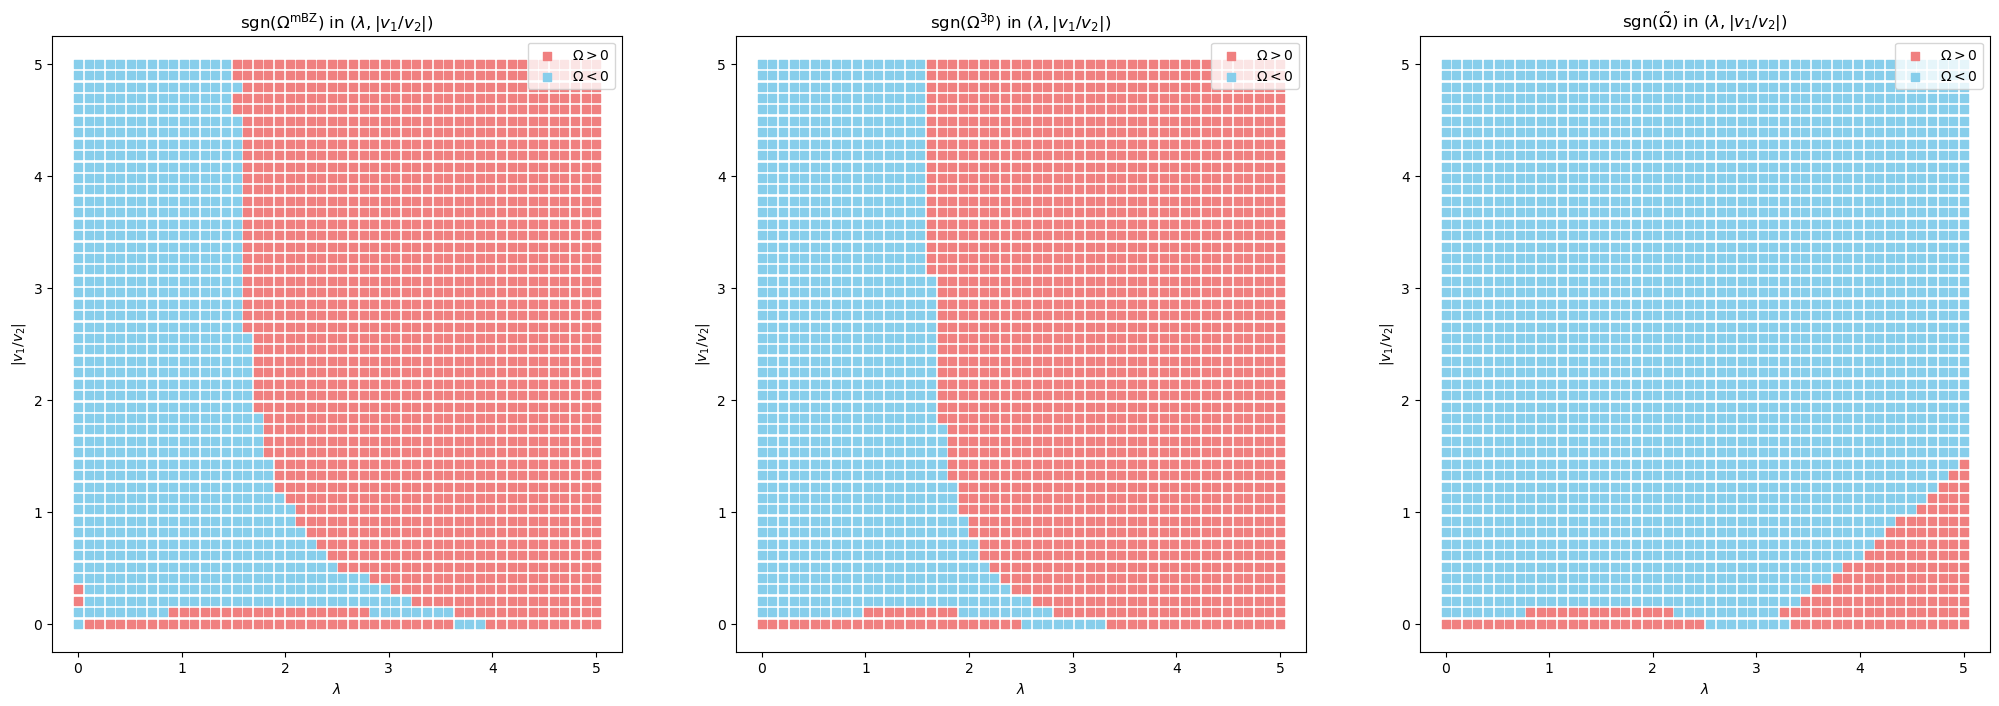

In [245]:
bc_spacing = 10^(-4)
n = 12
vF = 0.1
kappa = 1
shells = 5
q = [0.01, 0.01]
v1_sgn = -1
v2_sgn = 1
mod_lambda_all_sgn_plot(bc_spacing, n, vF, kappa, shells, q, v1_sgn, v2_sgn)

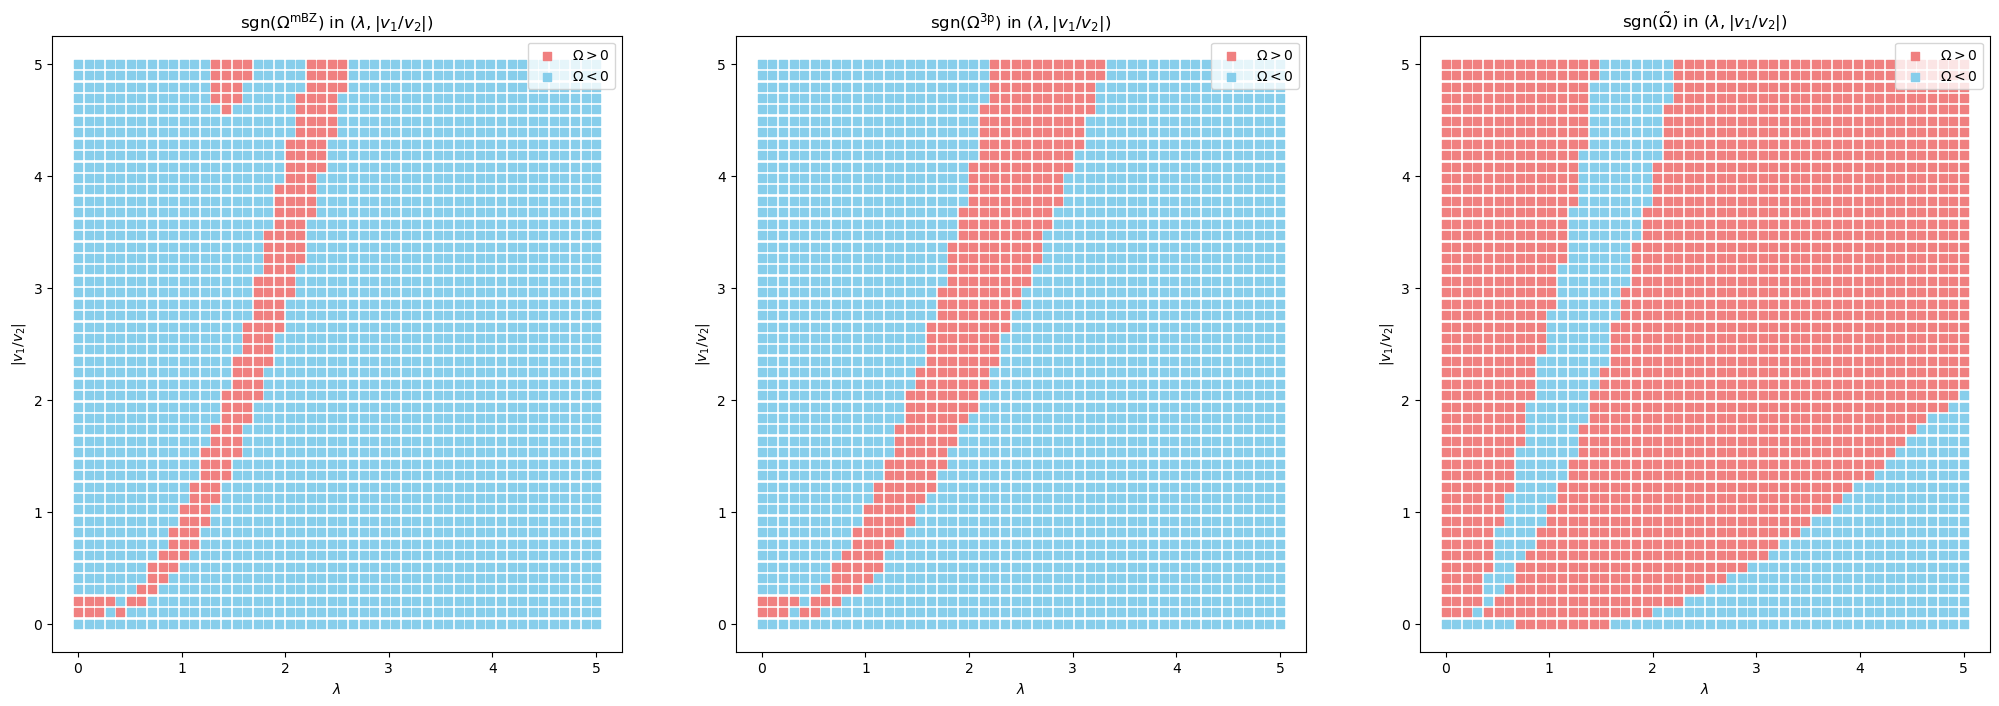

In [263]:
bc_spacing = 10^(-4)
n = 10
vF = 0.1
kappa = 1
shells = 5
q = [0, 0]
v1_sgn = -1
v2_sgn = -1
mod_lambda_all_sgn_plot(bc_spacing, n, vF, kappa, shells, q, v1_sgn, v2_sgn)

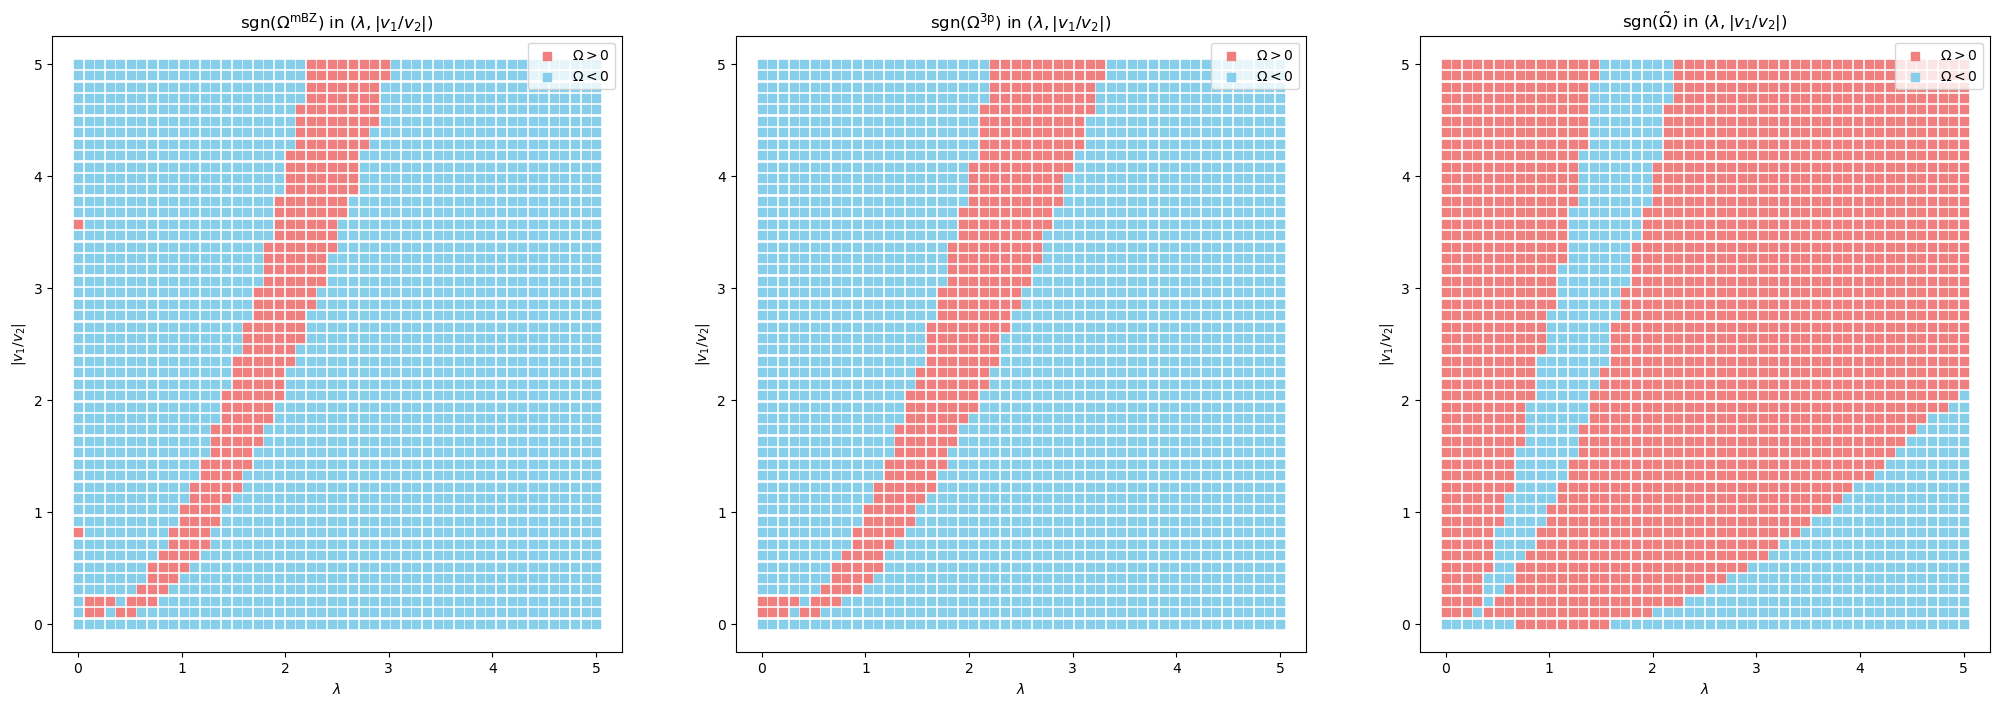

In [247]:
bc_spacing = 10^(-4)
n = 12
vF = 0.1
kappa = 1
shells = 5
q = [0.01, 0.01]
v1_sgn = -1
v2_sgn = -1
mod_lambda_all_sgn_plot(bc_spacing, n, vF, kappa, shells, q, v1_sgn, v2_sgn)

In [311]:
matplotlib.pyplot.close()

## Band flattening with $v_F$

I need to make sure that the angular momentum does indeed change and the divergent Berry curvature is smeared away.

In [17]:
# Compute Chern number over a single mBZ
function mod_mBZ_chern(lambda, n, vF, kappa, V, shells, index, grid_spacing, bc_spacing)
    num_vertices = 4
    
    mBZ_count = num_mBZ(shells)
    shell_parts = sgn_parts(shells)
    partitions = sgn_parts(shells - 1)
    part_1s = sgn_parts(1)
    dict = part_dict(shells)

    ham = zeros(ComplexF64, mBZ_count, mBZ_count)
    spinors = Array{ComplexF64}(undef, num_vertices, mBZ_count, 2)
    grounds = Array{ComplexF64}(undef, num_vertices, mBZ_count)
    # plaq_area = area(grid_spacing * sqrt(2), num_vertices)
    # area_grid_point = area(grid_spacing * sqrt(2), num_vertices)
    # plaq_area = 1
    grid_plaq_area = grid_spacing^2 * sqrt(3)/2

    g1 = kappa * sqrt(3) * [-sqrt(3)/2, 1/2]
    g2 = kappa * sqrt(3) * [0, 1]

    gi = zeros(2)
    gj = zeros(2)
    
    points = make_hex([0, 0], kappa, grid_spacing)

    bc_list = mod_grid_bc(points, lambda, n, vF, kappa, V, shells, index, bc_spacing)

    return 1/(2 * pi) * grid_plaq_area * sum(bc_list)
end

mod_mBZ_chern (generic function with 1 method)

In [18]:
# set the relevant parameters
V = [[-1, 0] [0, -1]]
n = 12
vF = 3/4
shells = 5
index = 1
kappa = 1
grid_spacing = 10^(-1)
bc_spacing = 10^(-4)

0.0001

In [19]:
lambda = 0.9995
display(mod_mBZ_chern(lambda, n, vF, kappa, V, shells, index, grid_spacing, bc_spacing))

lambda = 0.9996
display(mod_mBZ_chern(lambda, n, vF, kappa, V, shells, index, grid_spacing, bc_spacing))

49.35740775358164

10.547593602004781

In [20]:
function plot_gap_lambda(q, rs_list, kappa, V, shells, llm, ulm)
    lambda_list = range(llm, ulm, 10^2)
    gaps = Array{Float64}(undef, length(lambda_list), length(rs_list))
    for i in 1:length(lambda_list)
        lambda = lambda_list[i]
        q1 = kappa * [1, 0]
        for j in 1:length(rs_list)
            rs = rs_list[j]
            ham = lambda_ham(q1, lambda, rs, kappa, V, shells)
            vals = eigvals(Hermitian(ham))
            gaps[i, j] = log10(vals[2] - vals[1])
        end
    end
    fig, axs = plt.subplots(1,1,figsize=(15, 8))
    axs.set_xlabel(L"$\lambda$")
    axs.set_ylabel(L"$\log|\epsilon_0 - \epsilon_1|$")
    axs.set_title(L"$\log|\epsilon_0 - \epsilon_1|_{r_s} \text{ vs } \lambda$")
    for j in 1:length(rs_list)
        rs = round(rs_list[j], sigdigits=2)
        axs.plot(lambda_list, gaps[:, j], label = raw"$r_s = $" * "$rs")
    end
    axs.legend()
    fig
end

plot_gap_lambda (generic function with 1 method)

In [21]:
function mod_plot_gap_lambda(q, n, vF_list, kappa, V, shells, llm, ulm)
    lambda_list = range(llm, ulm, 10^2)
    gaps = Array{Float64}(undef, length(lambda_list), length(vF_list))
    for i in 1:length(lambda_list)
        lambda = lambda_list[i]
        q1 = kappa * [1, 0]
        for j in 1:length(vF_list)
            vF = vF_list[j]
            ham = mod_lambda_ham(q1, lambda, n, vF, kappa, V, shells)
            vals = eigvals(Hermitian(ham))
            gaps[i, j] = log10(vals[2] - vals[1])
        end
    end
    fig, axs = plt.subplots(1,1,figsize=(15, 8))
    axs.set_xlabel(L"$\lambda$")
    axs.set_ylabel(L"$\log|\epsilon_0 - \epsilon_1|$")
    axs.set_title(L"$\log|\epsilon_0 - \epsilon_1|_{n} \text{ vs } \lambda$")
    for j in 1:length(vF_list)
        vF = round(vF_list[j], sigdigits=2)
        axs.plot(lambda_list, gaps[:, j], label = raw"$v_F = $" * "$vF")
    end
    axs.legend()
    fig
end

mod_plot_gap_lambda (generic function with 1 method)

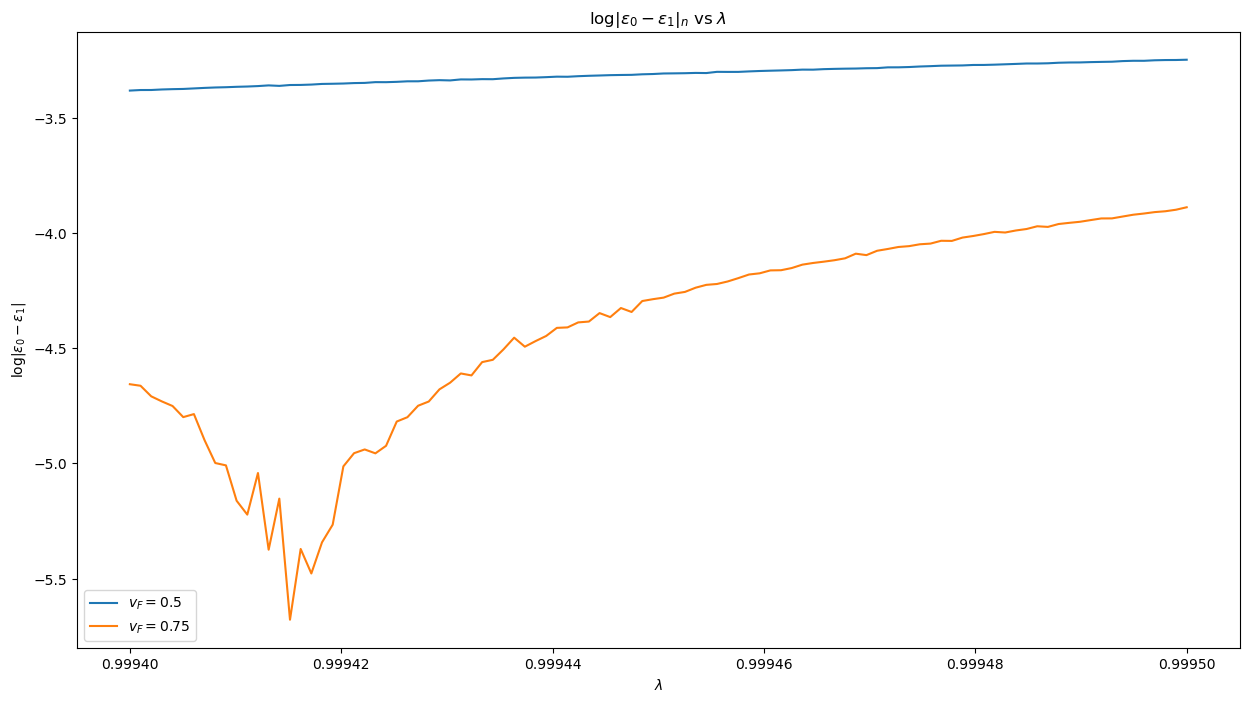

In [254]:
# set the relevant parameters
q = [0, 0]
n = 12
vF_list = [1/2, 3/4]
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
llm = 0.9994
ulm = 0.9995
mod_plot_gap_lambda(q, n, vF_list, kappa, V, shells, llm, ulm)

In [262]:
function mod_plot_gap_kx(ky, n, lambda_list, vF, kappa, V, shells, llm, ulm)
    kx_list = range(llm, ulm, 10^2)
    gaps = Array{Float64}(undef, length(kx_list), length(lambda_list))
    for i in 1:length(kx_list)
        kx = kx_list[i]
        q1 = [kx, ky]
        for j in 1:length(lambda_list)
            lambda = lambda_list[j]
            ham = mod_lambda_ham(q1, lambda, n, vF, kappa, V, shells)
            vals = eigvals(Hermitian(ham))
            gaps[i, j] = log10(vals[2] - vals[1])
        end
    end
    fig, axs = plt.subplots(1,1,figsize=(15, 8))
    axs.set_xlabel(L"$k_x$")
    axs.set_ylabel(L"$\log|\epsilon_0 - \epsilon_1|$")
    axs.set_title(L"$\log|\epsilon_0 - \epsilon_1|_{n} \text{ vs } k_x$")
    for j in 1:length(lambda_list)
        lambda = round(lambda_list[j], sigdigits=5)
        axs.plot(kx_list, gaps[:, j], label = raw"$\lambda = $" * "$lambda")
    end
    axs.legend()
    fig
end

mod_plot_gap_kx (generic function with 1 method)

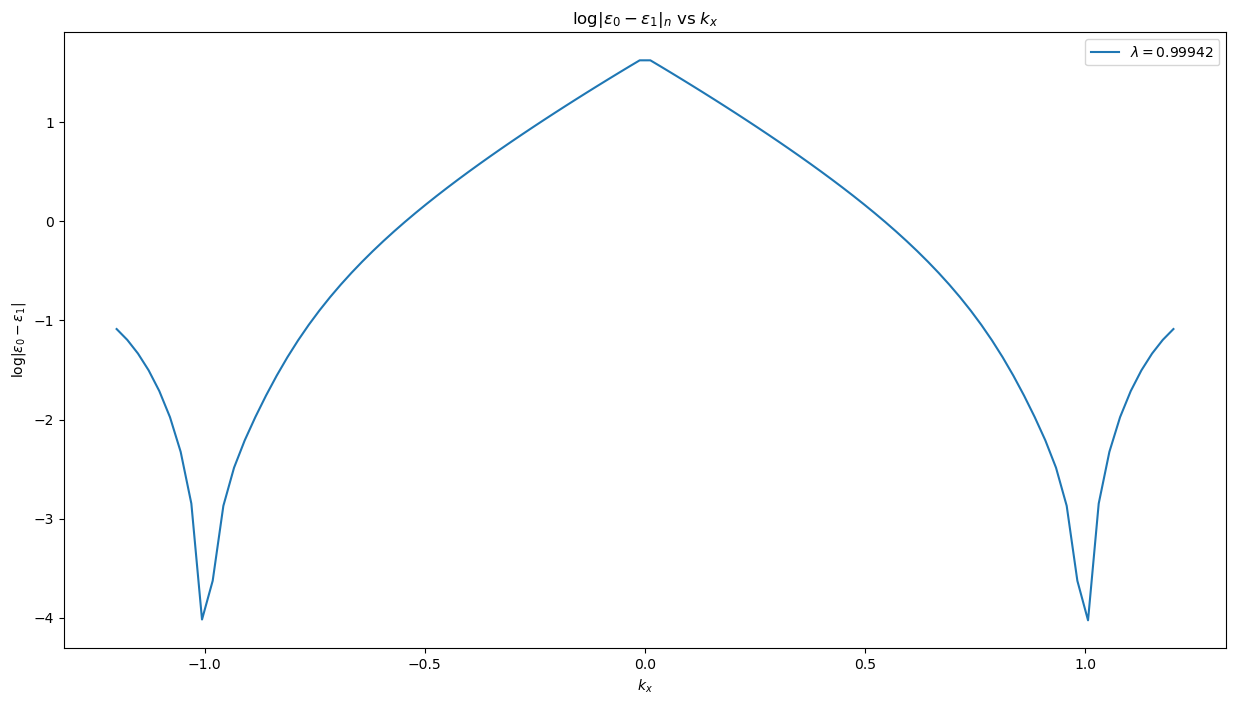

In [263]:
# set the relevant parameters
ky = 0
n = 12
lambda_list = [0.99942]
# vF = -2 * real(exp(im * 2 * pi/3) * 1/2 * lambda_alpha(kappa, 0.9, -1, -1))
vF = 3/4
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
llm = -1.2
ulm = 1.2
mod_plot_gap_kx(ky, n, lambda_list, vF, kappa, V, shells, llm, ulm)

In [ ]:
function mod_plot_gap_kx(ky, n, lambda_list, vF, kappa, V, shells, llm, ulm)
    kx_list = range(llm, ulm, 10^2)
    gaps = Array{Float64}(undef, length(kx_list), length(lambda_list))
    for i in 1:length(kx_list)
        kx = kx_list[i]
        q1 = [kx, ky]
        for j in 1:length(lambda_list)
            lambda = lambda_list[j]
            ham = mod_lambda_ham(q1, lambda, n, vF, kappa, V, shells)
            vals = eigvals(Hermitian(ham))
            gaps[i, j] = log10(vals[2] - vals[1])
        end
    end
    fig, axs = plt.subplots(1,1,figsize=(15, 8))
    axs.set_xlabel(L"$k_x$")
    axs.set_ylabel(L"$\log|\epsilon_0 - \epsilon_1|$")
    axs.set_title(L"$\log|\epsilon_0 - \epsilon_1|_{n} \text{ vs } k_x$")
    for j in 1:length(lambda_list)
        lambda = round(lambda_list[j], sigdigits=5)
        axs.plot(kx_list, gaps[:, j], label = raw"$\lambda = $" * "$lambda")
    end
    axs.legend()
    fig
end

## Energy line cuts

In [16]:
function mod_plot_energy_line(lambda, n, vF, kappa, V, shells, spacing, ky, llm, ulm)
    n_pts = 10^2

    kx_list = range(llm, ulm, n_pts)

    energies = Array{Float64}(undef, n_pts, 3)

    for j in 1:(n_pts)
        k = [kx_list[j], ky]
        ham = mod_lambda_ham(k, lambda, n, vF, kappa, V, shells)
        ham1 = mod_lambda_ham(k, lambda, n, vF, kappa, 0 * V, shells)
        energies[j, 1] = eigvals(Hermitian(ham))[1]
        energies[j, 2] = eigvals(Hermitian(ham))[2]
    end

    fig, axs = plt.subplots(1,figsize=(12, 8))
    axs.set_xlabel(L"$k_x$")
    axs.set_ylabel(L"$\epsilon$")
    axs.plot(kx_list, energies[:, 1], label = L"\epsilon_0")
    axs.plot(kx_list, energies[:, 2], label = L"\epsilon_1")
    axs.legend()
    fig.tight_layout()
    
    fig
end

mod_plot_energy_line (generic function with 1 method)

In [80]:
-1/2*abs(lambda_delta(kappa, lambda, V[1, 1], V[2, 2]))

-0.25000000374962505

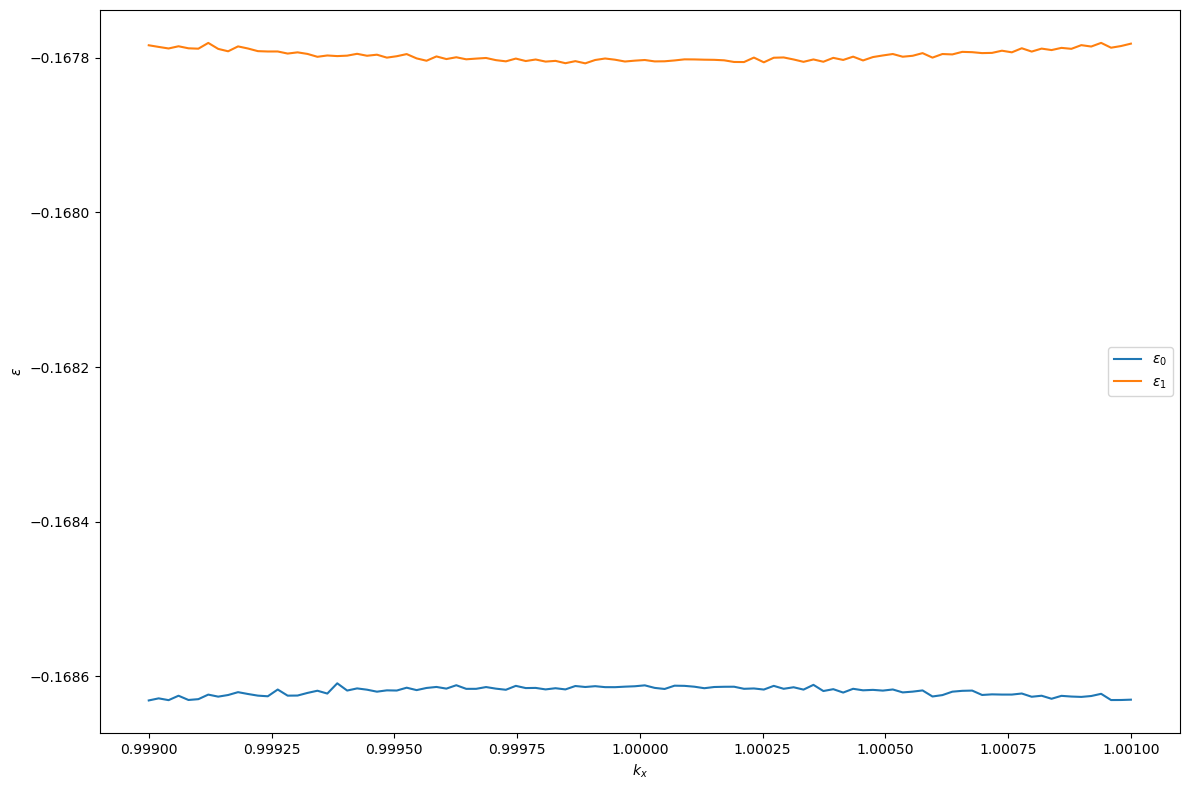

In [76]:
# set the relevant parameters
lambda = 1.0001
n = 12
vF = 1
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
bc_spacing = 10^(-4)
ky = 0
llm = 0.999
ulm = 1.001
mod_plot_energy_line(lambda, n, vF, kappa, V, shells, bc_spacing, ky, llm, ulm)

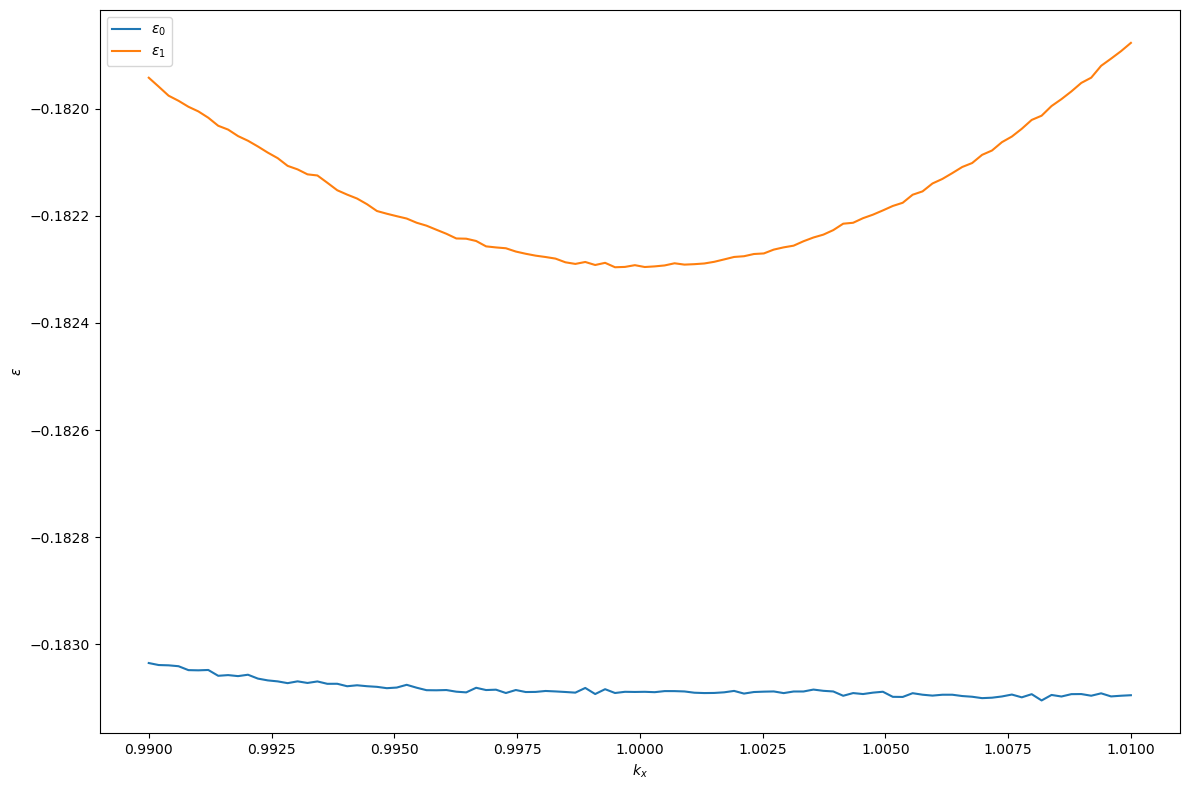

In [349]:
# set the relevant parameters
lambda = 1
n = 12
vF = 3/4+0.08
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
bc_spacing = 10^(-4)
ky = 0
llm = 0.99
ulm = 1.01
mod_plot_energy_line(lambda, n, vF, kappa, V, shells, bc_spacing, ky, llm, ulm)

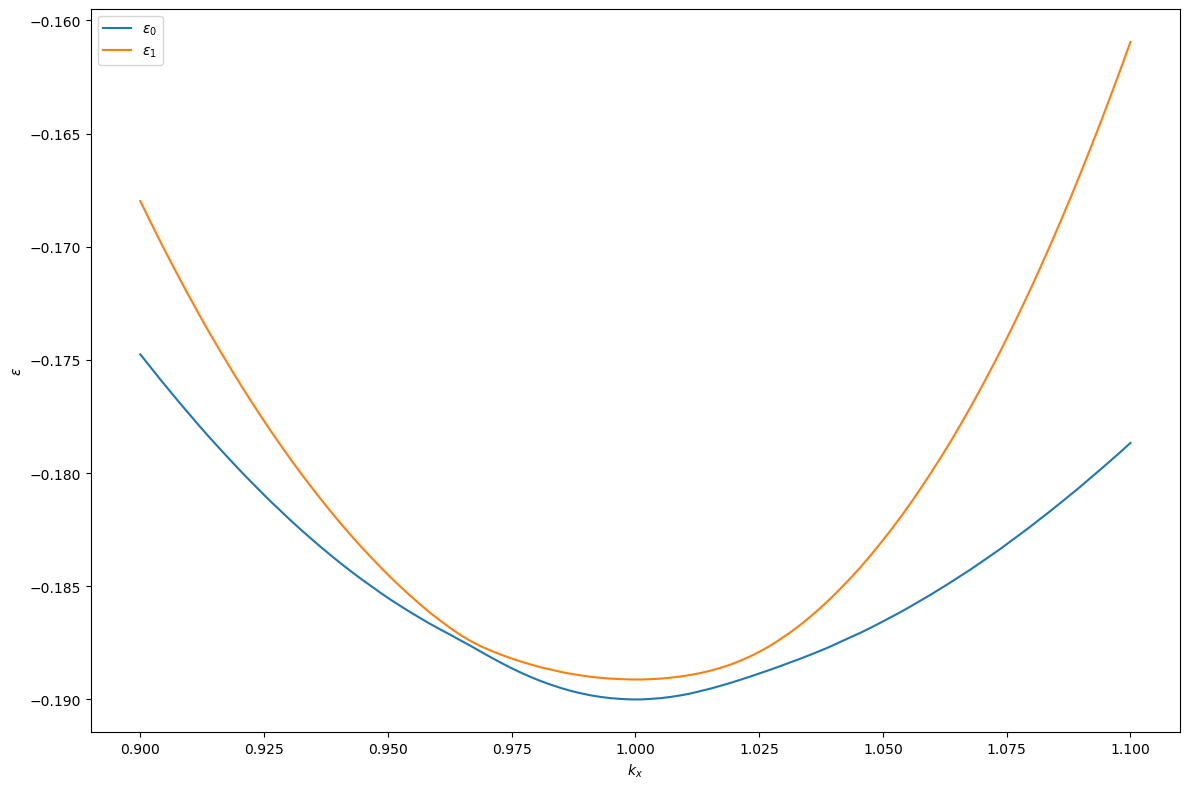

In [379]:
# set the relevant parameters
lambda = 1
n = 12
vF = 3/4
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
bc_spacing = 10^(-4)
ky = 0
llm = 0.9
ulm = 1.1
mod_plot_energy_line(lambda, n, vF, kappa, V, shells, bc_spacing, ky, llm, ulm)

In [47]:
function mod_plot_eg_kx(ky, n, lambda, vF_list, kappa, V, shells, llm, ulm, index)
    kx_list = range(llm, ulm, 10^2)
    gaps = Array{Float64}(undef, length(kx_list), length(vF_list))
    for i in 1:length(kx_list)
        kx = kx_list[i]
        q1 = [kx, ky]
        for j in 1:length(vF_list)
            vF = vF_list[j]
            ham = mod_lambda_ham(q1, lambda, n, vF, kappa, V, shells)
            vals = eigvals(Hermitian(ham))
            gaps[i, j] = vals[index]
        end
    end
    fig, axs = plt.subplots(1,1,figsize=(15, 8))
    axs.set_xlabel(L"$k_x$")
    axs.set_ylabel(L"$\epsilon$")
    axs.set_title(L"$\epsilon \text{ vs } k_x$")
    for j in 1:length(vF_list)
        vF = round(vF_list[j], sigdigits=5)
        axs.plot(kx_list, gaps[:, j], label = raw"$v_F = $" * "$vF")
    end
    axs.legend()

    fig.tight_layout()
    
    fig
end

mod_plot_eg_kx (generic function with 1 method)

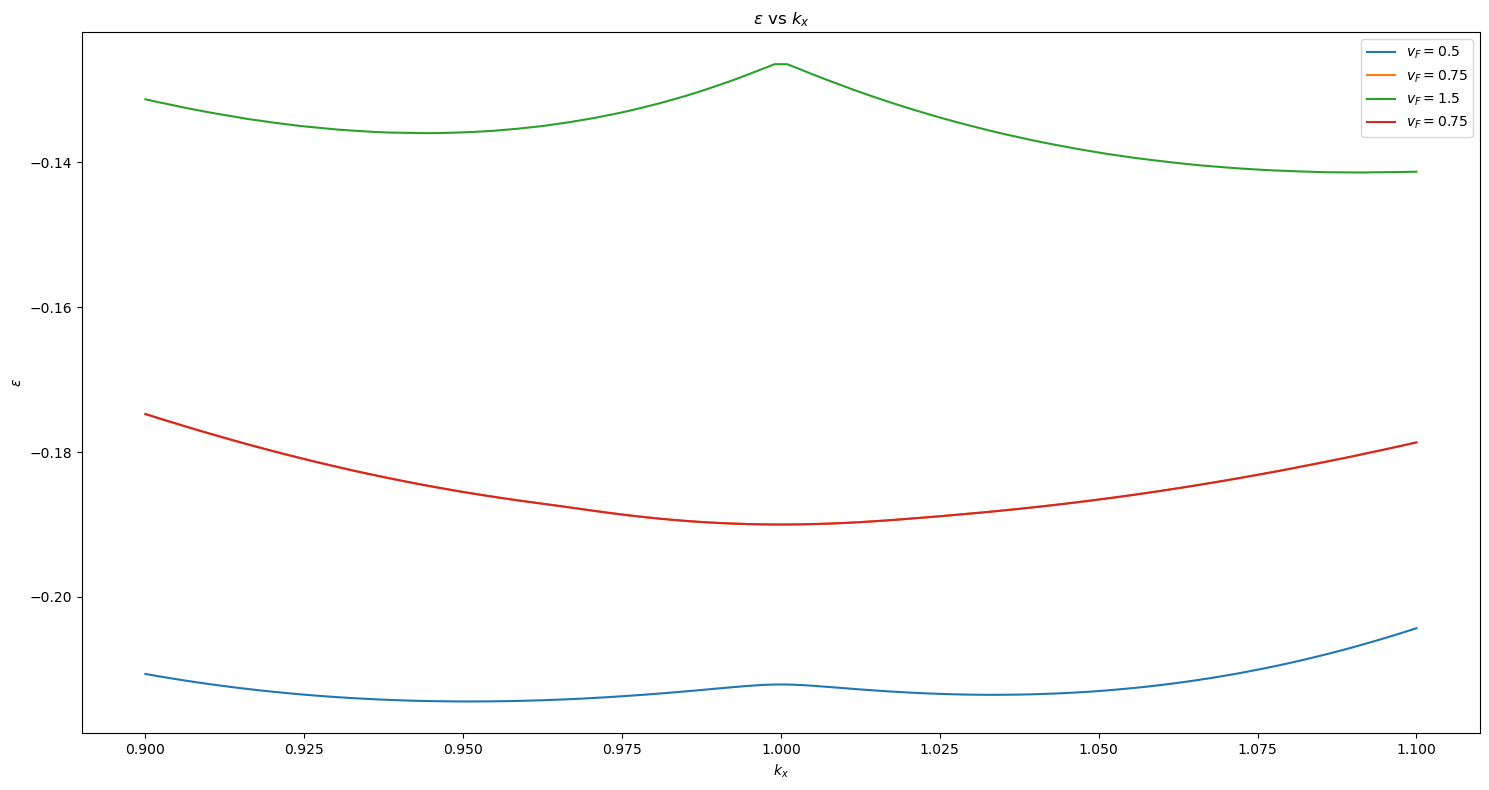

In [51]:
# set the relevant parameters
lambda = 1
n = 12
vF_list = [1/2, 3/4, 3/2, -2 * real(exp(im * 2 * pi/3) * 1/2 * lambda_alpha(kappa, lambda, V[1, 1], V[2, 2]))]
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
bc_spacing = 10^(-4)
ky = 0
llm = 0.9
ulm = 1.1
index = 1
mod_plot_eg_kx(ky, n, lambda, vF_list, kappa, V, shells, llm, ulm, index)

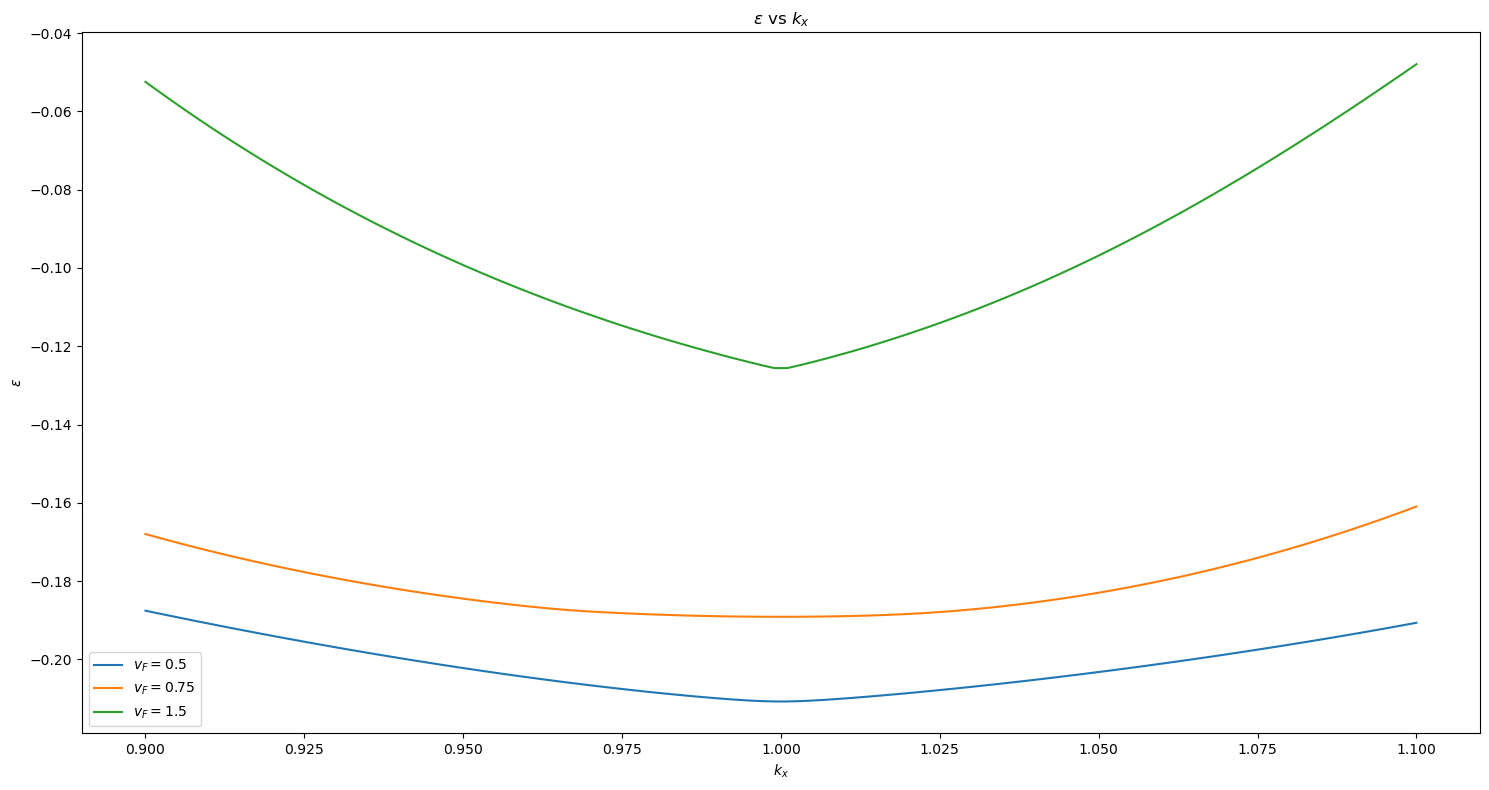

In [415]:
# set the relevant parameters
lambda = 1
n = 12
vF_list = [1/2, 3/4, 3/2]
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
bc_spacing = 10^(-4)
ky = 0
llm = 0.9
ulm = 1.1
index = 2
mod_plot_eg_kx(ky, n, lambda, vF_list, kappa, V, shells, llm, ulm, index)

## Energy angular cuts

In [337]:
function mod_plot_energy_ang(lambda, n, vF, kappa, V, shells, spacing, mag)
    n_pts = 10^2

    ang_list = range(-pi, pi, n_pts)

    energies = Array{Float64}(undef, n_pts, 3)

    for j in 1:(n_pts)
        k = mag * [cos(ang_list[j]), sin(ang_list[j])]
        ham = mod_lambda_ham(k, lambda, n, vF, kappa, V, shells)
        ham1 = mod_lambda_ham(k, lambda, n, vF, kappa, 0 * V, shells)
        energies[j, 1] = eigvals(Hermitian(ham))[1]
        energies[j, 2] = eigvals(Hermitian(ham))[2]
    end

    fig, axs = plt.subplots(1,figsize=(12, 8))
    axs.set_xlabel(L"$\theta/ \pi$")
    axs.set_ylabel(L"$\epsilon$")
    axs.plot(ang_list/pi, energies[:, 1], label = L"\epsilon_0")
    axs.plot(ang_list/pi, energies[:, 2], label = L"\epsilon_1")
    axs.legend()
    fig.tight_layout()
    
    fig
end

mod_plot_energy_ang (generic function with 1 method)

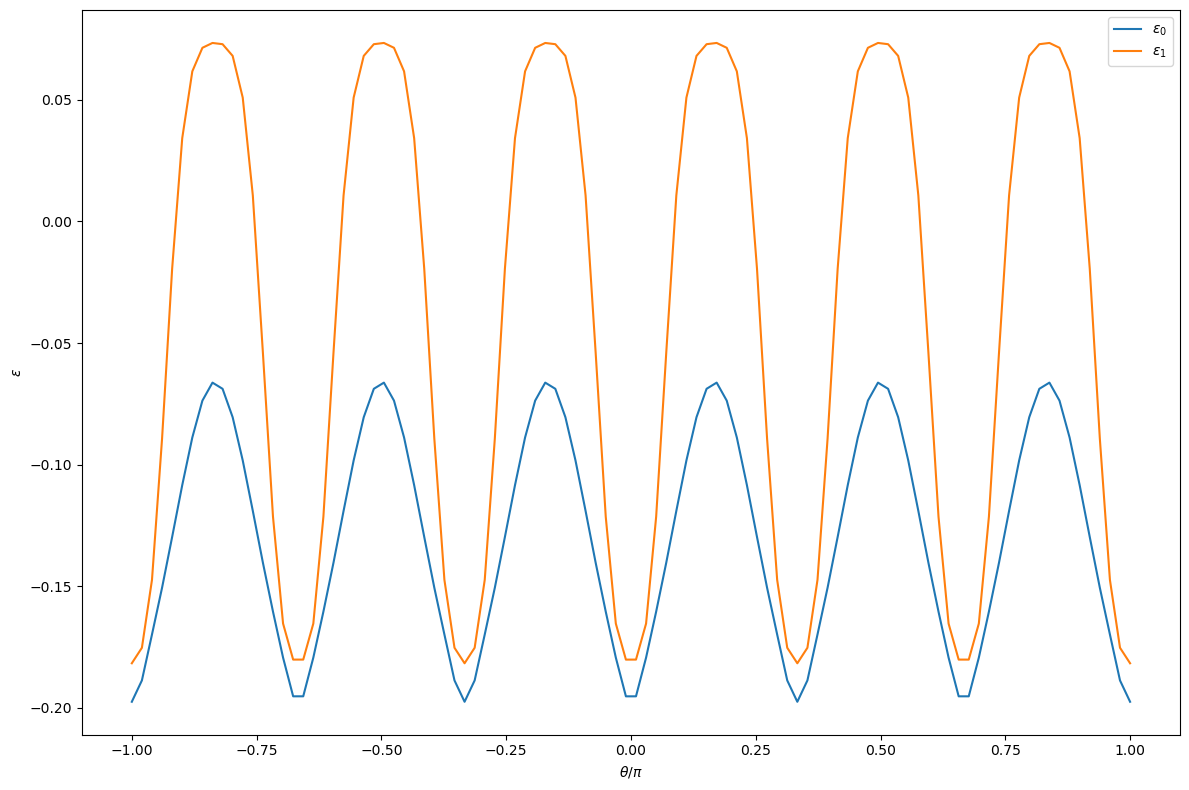

In [338]:
# set the relevant parameters
lambda = 1.01
n = 12
vF = 3/4
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
bc_spacing = 10^(-4)
mag = 1 * kappa
mod_plot_energy_ang(lambda, n, vF, kappa, V, shells, bc_spacing, mag)

## Energy Contours

In [451]:
function plot_energy(lambda, rs, kappa, V, shells, index, spacing)
    n_pts = 10^2

    k_list = range(-kappa, kappa, n_pts)
    grid = mesh_grid(k_list, k_list, Float64)
    # kx_list = kappa * range(0.9, 1.1, n_pts)
    # ky_list = range(-0.1, 0.1, n_pts)
    # grid = mesh_grid(kx_list, ky_list, Float64)

    energy_list = Array{Float64}(undef, n_pts * n_pts)

    for j in 1:(n_pts * n_pts)
        k = grid[j, :]
        ham = lambda_ham(k, lambda, rs, kappa, V, shells)
        energy_list[j] = eigvals(Hermitian(ham))[index]
    end

    grid_new = reshape(grid, (n_pts, n_pts, 2))
    energies = reshape(energy_list, (n_pts, n_pts))

    eg_min = minimum(energies)
    eg_max = maximum(energies)
    eg_abs = maximum(abs.([eg_min, eg_max]))

    figure()
    xlabel(L"k_x")
    ylabel(L"k_y")
    title(L"\epsilon(k_x, k_y) \text{ vs } (k_x, k_y)")
    pcolormesh(grid_new[:, :, 1], grid_new[:, :, 2], energies, cmap="RdBu", vmin = -eg_abs, vmax = eg_abs)
    colorbar()
    display(gcf())
end
function mod_plot_energy(lambda, n, vF, kappa, V, shells, spacing, index)
    n_pts = 10^2

    # k_list = range(-kappa, kappa, n_pts)
    # grid = mesh_grid(k_list, k_list, Float64)
    shift = 0.1
    kx_list = range(kappa - shift, kappa + shift, n_pts)
    ky_list = shift * range(-1, 1, n_pts)
    grid = mesh_grid(kx_list, ky_list, Float64)

    energy_list = Array{Float64}(undef, n_pts * n_pts, 3)

    for j in 1:(n_pts * n_pts)
        k = grid[j, :]
        ham = mod_lambda_ham(k, lambda, n, vF, kappa, V, shells)
        energy_list[j, 1] = eigvals(Hermitian(ham))[index]
        # energy_list[j, 2] = eigvals(Hermitian(ham))[2]
        # energy_list[j, 3] = energy_list[j, 2] - energy_list[j, 1]
    end

    grid_new = reshape(grid, (n_pts, n_pts, 2))
    energies = reshape(energy_list, (n_pts, n_pts, 3))

    # eg_min1 = minimum(energies[:, :, 1])
    # eg_max1 = maximum(energies[:, :, 1])
    # eg_abs1 = maximum(abs.([eg_min1, eg_max1]))

    # eg_min2 = minimum(energies[:, :, 2])
    # eg_max2 = maximum(energies[:, :, 2])
    # eg_abs2 = maximum(abs.([eg_min2, eg_max2]))

    # eg_min3 = minimum(energies[:, :, 3])
    # eg_max3 = maximum(energies[:, :, 3])
    # eg_abs3 = maximum(abs.([eg_min3, eg_max3]))

    fig, axs = plt.subplots(1, 1, figsize=(10, 6))
    axs.set_xlabel(L"$k_x$")
    axs.set_ylabel(L"$k_y$")
    axs.set_title(L"$\epsilon$")
    plt1 = axs.pcolormesh(grid_new[:, :, 1], grid_new[:, :, 2], energies[:, :, 1], cmap="RdBu")
    fig.colorbar(plt1, ax=axs)
    fig.tight_layout()

    fig

    # fig, axs = plt.subplots(1,3,figsize=(30, 10))

    # axs[1].set_xlabel(L"$k_x$")
    # axs[2].set_xlabel(L"$k_x$")
    # axs[3].set_xlabel(L"$k_x$")

    # axs[1].set_ylabel(L"$k_y$")
    # axs[2].set_ylabel(L"$k_y$")
    # axs[3].set_ylabel(L"$k_y$")

    # axs[1].set_title(L"$\epsilon_0 \text{ vs } (k_x, k_y)$")
    # axs[2].set_title(L"$\epsilon_1 \text{ vs } (k_x, k_y)$")
    # axs[3].set_title(L"$\epsilon_1 - \epsilon_0 \text{ vs } (k_x, k_y)$")

    # plt1 = axs[1].pcolormesh(grid_new[:, :, 1], grid_new[:, :, 2], energies[:, :, 1], cmap="RdBu", vmin = -eg_abs1, vmax = eg_abs1)
    # fig.colorbar(plt1, ax=axs[1])

    # plt2 = axs[2].pcolormesh(grid_new[:, :, 1], grid_new[:, :, 2], energies[:, :, 2], cmap="RdBu", vmin = -eg_abs2, vmax = eg_abs2)
    # fig.colorbar(plt2, ax=axs[2])

    # plt3 = axs[3].pcolormesh(grid_new[:, :, 1], grid_new[:, :, 2], energies[:, :, 3], cmap="RdBu", vmin = -eg_abs3, vmax = eg_abs3)
    # fig.colorbar(plt3, ax=axs[3])

    # fig.tight_layout()
    
    # fig
end

mod_plot_energy (generic function with 2 methods)

In [446]:
# band does not flatten
k1 = [1, 0]
lambda = 1
n = 12
vF = 3/4 + 0.08
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
ham1 = mod_lambda_ham(k1, lambda, n, vF, kappa, V, shells)
vals1 = eigvals(Hermitian(ham1))

k2 = [1.01, 0]
lambda = 1
n = 12
vF = 3/4 + 0.08
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
ham2 = mod_lambda_ham(k2, lambda, n, vF, kappa, V, shells)
vals2 = eigvals(Hermitian(ham2))
display(minimum(abs.(vals2 - vals1)))

7.36027790110283e-6

In [431]:
# 3-patch flat band
vF = 3/4
delta = 1/2 * lambda_delta(kappa, lambda, -1, -1)
alpha = 1/2 * lambda_alpha(kappa, lambda, -1, -1)

ham1 = H_k_v2(k1, vF) + H_mft_v2(k1, delta, alpha)
vals1 = eigvals(Hermitian(ham1))

ham2 = H_k_v2(k2, vF) + H_mft_v2(k2, delta, alpha)
vals2 = eigvals(Hermitian(ham2))

display(minimum(abs.(vals2 - vals1)))

3.3306690738754696e-16

In [254]:
function mod_plot_energy_surface(lambda, n, vF, kappa, V, shells, spacing)
    n_pts = 10^2

    # k_list = range(-kappa, kappa, n_pts)
    # grid = mesh_grid(k_list, k_list, Float64)
    shift = 0.1
    kx_list = range(kappa - shift, kappa + shift, n_pts)
    ky_list = shift * range(-1, 1, n_pts)
    grid = mesh_grid(kx_list, ky_list, Float64)

    energy_list = Array{Float64}(undef, n_pts * n_pts, 3)

    for j in 1:(n_pts * n_pts)
        k = grid[j, :]
        ham = mod_lambda_ham(k, lambda, n, vF, kappa, V, shells)
        energy_list[j, 1] = eigvals(Hermitian(ham))[1]
        energy_list[j, 2] = eigvals(Hermitian(ham))[2]
        energy_list[j, 3] = energy_list[j, 2] - energy_list[j, 1]
    end

    grid_new = reshape(grid, (n_pts, n_pts, 2))
    energies = reshape(energy_list, (n_pts, n_pts, 3))

    fig = plt.figure()
    ax = fig.add_subplot(projection="3d")

    surf = ax.plot_surface(grid_new[:, :, 1], grid_new[:, :, 2], energies[:, :, 2], cmap="RdBu",
    linewidth=0, antialiased=false)

    # Add a color bar which maps values to colors.
    fig.colorbar(surf, shrink=0.5, aspect=5)
    fig.tight_layout()

    fig
end

mod_plot_energy_surface (generic function with 1 method)

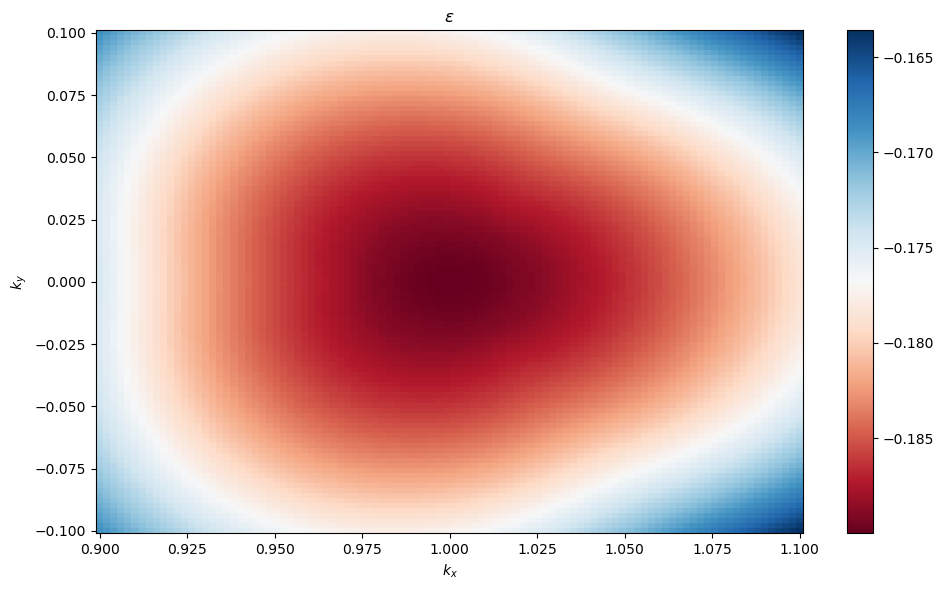

In [452]:
lambda = 1
n = 12
vF = 3/4
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
spacing = 10^(-4)
index = 1
mod_plot_energy(lambda, n, vF, kappa, V, shells, spacing, index)

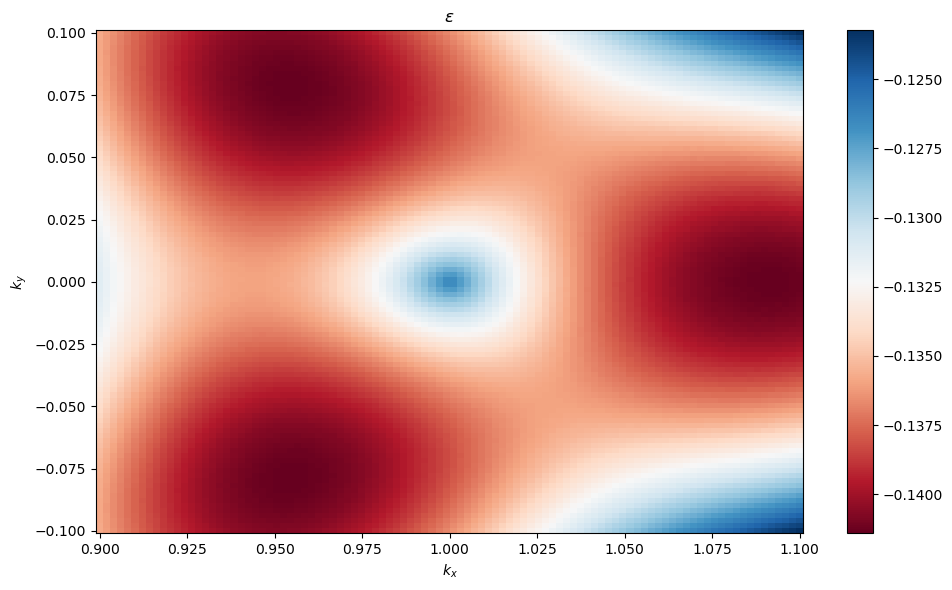

In [453]:
lambda = 1
n = 12
vF = 3/2
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
spacing = 10^(-4)
index = 1
mod_plot_energy(lambda, n, vF, kappa, V, shells, spacing, index)

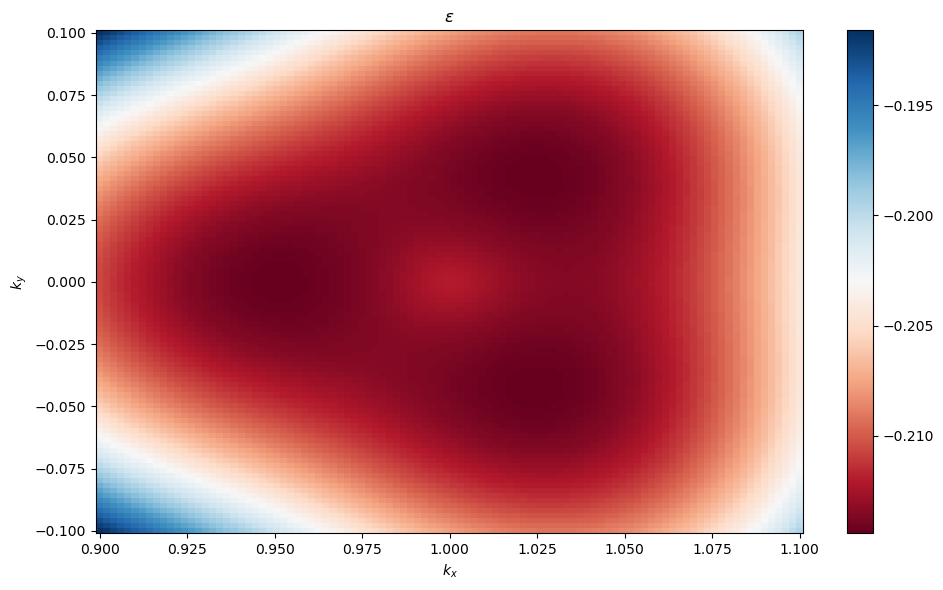

In [586]:
lambda = 1
n = 12
vF = 2/4
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
spacing = 10^(-4)
index = 1
mod_plot_energy(lambda, n, vF, kappa, V, shells, spacing, index)

## Energy line cuts

In [341]:
function mod_plot_energy_line(lambda, n, vF, kappa, V, shells, spacing, ky)
    n_pts = 10^2

    # k_list = range(-kappa, kappa, n_pts)
    # grid = mesh_grid(k_list, k_list, Float64)
    kx_list = range(kappa - 0.01, kappa + 0.01, n_pts)
    #ky_list = shift * range(-1, 1, n_pts)
    #grid = mesh_grid(kx_list, ky_list, Float64)

    energies = Array{Float64}(undef, n_pts, 3)

    for j in 1:(n_pts)
        k = [kx_list[j], ky]
        ham = mod_lambda_ham(k, lambda, n, vF, kappa, V, shells)
        ham1 = mod_lambda_ham(k, lambda, n, vF, kappa, 0 * V, shells)
        # energies[j, 1] = eigvals(Hermitian(ham))[1] - eigvals(Hermitian(ham1))[1]
        # energies[j, 2] = eigvals(Hermitian(ham))[2] - eigvals(Hermitian(ham1))[2]
        energies[j, 1] = eigvals(Hermitian(ham))[1]
        energies[j, 2] = eigvals(Hermitian(ham))[2]
        energies[j, 3] = energies[j, 2] - energies[j, 1]
    end

    fig, axs = plt.subplots(1,figsize=(15, 10))

    axs.set_xlabel(L"$k_x$")


    axs.set_ylabel(L"$\epsilon$")


    axs.plot(kx_list, energies[:, 1], label = L"\epsilon_0")
    axs.plot(kx_list, energies[:, 2], label = L"\epsilon_1")
    axs.legend()

    # axs[1].plot(kx_list, energies[:, 2])

    # axs[3].plot(kx_list, energies[:, 3])

    fig.tight_layout()
    
    fig
end

mod_plot_energy_line (generic function with 2 methods)

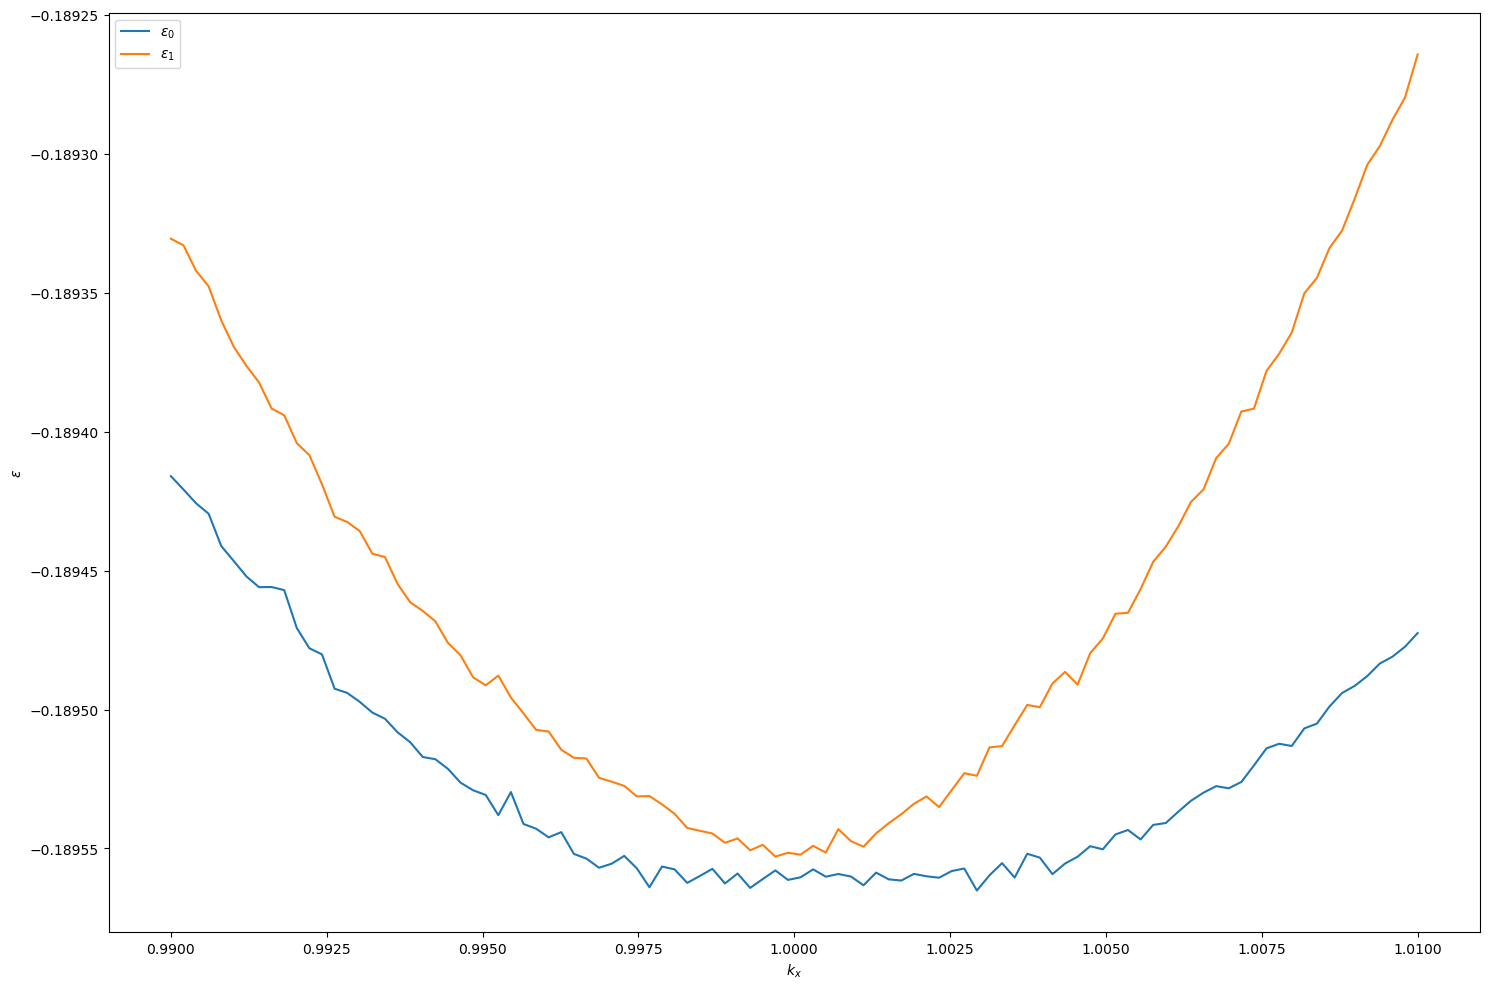

In [344]:
# set the relevant parameters
lambda = 0.99941
n = 12
vF = 3/4
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
bc_spacing = 10^(-4)
ky = 0
mod_plot_energy_line(lambda, n, vF, kappa, V, shells, bc_spacing, ky)

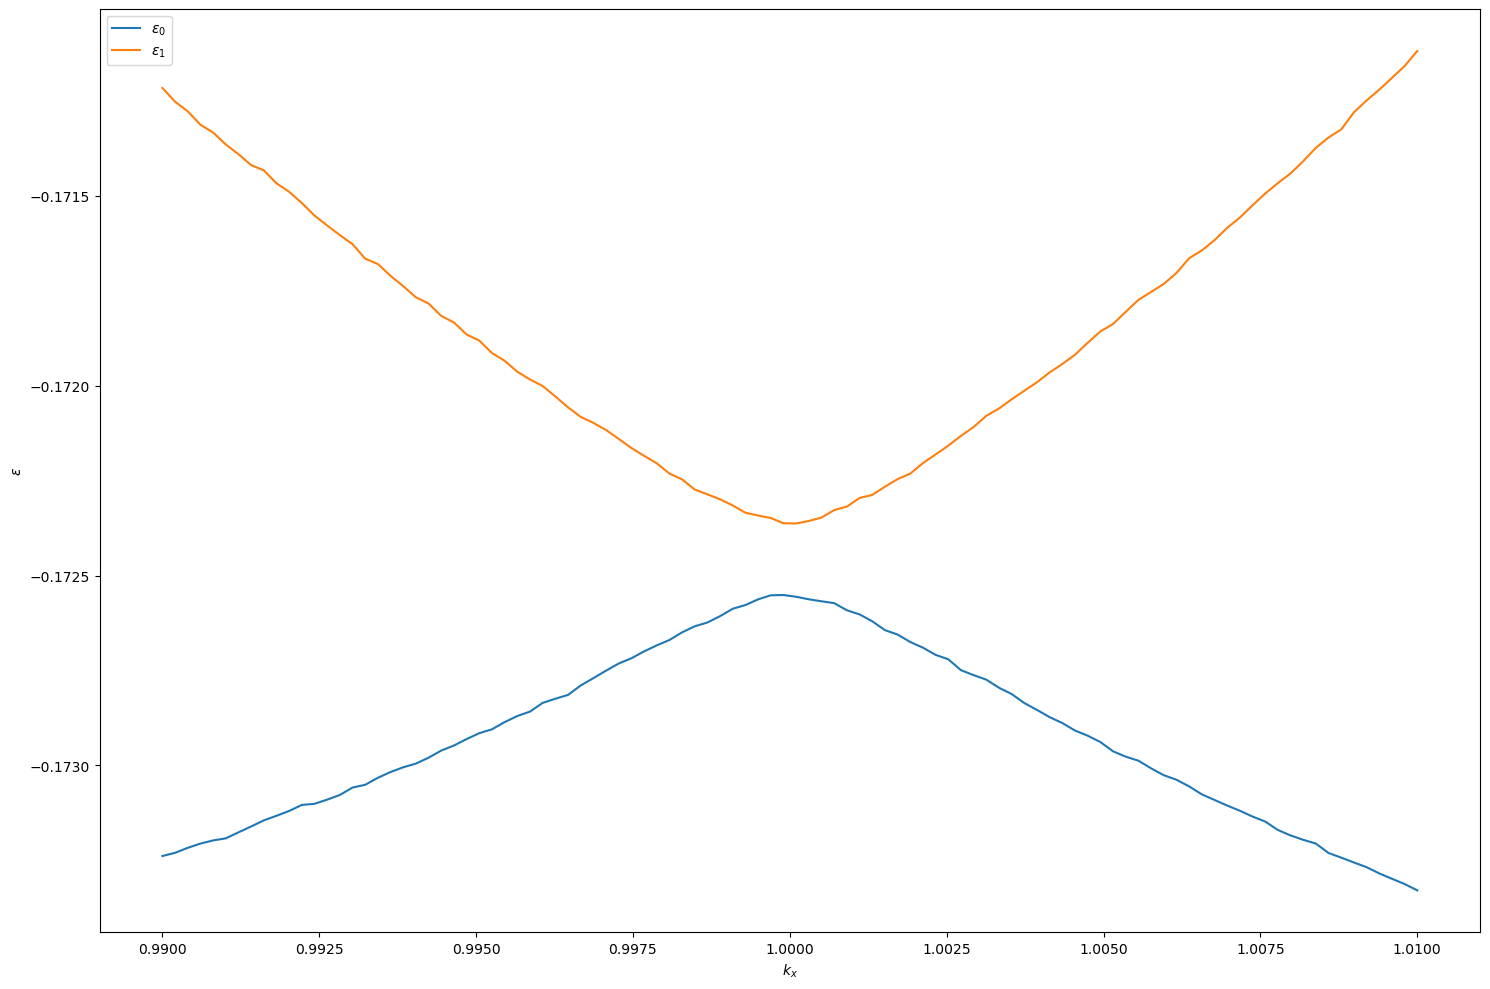

In [345]:
# set the relevant parameters
lambda = 0.99941
n = 12
vF = 3/4 + 0.2
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
bc_spacing = 10^(-4)
ky = 0
mod_plot_energy_line(lambda, n, vF, kappa, V, shells, bc_spacing, ky)

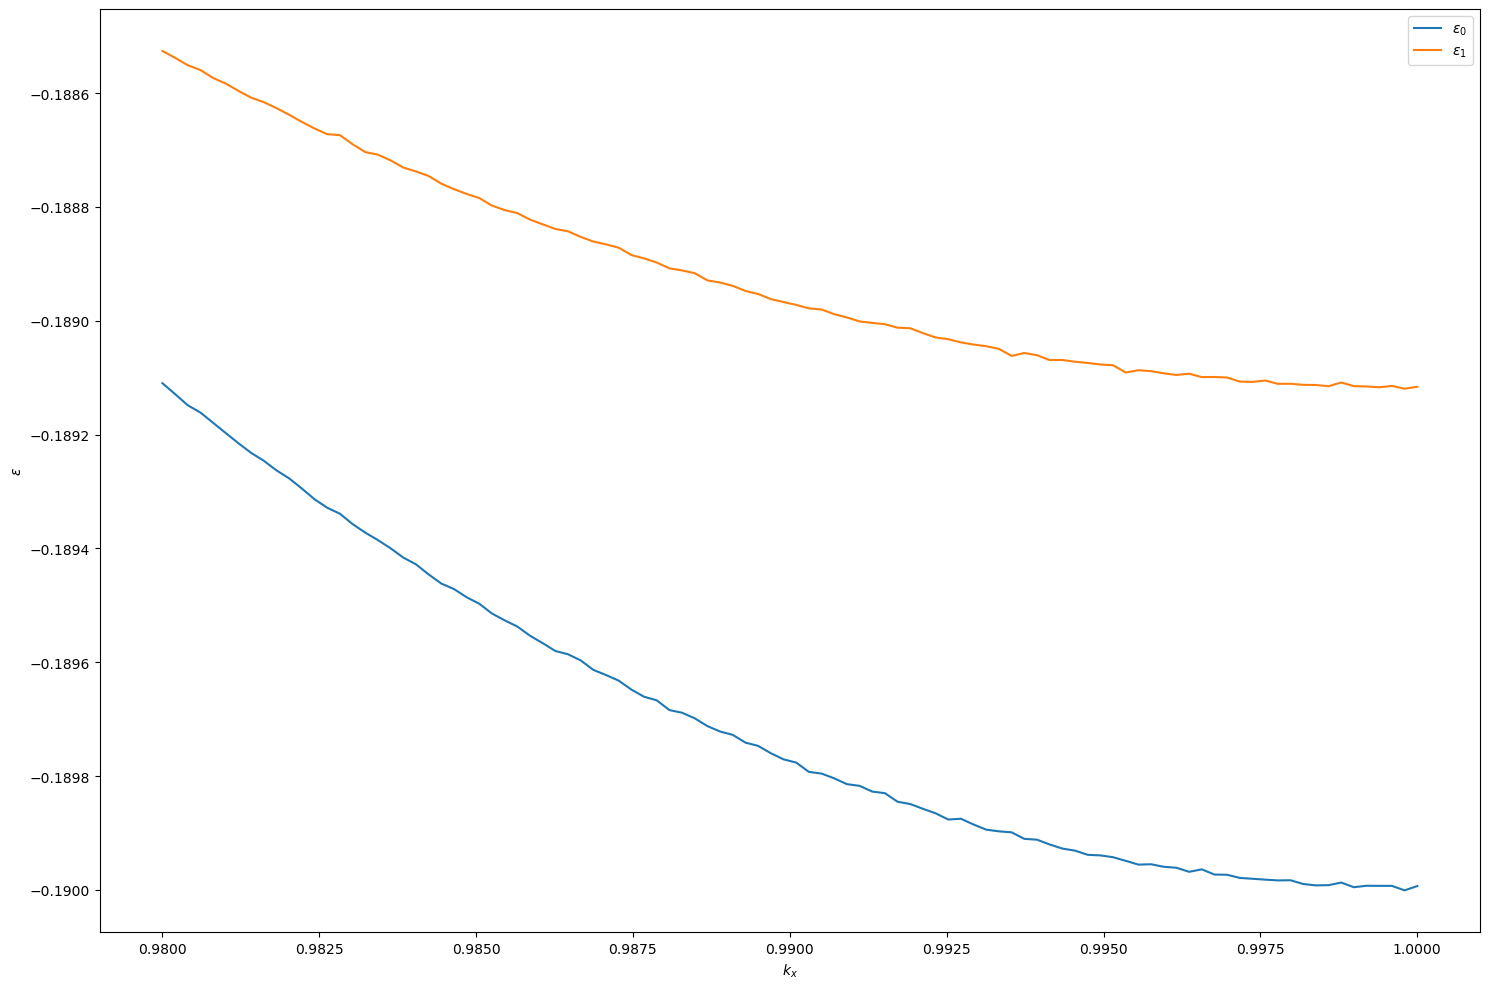

In [109]:
# set the relevant parameters
lambda = 1
n = 12
vF = 3/4
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
bc_spacing = 10^(-4)
ky = 0
mod_plot_energy_line(lambda, n, vF, kappa, V, shells, bc_spacing, ky)

## Berry Curvature contours

In [48]:
function mod_plot_bc(lambda, n, vF, kappa, V, shells, index, spacing, shift)
    n_pts = 10^2
    
    kx_list = range(kappa - shift, kappa + shift, n_pts)
    ky_list = shift * range(-1, 1, n_pts)
    grid = mesh_grid(kx_list, ky_list, Float64)

    # k_list = range(-kappa, kappa, n_pts)
    # grid = mesh_grid(k_list, k_list, Float64)


    bc_list = mod_grid_bc(grid, lambda, n, vF, kappa, V, shells, index, spacing)

    grid_new = reshape(grid, (n_pts, n_pts, 2))
    bc_list_new = reshape(bc_list, (n_pts, n_pts))

    bc_min = minimum(bc_list_new)
    bc_max = maximum(bc_list_new)
    bc_abs = maximum(abs.([bc_min, bc_max]))

    figure()
    xlabel(L"k_x")
    ylabel(L"k_y")
    title(L"\Omega(k_x, k_y) \text{ vs } (k_x, k_y)")
    pcolormesh(grid_new[:, :, 1], grid_new[:, :, 2], bc_list_new, cmap="RdBu", vmin = -bc_abs, vmax = bc_abs)
    colorbar()
    display(gcf())
end

mod_plot_bc (generic function with 2 methods)

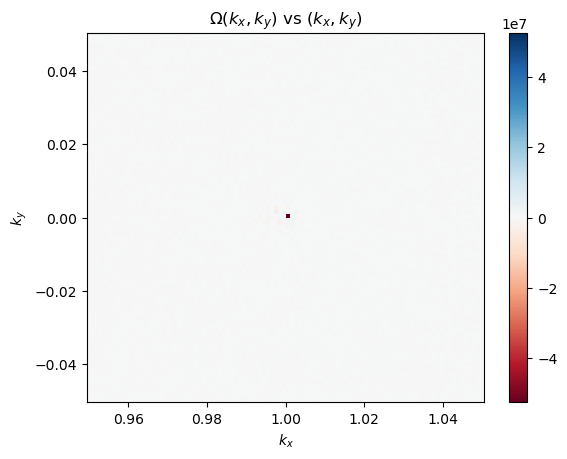

In [299]:
lambda = 0.99941
n = 12
vF = 3/4
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
index = 1
spacing = 10^(-4)
mod_plot_bc(lambda, n, vF, kappa, V, shells, index, spacing)

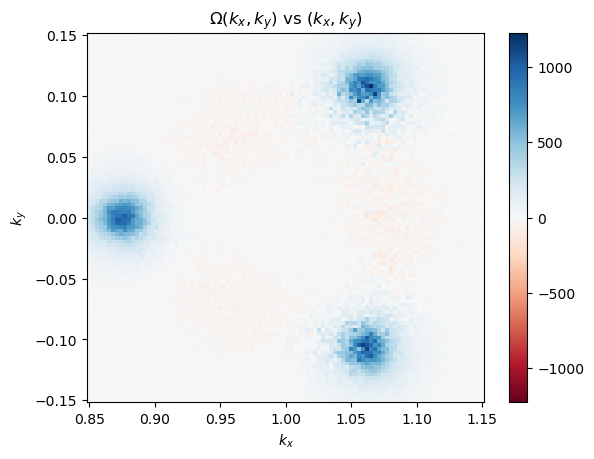

In [44]:
lambda = 1.01
n = 12
vF = 3/4
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
index = 1
spacing = 10^(-4)
mod_plot_bc(lambda, n, vF, kappa, V, shells, index, spacing)

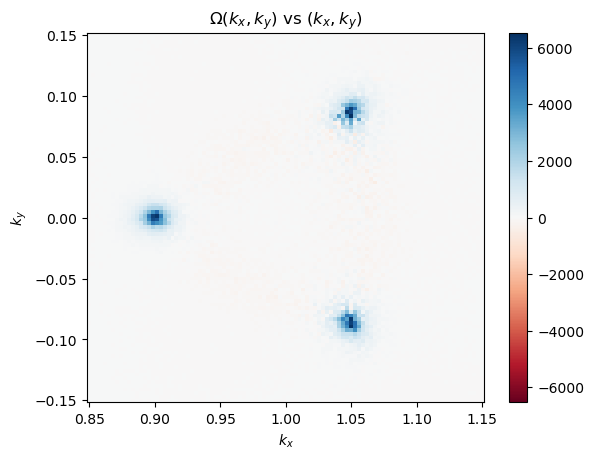

In [45]:
lambda = 1.005
n = 12
vF = 3/4
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
index = 1
spacing = 10^(-4)
mod_plot_bc(lambda, n, vF, kappa, V, shells, index, spacing)

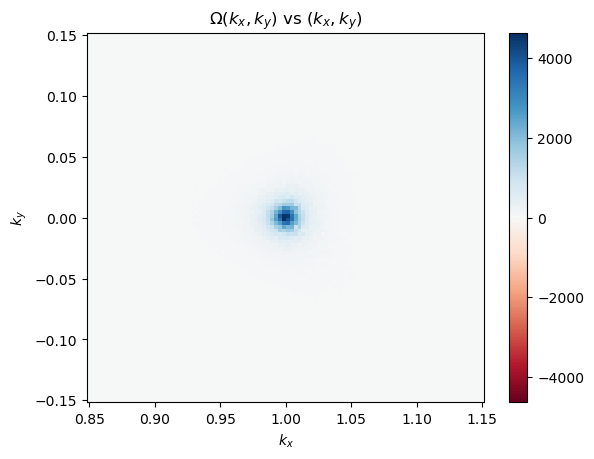

In [46]:
lambda = 1.005
n = 12
vF = -2 * real(exp(im * 2 * pi/3) * lambda_alpha(kappa, lambda, -1, -1))
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
index = 1
spacing = 10^(-4)
mod_plot_bc(lambda, n, vF, kappa, V, shells, index, spacing)

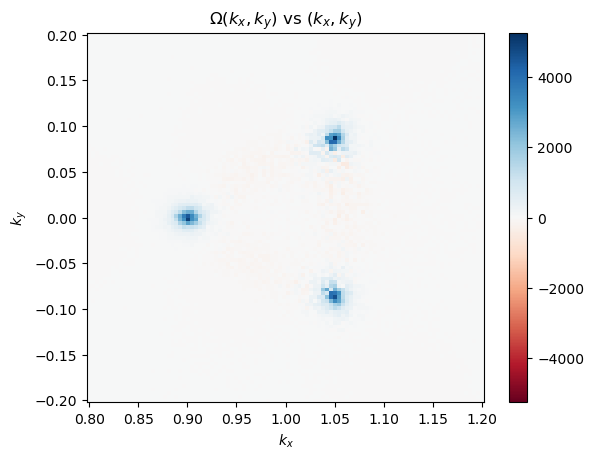

In [69]:
lambda = 1.005
n = 12
vF = -2 * real(exp(im * 2 * pi/3) * 1/2 * lambda_alpha(kappa, lambda, -1, -1))
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
index = 1
spacing = 10^(-4)
shift = 0.2
mod_plot_bc(lambda, n, vF, kappa, V, shells, index, spacing, shift)

In [ ]:
lambda = 1
n = 12
vF = -real(exp(im * 2 * pi/3) * 1/2 * lambda_alpha(kappa, lambda, -1, -1))
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
index = 1
spacing = 10^(-4)
shift = 0.01
mod_plot_bc(lambda, n, vF, kappa, V, shells, index, spacing, shift)

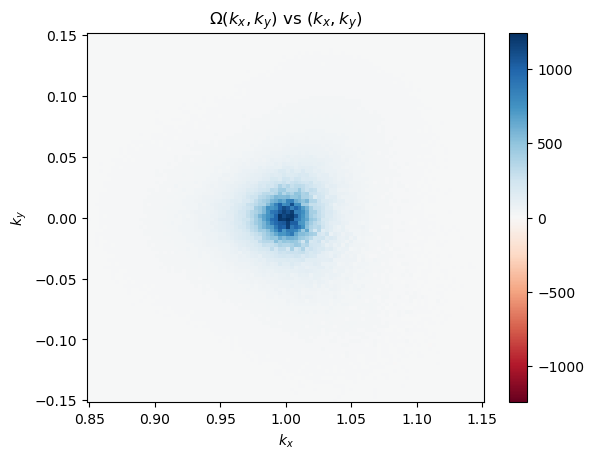

In [50]:
lambda = 1.01
n = 12
vF = -2 * real(exp(im * 2 * pi/3) * lambda_alpha(kappa, lambda, -1, -1))
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
index = 1
spacing = 10^(-4)
shift = 0.15
mod_plot_bc(lambda, n, vF, kappa, V, shells, index, spacing, shift)

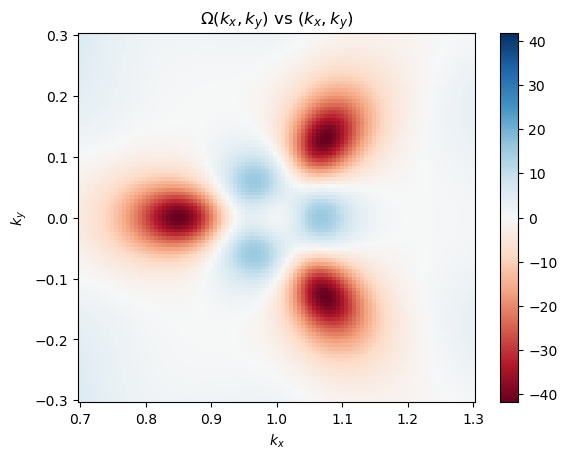

In [223]:
lambda = 0.99
n = 12
vF = -2 * real(exp(im * 2 * pi/3) * 1/2 * lambda_alpha(kappa, lambda, -1, -1))
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
index = 1
spacing = 10^(-2)
shift = 0.3
mod_plot_bc(lambda, n, vF, kappa, V, shells, index, spacing, shift)

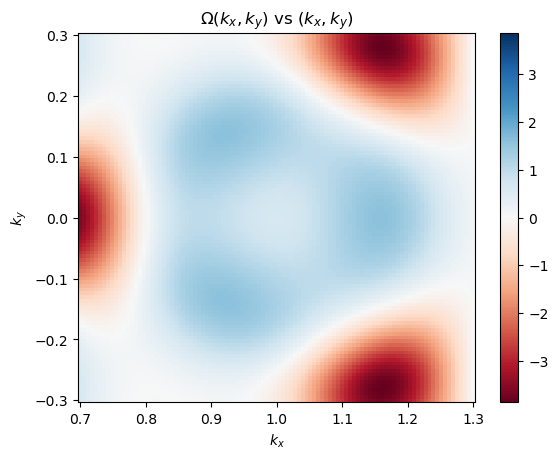

In [226]:
lambda = 0.85
n = 12
vF = -2 * real(exp(im * 2 * pi/3) * 1/2 * lambda_alpha(kappa, lambda, -1, -1))
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
index = 1
spacing = 10^(-2)
shift = 0.3
mod_plot_bc(lambda, n, vF, kappa, V, shells, index, spacing, shift)

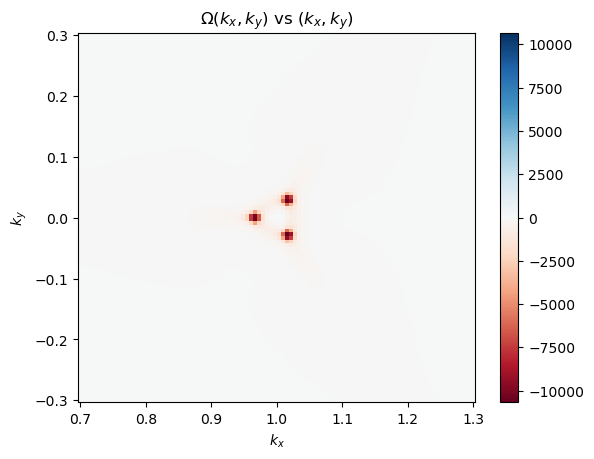

In [227]:
lambda = 1
n = 12
vF = -2 * real(exp(im * 2 * pi/3) * 1/2 * lambda_alpha(kappa, lambda, -1, -1))
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
index = 1
spacing = 10^(-2)
shift = 0.3
mod_plot_bc(lambda, n, vF, kappa, V, shells, index, spacing, shift)

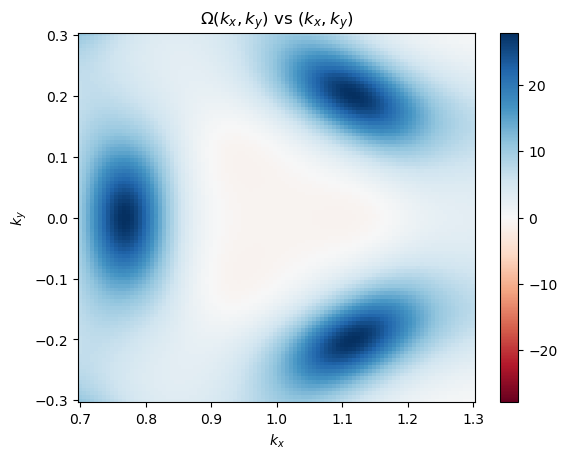

In [230]:
lambda = 1.1
n = 12
vF = -2 * real(exp(im * 2 * pi/3) * 1/2 * lambda_alpha(kappa, lambda, -1, -1))
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
index = 1
spacing = 10^(-2)
shift = 0.3
mod_plot_bc(lambda, n, vF, kappa, V, shells, index, spacing, shift)

## Berry curvature line cuts

In [55]:
function mod_plot_bc_v2(lambda1, lambda2, n, vF, kappa, V, shells, index, spacing, ky)
    n_pts = 10^2
    
    bc_list = Array{Float64}(undef, n_pts, 3)
    
    kx_list = range(0.8, 1.2 * kappa, n_pts)
    for j in 1:length(kx_list)
        point = reshape([kx_list[j], ky], (1, 2))
        bc_list[j, 1] = mod_grid_bc(point, lambda1, n, vF, kappa, V, shells, index, spacing)[1]
        bc_list[j, 2] = mod_grid_bc(point, lambda2, n, vF, kappa, V, shells, index, spacing)[1]
        bc_list[j, 3] = bc_list[j, 1] - bc_list[j, 2]
    end

    fig, axs = plt.subplots(1,3,figsize=(15, 6))
    axs[1].plot(kx_list, bc_list[:, 1])
    axs[1].set_xlabel(L"$k_x$")
    axs[1].set_ylabel(L"$\Omega(\lambda_1)$")

    axs[2].plot(kx_list, bc_list[:, 2])
    axs[2].set_xlabel(L"$k_x$")
    axs[2].set_ylabel(L"$\Omega(\lambda_2)$")

    axs[3].plot(kx_list, bc_list[:, 3])
    axs[3].set_xlabel(L"$k_x$")
    axs[3].set_ylabel(L"$\Omega(\lambda_1) - \Omega(\lambda_2)$")

    fig.tight_layout()
    fig
end

mod_plot_bc_v2 (generic function with 1 method)

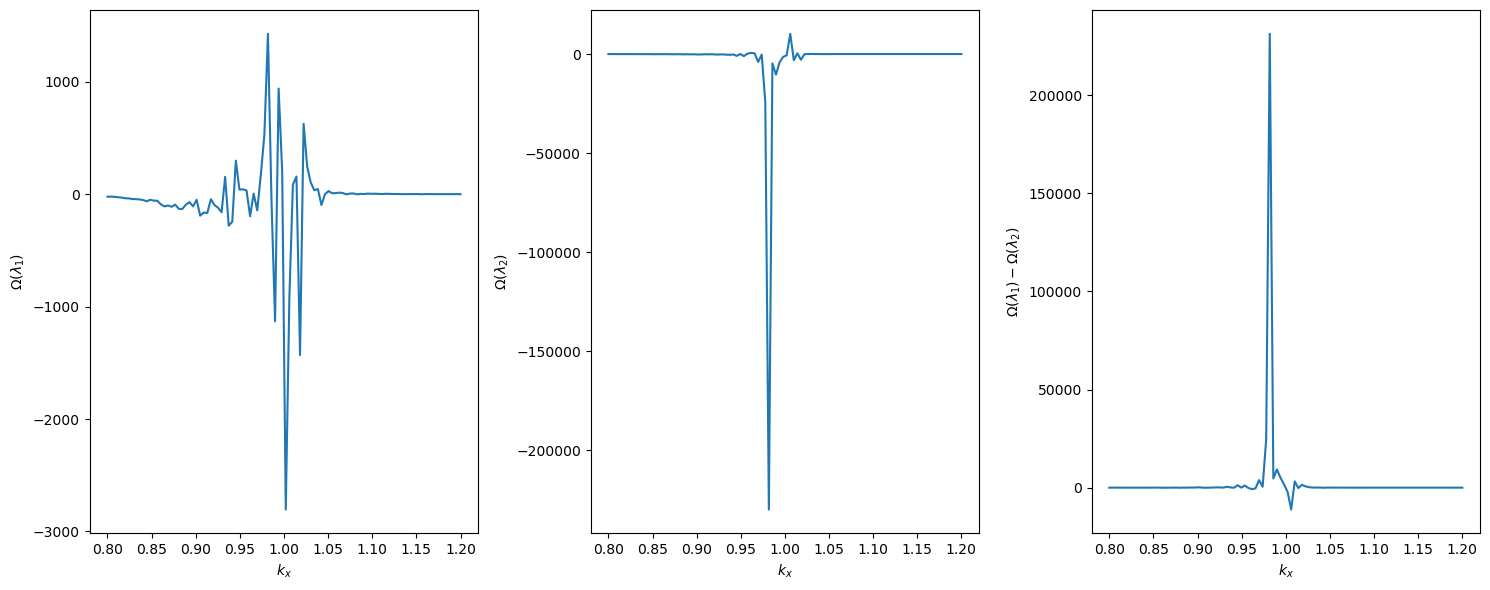

In [89]:
lambda1 = 0.999
lambda2 = 0.9996
n = 12
vF = -2 * real(exp(im * 2 * pi/3) * 1/2 * lambda_alpha(kappa, lambda1, -1, -1))
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
index = 1
spacing = 10^(-4)
ky = 0
mod_plot_bc_v2(lambda1, lambda2, n, vF, kappa, V, shells, index, spacing, ky)

In [301]:
function mod_plot_bc_v3(vF1, vF2, n, lambda, kappa, V, shells, index, spacing, ky)
    n_pts = 10^2
    
    bc_list = Array{Float64}(undef, n_pts, 3)
    
    kx_list = range(0.8, 1.05 * kappa, n_pts)
    for j in 1:length(kx_list)
        point = reshape([kx_list[j], ky], (1, 2))
        bc_list[j, 1] = mod_grid_bc(point, lambda, n, vF1, kappa, V, shells, index, spacing)[1]
        bc_list[j, 2] = mod_grid_bc(point, lambda, n, vF2, kappa, V, shells, index, spacing)[1]
        bc_list[j, 3] = bc_list[j, 1] - bc_list[j, 2]
    end

    fig, axs = plt.subplots(1,3,figsize=(15, 6))
    axs[1].plot(kx_list, bc_list[:, 1])
    axs[1].set_xlabel(L"$k_x$")
    axs[1].set_ylabel(L"$\Omega(v_F^1)$")

    axs[2].plot(kx_list, bc_list[:, 2])
    axs[2].set_xlabel(L"$k_x$")
    axs[2].set_ylabel(L"$\Omega(v_F^2)$")

    axs[3].plot(kx_list, bc_list[:, 3])
    axs[3].set_xlabel(L"$k_x$")
    axs[3].set_ylabel(L"$\Omega(v_F^1) - \Omega(v_F^2)$")

    fig.tight_layout()
    fig
end

mod_plot_bc_v3 (generic function with 1 method)

In [139]:
function mod_plot_ang_bc(vF, n, lambda, kappa, V, shells, index, spacing, k_mag)
    n_pts = 10^2
    
    bc_list = Array{Float64}(undef, n_pts)

    ang_list = range(-pi, pi, n_pts)
    
    for j in 1:length(ang_list)
        point = reshape([kappa, 0] + k_mag * [cos(ang_list[j]), sin(ang_list[j])], (1, 2))
        bc_list[j] = mod_grid_bc(point, lambda, n, vF, kappa, V, shells, index, spacing)[1]
    end

    fig, axs = plt.subplots(1,1,figsize=(15, 6))
    axs.plot(ang_list/pi, bc_list)
    axs.set_xlabel(L"$\text{arg}(k)/ \pi$")
    axs.set_ylabel(L"$\Omega$")

    fig.tight_layout()
    fig
end

mod_plot_ang_bc (generic function with 1 method)

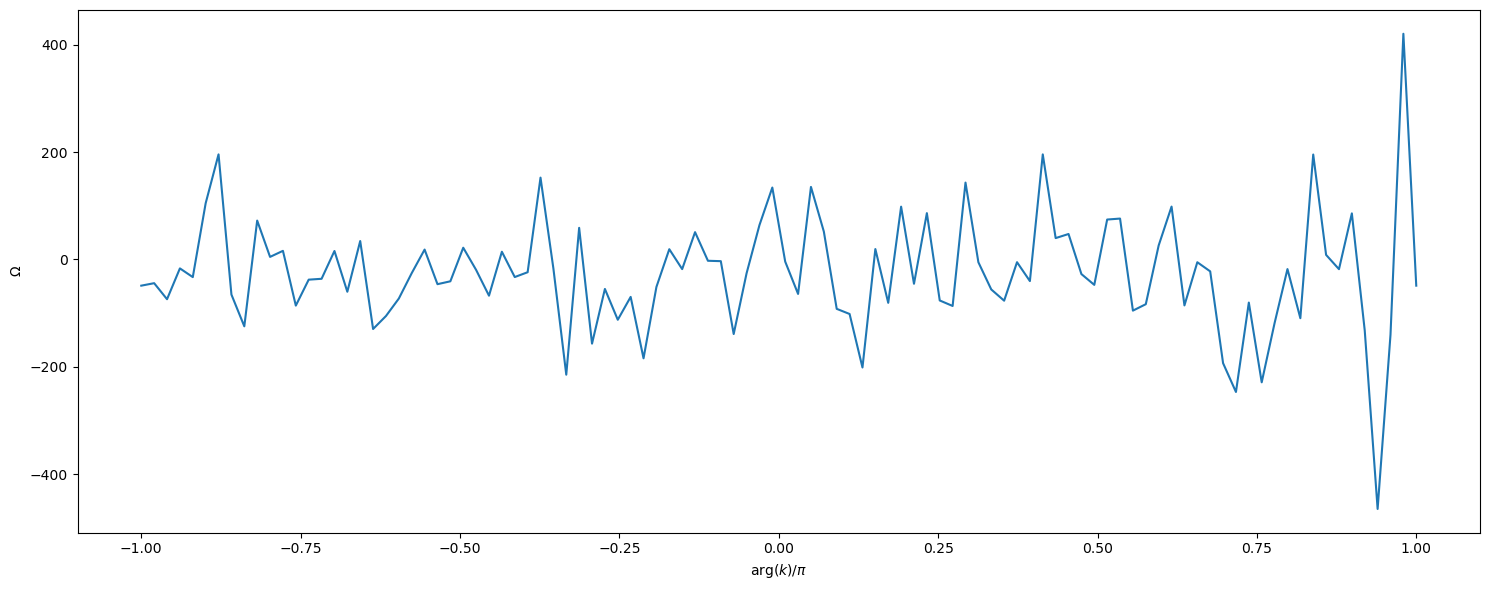

In [317]:
lambda = 0.99941
n = 12
#vF = -2 * real(exp(im * 2 * pi/3) * 1/2 * lambda_alpha(kappa, lambda, 0, 1))
vF = 3/4
kappa = 1
V = [[0, 0] [0, 1]]
shells = 5
index = 1
spacing = 10^(-4)
k_mag = 0.01
mod_plot_ang_bc(vF, n, lambda, kappa, V, shells, index, spacing, k_mag)

## Search for flatband

In [469]:
function mod_plot_flat(n, lambda, kappa, V, shells, llm, ulm, index)
    k1 = [1, 0]
    k2 = [1, 0.01]
    vF_list = range(llm, ulm, 10^2)
    seps = Array{Float64}(undef, length(vF_list))
    for i in 1:length(vF_list)
        vF = vF_list[i]
        ham1 = mod_lambda_ham(k1, lambda, n, vF, kappa, V, shells)
        vals1 = eigvals(Hermitian(ham1))
        ham2 = mod_lambda_ham(k2, lambda, n, vF, kappa, V, shells)
        vals2 = eigvals(Hermitian(ham2))
        seps[i] = log10(abs(vals2[index] - vals1[index]))
    end
    fig, axs = plt.subplots(1,1,figsize=(15, 8))
    axs.set_xlabel(L"$v_F$")
    axs.set_ylabel(L"$\log|\delta \epsilon|$")
    axs.set_title(L"$log|\delta \epsilon| \text{ vs } v_F$")
    axs.plot(vF_list, seps)
    
    fig
end

mod_plot_flat (generic function with 1 method)

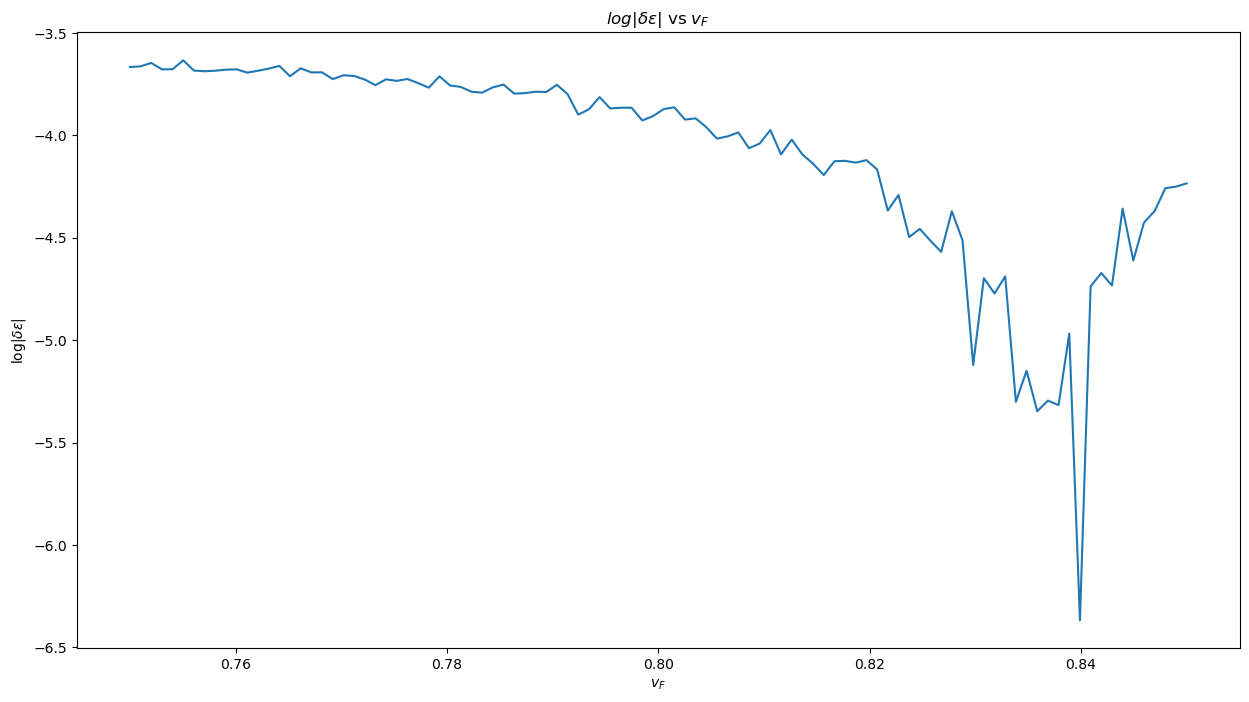

In [470]:
n = 12
lambda = 1
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
llm = 3/4
ulm = 3/4 + 0.1
index = 1
mod_plot_flat(n, lambda, kappa, V, shells, llm, ulm, index)

## Further experiments

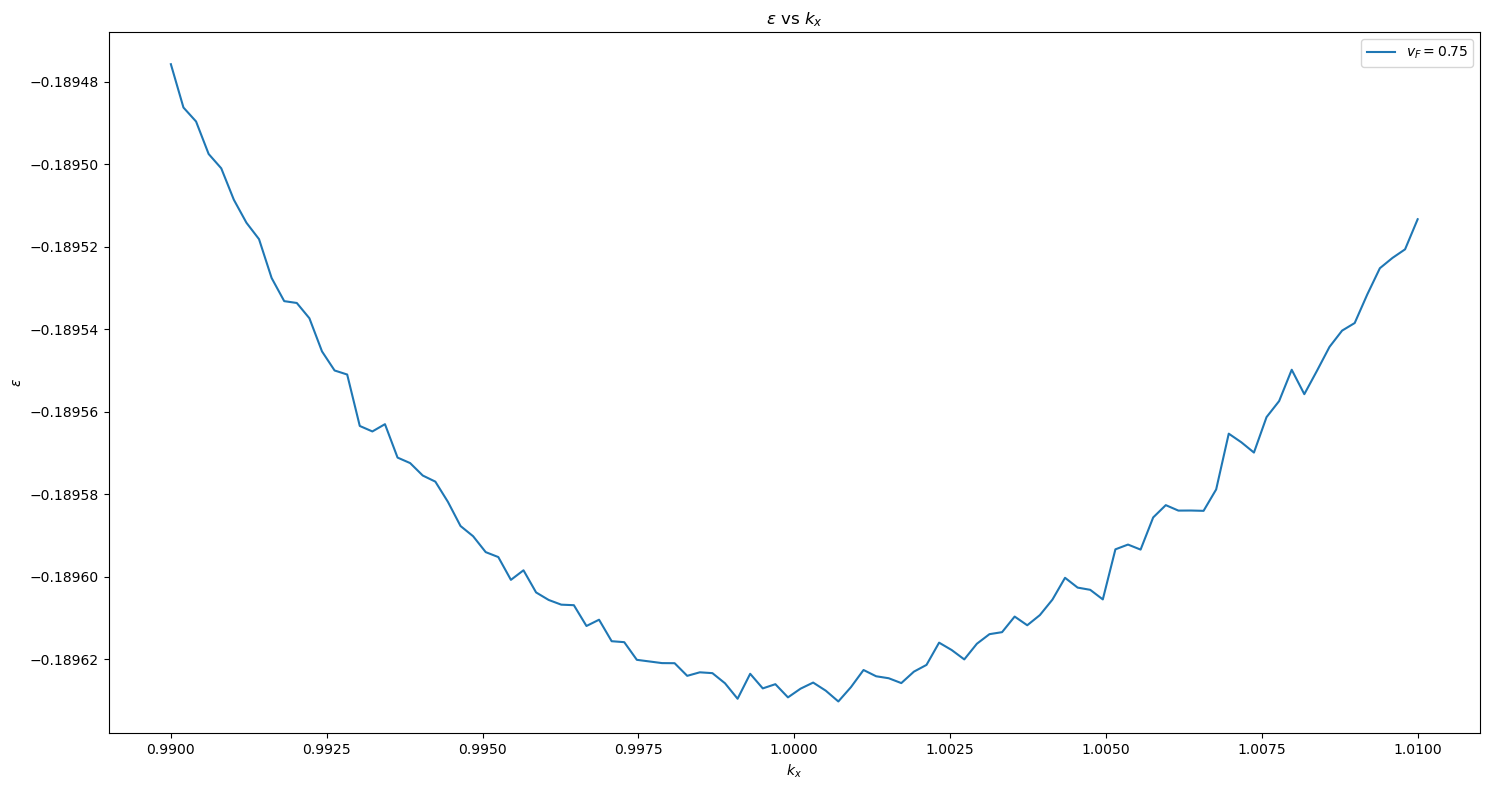

In [793]:
# set the relevant parameters
# lambda = 0.99942025
lambda = 0.99932025
n = 12
vF_list = [3/4]
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
bc_spacing = 10^(-4)
ky = 0
llm = 0.99
ulm = 1.01
index = 1
mod_plot_eg_kx(ky, n, lambda, vF_list, kappa, V, shells, llm, ulm, index)

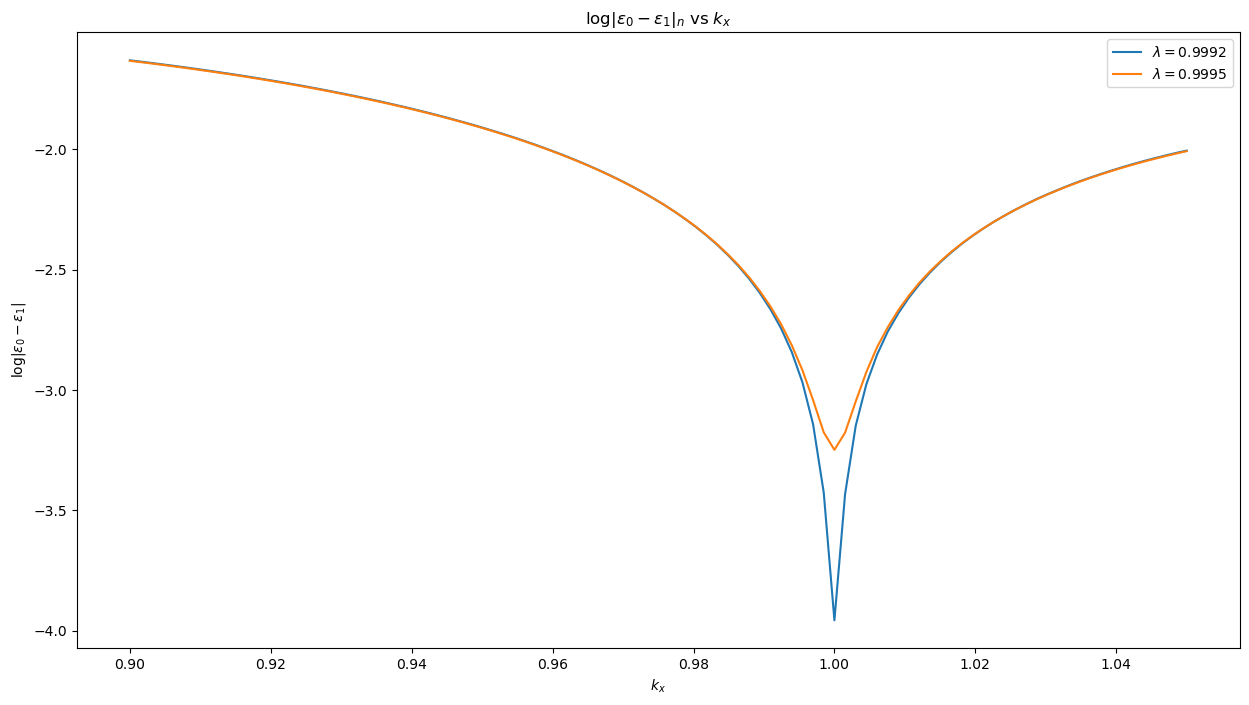

In [754]:
# set the relevant parameters
ky = 0
n = 12
lambda_list = [0.9992, 0.9995]
vF = 2/4
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
llm = 0.9
ulm = 1.05 * kappa
mod_plot_gap_kx(ky, n, lambda_list, vF, kappa, V, shells, llm, ulm)

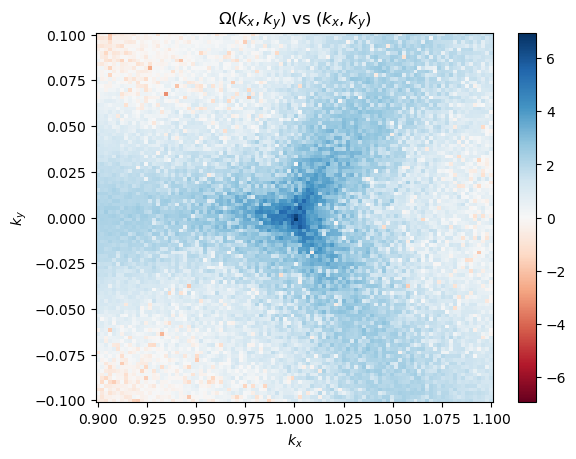

In [737]:
lambda = 0.99942025
n = 12
vF = 3/4
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
index = 1
spacing = 10^(-4)
mod_plot_bc(lambda, n, vF, kappa, V, shells, index, spacing)

# Quadratic dispersion plots

We've found some sick physics for a large power-law disperson of the form $v_F k^n$. Now the question is, can we recover similar behavior (in terms of the change in energy) using a quadratic dispersion.

## Energy gaps

In [350]:
function plot_gap_lambda(q, rs_list, kappa, V, shells, llm, ulm)
    lambda_list = range(llm, ulm, 10^2)
    gaps = Array{Float64}(undef, length(lambda_list), length(rs_list))
    for i in 1:length(lambda_list)
        lambda = lambda_list[i]
        q1 = kappa * [1, 0]
        for j in 1:length(rs_list)
            rs = rs_list[j]
            ham = lambda_ham(q1, lambda, rs, kappa, V, shells)
            vals = eigvals(Hermitian(ham))
            gaps[i, j] = log10(vals[2] - vals[1])
        end
    end
    fig, axs = plt.subplots(1,1,figsize=(15, 8))
    axs.set_xlabel(L"$\lambda$")
    axs.set_ylabel(L"$\log|\epsilon_0 - \epsilon_1|$")
    axs.set_title(L"$\log|\epsilon_0 - \epsilon_1|_{n} \text{ vs } \lambda$")
    for j in 1:length(rs_list)
        rs = round(rs_list[j], sigdigits=2)
        axs.plot(lambda_list, gaps[:, j], label = raw"$r_s = $" * "$rs")
    end
    axs.legend()
    fig
end

plot_gap_lambda (generic function with 1 method)

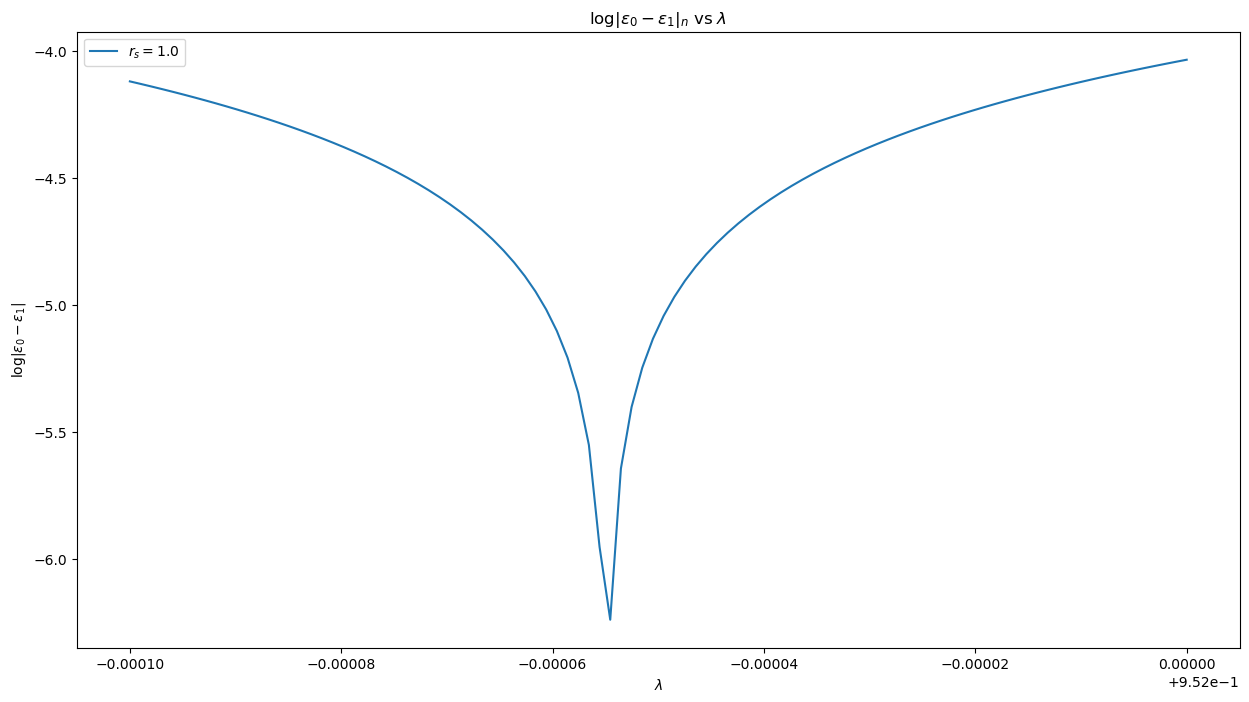

In [351]:
# set the relevant parameters
q = [0, 0]
rs_list = [1]
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
llm = 0.9519
ulm = 0.9520
plot_gap_lambda(q, rs_list, kappa, V, shells, llm, ulm)

In [6]:
function plot_gap_kx(ky, lambda_list, rs, kappa, V, shells, llm, ulm)
    kx_list = range(llm, ulm, 10^2)
    gaps = Array{Float64}(undef, length(kx_list), length(lambda_list))
    for i in 1:length(kx_list)
        kx = kx_list[i]
        q1 = [kx, ky]
        for j in 1:length(lambda_list)
            lambda = lambda_list[j]
            ham = lambda_ham(q1, lambda, rs, kappa, V, shells)
            vals = eigvals(Hermitian(ham))
            gaps[i, j] = log10(vals[2] - vals[1])
        end
    end
    fig, axs = plt.subplots(1,1,figsize=(15, 8))
    axs.set_xlabel(L"$k_x$")
    axs.set_ylabel(L"$\log|\epsilon_0 - \epsilon_1|$")
    axs.set_title(L"$\log|\epsilon_0 - \epsilon_1|_{n} \text{ vs } k_x$")
    for j in 1:length(lambda_list)
        lambda = round(lambda_list[j], sigdigits=5)
        axs.plot(kx_list, gaps[:, j], label = raw"$\lambda = $" * "$lambda")
    end
    axs.legend()
    fig
end

plot_gap_kx (generic function with 1 method)

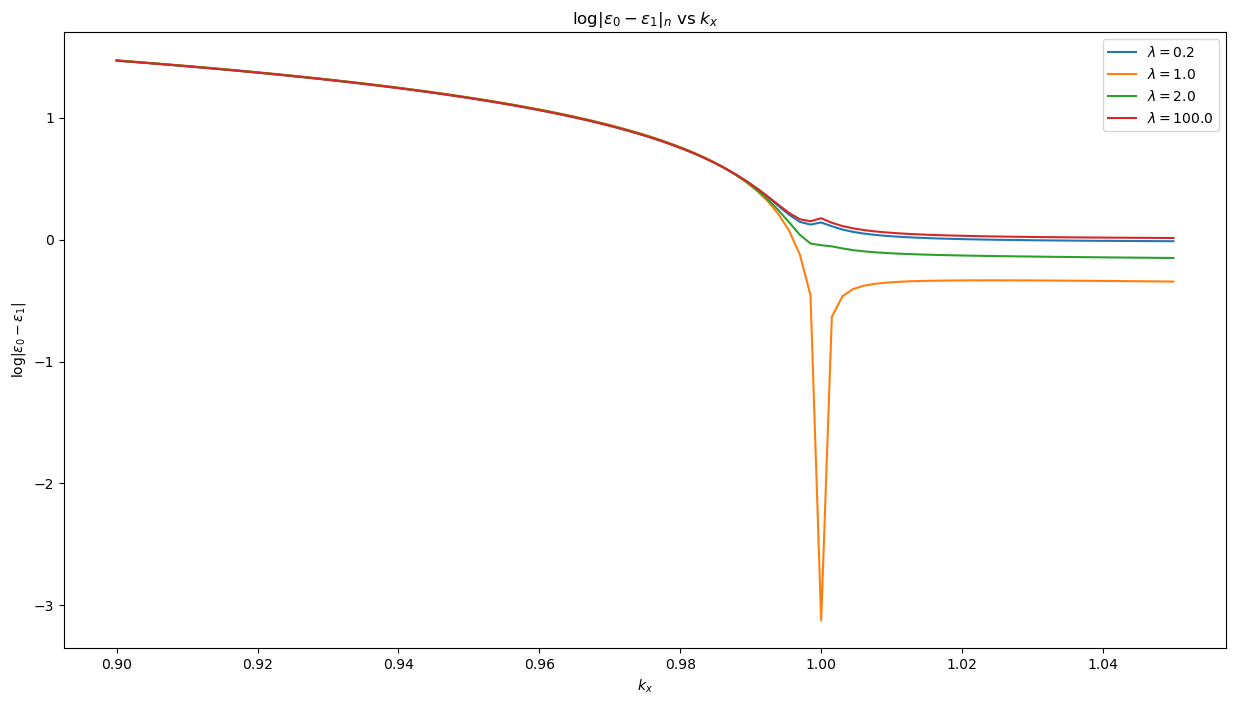

In [1039]:
# set the relevant parameters
ky = 0
lambda_list = [0.2, 1, 2, 100]
rs = 0.1
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
llm = 0.9
ulm = 1.05 * kappa
plot_gap_kx(ky, lambda_list, rs, kappa, V, shells, llm, ulm)

In [587]:
function plot_eg_kx(ky, lambda, rs_list, kappa, V, shells, llm, ulm, index)
    kx_list = range(llm, ulm, 10^2)
    gaps = Array{Float64}(undef, length(kx_list), length(rs_list), 2)
    for i in 1:length(kx_list)
        kx = kx_list[i]
        q1 = [kx, ky]
        for j in 1:length(rs_list)
            rs = rs_list[j]
            ham = lambda_ham(q1, lambda, rs, kappa, V, shells)
            vals = eigvals(Hermitian(ham))
            gaps[i, j, 1] = vals[index]
            gaps[i, j, 2] = vals[2]
        end
    end
    fig, axs = plt.subplots(1,1,figsize=(15, 8))
    axs.set_xlabel(L"$k_x$")
    axs.set_ylabel(L"$\epsilon$")
    axs.set_title(L"$\epsilon \text{ vs } k_x$")
    for j in 1:length(rs_list)
        rs = round(rs_list[j], sigdigits=5)
        axs.plot(kx_list, gaps[:, j, 1], label = raw"$r_s = $" * "$rs")
        #axs.plot(kx_list, gaps[:, j, 2], label = raw"$r_s = $" * "$rs")
    end
    axs.legend()

    fig.tight_layout()
    
    fig
end

plot_eg_kx (generic function with 1 method)

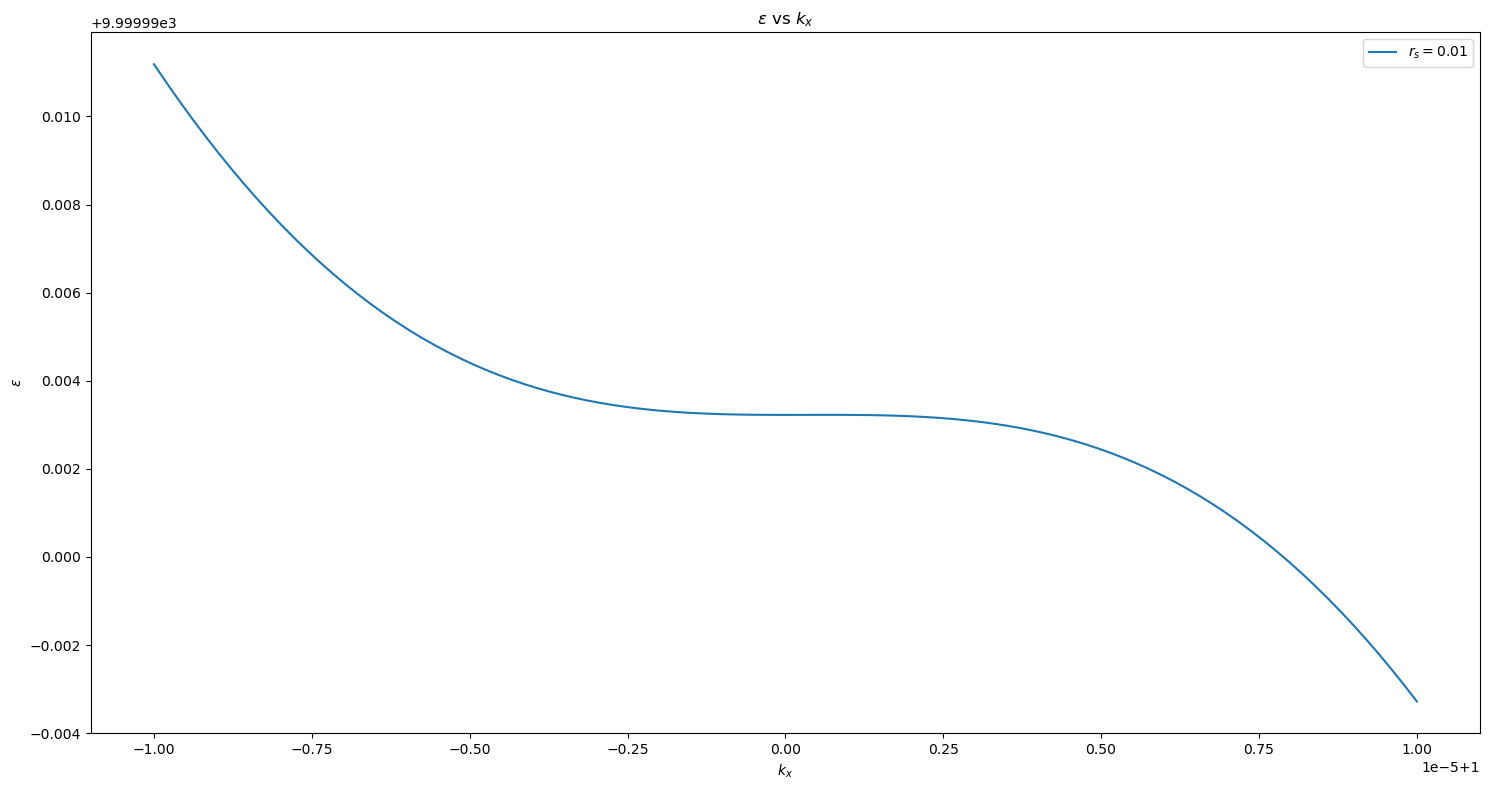

In [618]:
# set the relevant parameters
lambda = 1.4
rs_list = [0.01]
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
bc_spacing = 10^(-4)
ky = 0
llm = 0.99999
ulm = 1.00001
index = 2
plot_eg_kx(ky, lambda, rs_list, kappa, V, shells, llm, ulm, index)

sys:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.


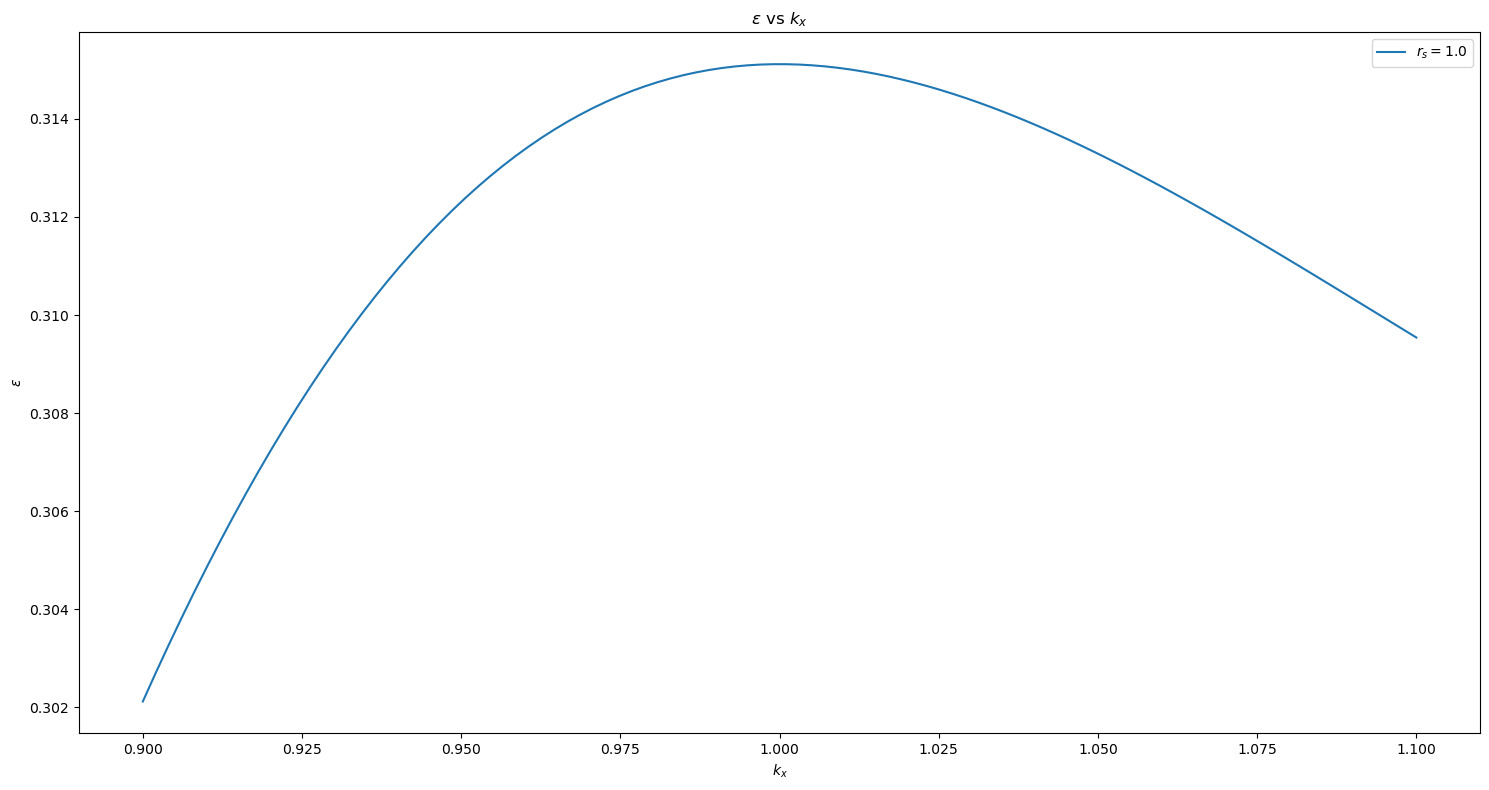

In [33]:
# set the relevant parameters
lambda = 1.2
rs_list = [1]
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
bc_spacing = 10^(-4)
ky = 0
llm = 0.9
ulm = 1.1
index = 1
plot_eg_kx(ky, lambda, rs_list, kappa, V, shells, llm, ulm, index)

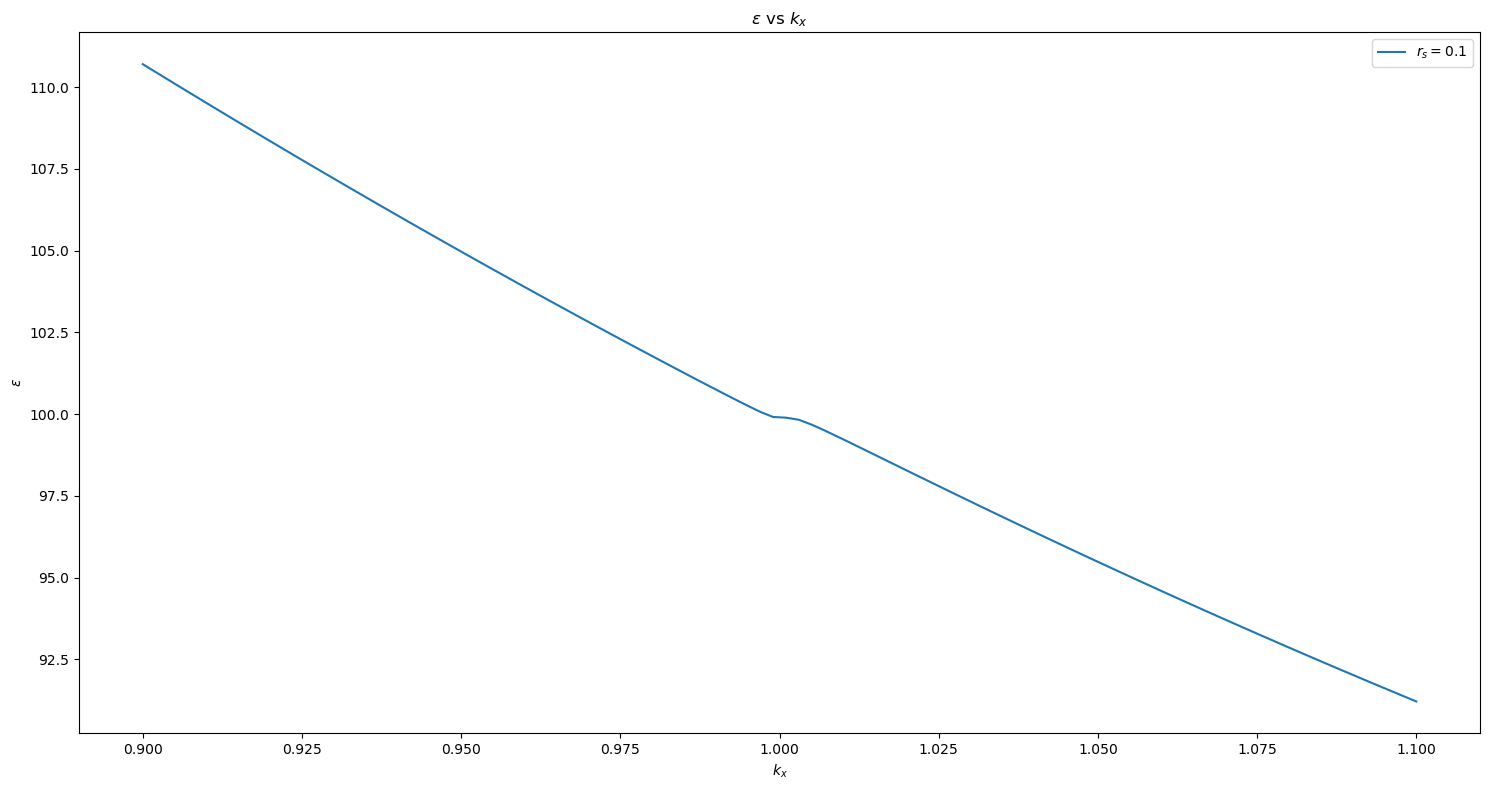

In [30]:
# set the relevant parameters
lambda = 1.2
rs_list = [0.1]
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
bc_spacing = 10^(-4)
ky = 0
llm = 0.9
ulm = 1.1
index = 2
plot_eg_kx(ky, lambda, rs_list, kappa, V, shells, llm, ulm, index)

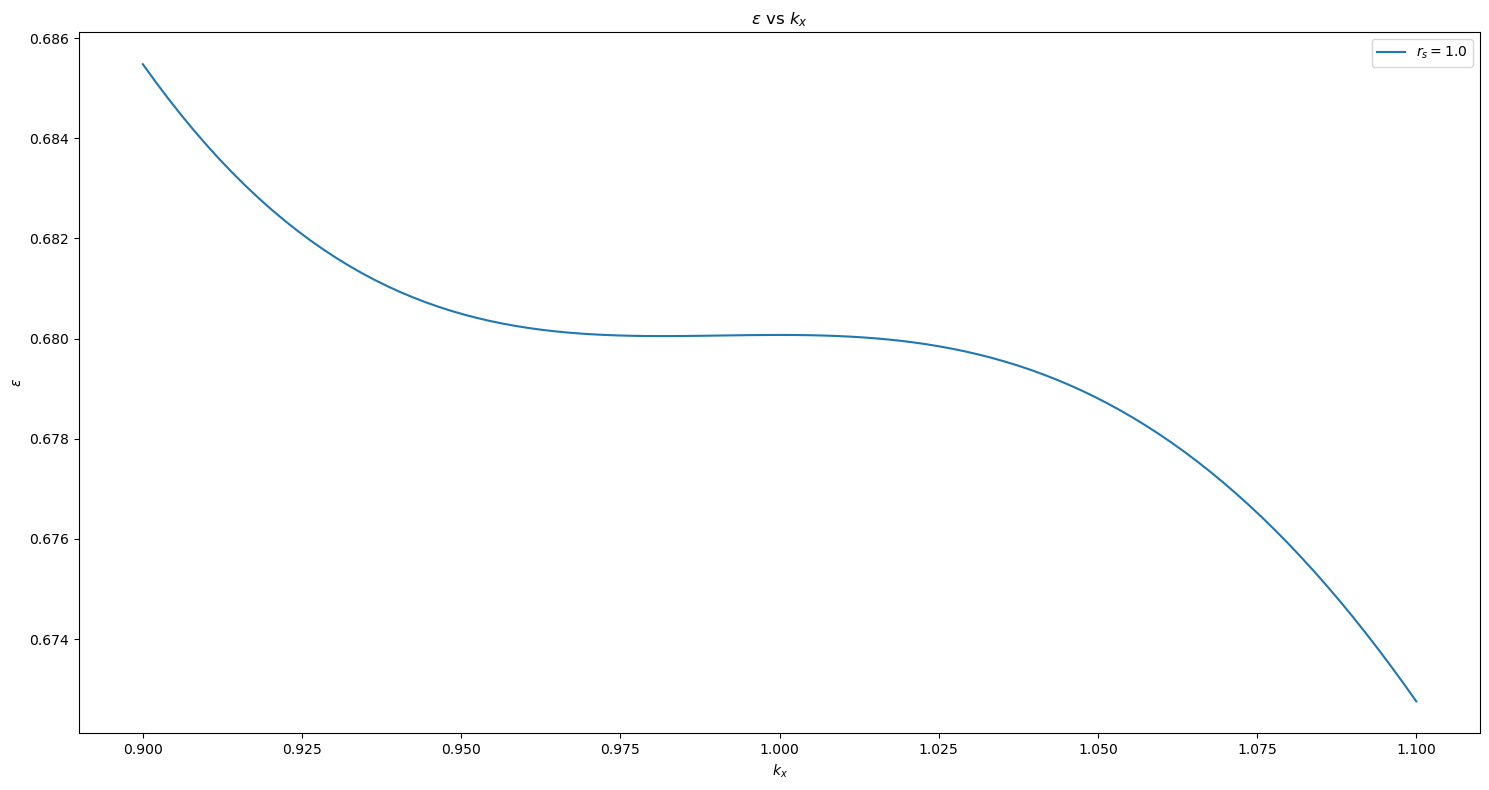

In [31]:
# set the relevant parameters
lambda = 1.2
rs_list = [1]
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
bc_spacing = 10^(-4)
ky = 0
llm = 0.9
ulm = 1.1
index = 2
plot_eg_kx(ky, lambda, rs_list, kappa, V, shells, llm, ulm, index)

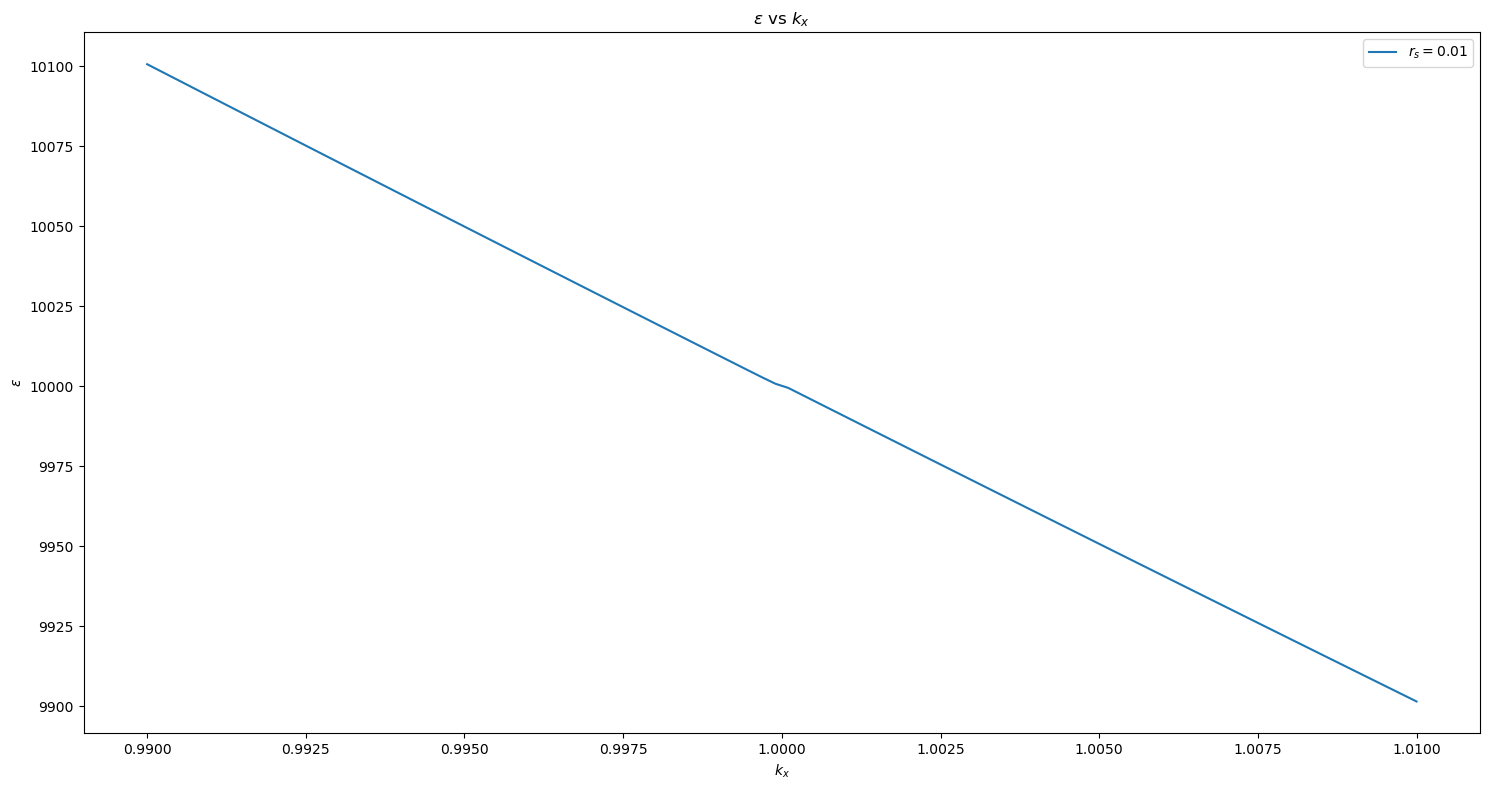

In [26]:
# set the relevant parameters
lambda = 3
rs_list = [0.01]
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
bc_spacing = 10^(-4)
ky = 0
llm = 0.99
ulm = 1.01
index = 2
plot_eg_kx(ky, lambda, rs_list, kappa, V, shells, llm, ulm, index)

## Energy contours

In [18]:
function plot_energy(lambda, rs, kappa, V, shells, spacing, index)
    n_pts = 10^2

    shift = 0.1
    kx_list = range(kappa - shift, kappa + shift, n_pts)
    ky_list = shift * range(-1, 1, n_pts)
    grid = mesh_grid(kx_list, ky_list, Float64)

    energy_list = Array{Float64}(undef, n_pts * n_pts, 3)

    for j in 1:(n_pts * n_pts)
        k = grid[j, :]
        ham = lambda_ham(k, lambda, rs, kappa, V, shells)
        energy_list[j, 1] = eigvals(Hermitian(ham))[2] - eigvals(Hermitian(ham))[1]
    end

    grid_new = reshape(grid, (n_pts, n_pts, 2))
    energies = reshape(energy_list, (n_pts, n_pts, 3))

    fig, axs = plt.subplots(1, 1, figsize=(10, 6))
    axs.set_xlabel(L"$k_x$")
    axs.set_ylabel(L"$k_y$")
    axs.set_title(L"$\epsilon$")
    plt1 = axs.pcolormesh(grid_new[:, :, 1], grid_new[:, :, 2], energies[:, :, 1], cmap="RdBu")
    fig.colorbar(plt1, ax=axs)
    fig.tight_layout()

    fig
end

plot_energy (generic function with 1 method)

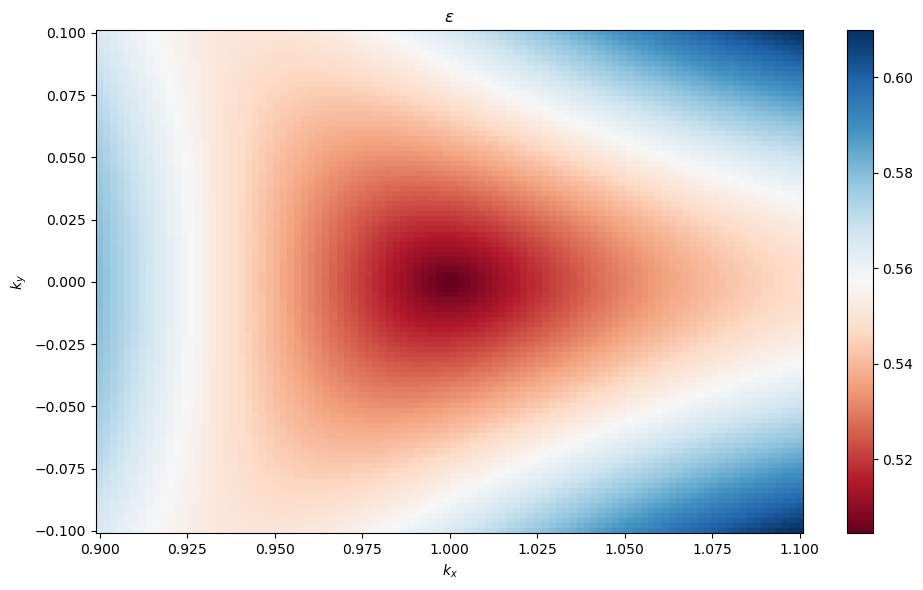

In [9]:
lambda = 0.9519
rs = 1
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
spacing = 10^(-4)
index = 2
plot_energy(lambda, rs, kappa, V, shells, spacing, index)

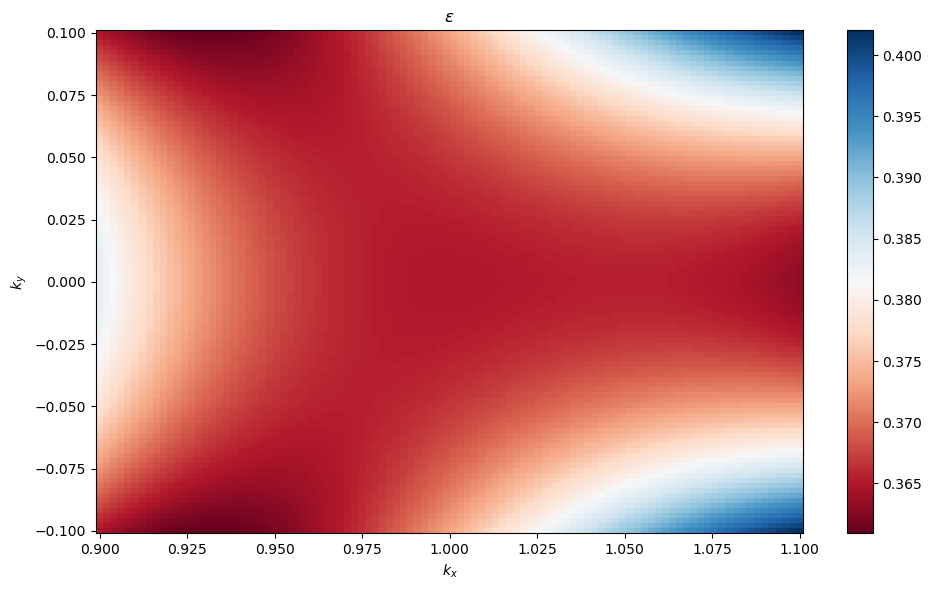

In [19]:
lambda = 1.2
rs = 1
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
spacing = 10^(-4)
index = 2
plot_energy(lambda, rs, kappa, V, shells, spacing, index)

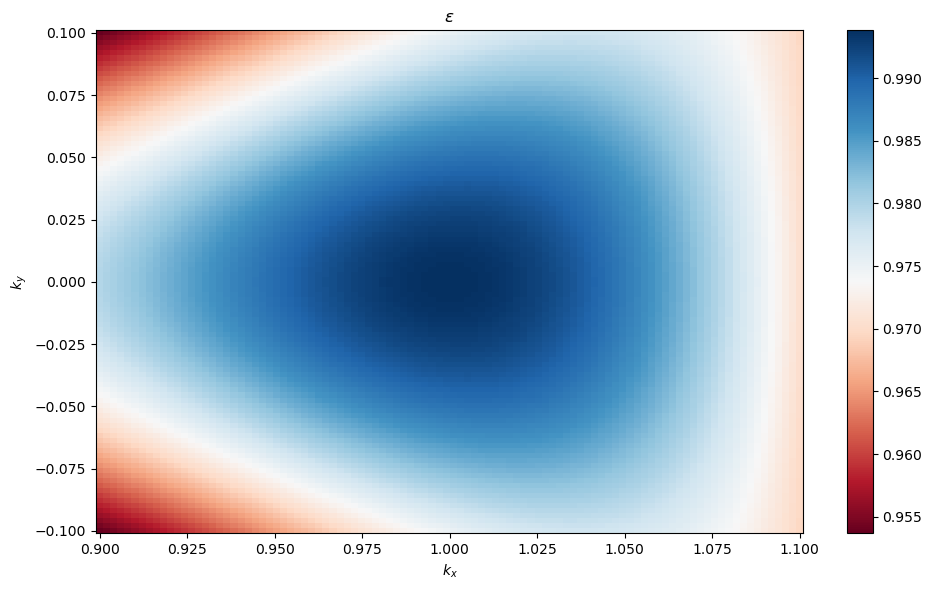

In [11]:
lambda = 2
rs = 1
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
spacing = 10^(-4)
index = 2
plot_energy(lambda, rs, kappa, V, shells, spacing, index)

## Berry curvature line cuts

In [14]:
function plot_bc_v2(lambda1, lambda2, rs, kappa, V, shells, index, spacing, ky)
    n_pts = 10^2
    
    bc_list = Array{Float64}(undef, n_pts, 3)
    
    kx_list = range(0.9, 1.1 * kappa, n_pts)
    for j in 1:length(kx_list)
        point = reshape([kx_list[j], ky], (1, 2))
        bc_list[j, 1] = grid_bc(point, lambda1, rs, kappa, V, shells, index, spacing)[1]
        bc_list[j, 2] = grid_bc(point, lambda2, rs, kappa, V, shells, index, spacing)[1]
        bc_list[j, 3] = bc_list[j, 1] - bc_list[j, 2]
    end

    fig, axs = plt.subplots(1,3,figsize=(15, 6))
    axs[1].plot(kx_list, bc_list[:, 1])
    axs[1].set_xlabel(L"$k_x$")
    axs[1].set_ylabel(L"$\Omega(\lambda_1)$")

    axs[2].plot(kx_list, bc_list[:, 2])
    axs[2].set_xlabel(L"$k_x$")
    axs[2].set_ylabel(L"$\Omega(\lambda_2)$")

    axs[3].plot(kx_list, bc_list[:, 3])
    axs[3].set_xlabel(L"$k_x$")
    axs[3].set_ylabel(L"$\Omega(\lambda_1) - \Omega(\lambda_2)$")

    fig.tight_layout()
    fig
end

plot_bc_v2 (generic function with 1 method)

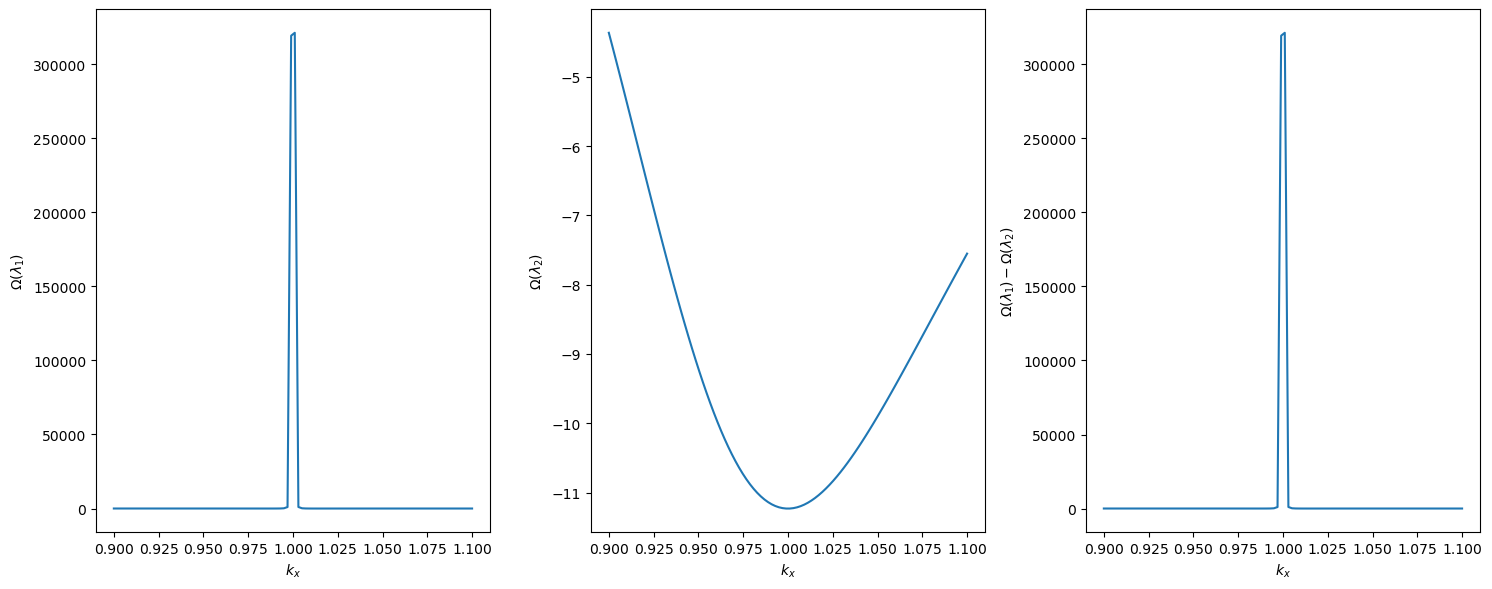

In [1092]:
lambda1 = 0.9519
lambda2 = 1.1
rs = 1
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
index = 2
spacing = 10^(-3)
ky = 0
plot_bc_v2(lambda1, lambda2, rs, kappa, V, shells, index, spacing, ky)

## Berry curvature contours

In [15]:
function plot_bc(lambda, rs, kappa, V, shells, index, spacing)
    n_pts = 10^2
    
    shift = 0.1
    kx_list = range(kappa - shift, kappa + shift, n_pts)
    ky_list = shift * range(-1, 1, n_pts)
    grid = mesh_grid(kx_list, ky_list, Float64)

    # k_list = range(-kappa, kappa, n_pts)
    # grid = mesh_grid(k_list, k_list, Float64)


    bc_list = grid_bc(grid, lambda, rs, kappa, V, shells, index, spacing)

    grid_new = reshape(grid, (n_pts, n_pts, 2))
    bc_list_new = reshape(bc_list, (n_pts, n_pts))

    bc_min = minimum(bc_list_new)
    bc_max = maximum(bc_list_new)
    bc_abs = maximum(abs.([bc_min, bc_max]))

    figure()
    xlabel(L"k_x")
    ylabel(L"k_y")
    title(L"\Omega(k_x, k_y) \text{ vs } (k_x, k_y)")
    pcolormesh(grid_new[:, :, 1], grid_new[:, :, 2], bc_list_new, cmap="RdBu", vmin = -bc_abs, vmax = bc_abs)
    colorbar()
    display(gcf())
end

plot_bc (generic function with 1 method)

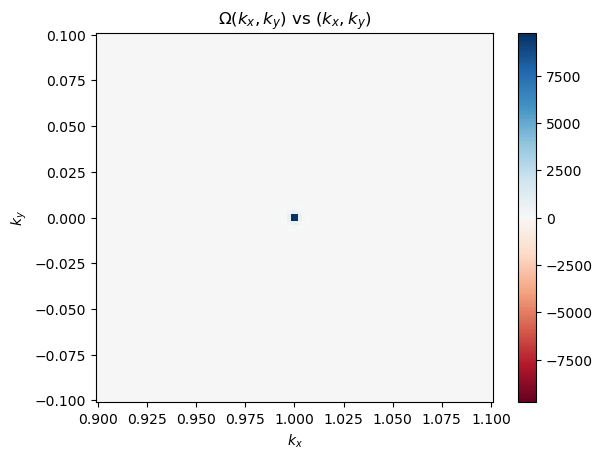

In [16]:
lambda = 0.9519
rs = 1
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
index = 2
spacing = 10^(-4)
plot_bc(lambda, rs, kappa, V, shells, index, spacing)

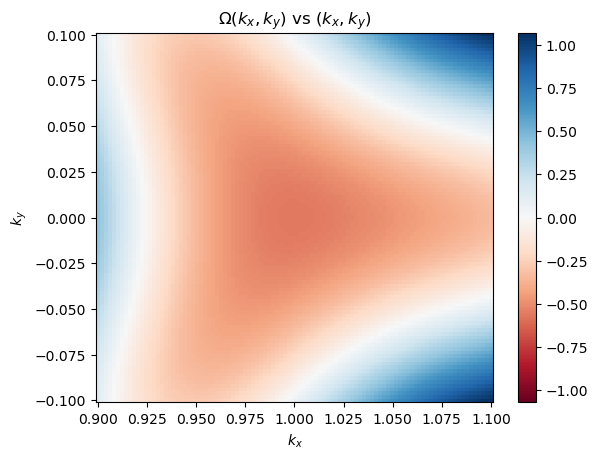

In [17]:
lambda = 1.2
rs = 1
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
index = 2
spacing = 10^(-4)
plot_bc(lambda, rs, kappa, V, shells, index, spacing)

In [407]:
function plot_bc_error(lambda, rs, kappa, V, shells, index, spacing)
    n_pts = 10
    
    shift = 0.5
    kx_list = range(kappa - shift, kappa + shift, n_pts)
    ky_list = shift * range(-1, 1, n_pts)
    grid = mesh_grid(kx_list, ky_list, Float64)

    patch_grid = mesh_grid(ky_list, ky_list, Float64)

    # k_list = range(-kappa, kappa, n_pts)
    # grid = mesh_grid(k_list, k_list, Float64)


    bc_list = grid_bc(grid, lambda, rs, kappa, V, shells, index, spacing)

    grid_new = reshape(grid, (n_pts, n_pts, 2))
    bc_list_new = reshape(bc_list, (n_pts, n_pts))

    delta = 1/2 * lambda_delta(kappa, lambda, V[1, 1], V[2, 2])
    alpha = 1/2 * lambda_alpha(kappa, lambda, V[1, 1], V[2, 2])
    vF = 2 * kappa/rs^2
    patch_bc = lambda_patch_bc(patch_grid, spacing, lambda, kappa, vF, delta, alpha, index)

    patch_bc_list_new = reshape(patch_bc, (n_pts, n_pts))

    errors = abs.(ones(length(patch_bc)) - abs.(patch_bc./bc_list))

    err_new = reshape(errors, (n_pts, n_pts))


    # bc_min = minimum(bc_list_new)
    # bc_max = maximum(bc_list_new)
    # bc_abs = maximum(abs.([bc_min, bc_max]))

    figure()
    xlabel(L"k_x")
    ylabel(L"k_y")
    title(L"\Omega(k_x, k_y) \text{ vs } (k_x, k_y)")
    pcolormesh(grid_new[:, :, 1], grid_new[:, :, 2], err_new, cmap="RdBu")
    colorbar()
    display(gcf())
end

plot_bc_error (generic function with 1 method)

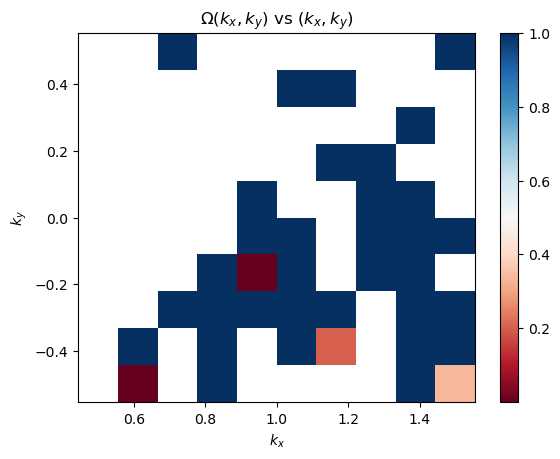

In [408]:
lambda = 1.5
rs = 10^(-3)
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
index = 1
spacing = 10^(-10)
plot_bc_error(lambda, rs, kappa, V, shells, index, spacing)

# First order coupling

In [5]:
function coupling(vF, kappa, lambda, V)
    omega = exp(im * 2 * pi/3)
    v1 = V[1, 1]
    v2 = V[2, 2]
    alpha = lambda_alpha(kappa, lambda, v1, v2)
    return (vF + 1/2 * omega * alpha + 1/2 * conj(omega) * conj(alpha))
end

coupling (generic function with 1 method)

In [6]:
function plot_coupling(vF_list, kappa, V)
    lambda_list = range(0.5, 2.5, 10^2)
    couplings = Array{Float64}(undef, length(vF_list), length(lambda_list))
    for i in 1:length(vF_list)
        vF = vF_list[i]
        for j in 1:length(lambda_list)
            lambda = lambda_list[j]
            couplings[i, j] = real(coupling(vF, kappa, lambda, V))
        end
    end
    fig, axs = plt.subplots(1,1,figsize=(15, 8))
    axs.set_xlabel(L"$\lambda$")
    axs.set_ylabel(L"$f(v_F, \lambda)$")
    axs.set_title(L"$f(v_F, \lambda) \text{ vs } \lambda$")
    for j in 1:length(vF_list)
        vF = round(vF_list[j], sigdigits=5)
        axs.plot(lambda_list, couplings[j, :], label = raw"$v_F = $" * "$vF")
    end
    axs.legend()
    
    fig
end

plot_coupling (generic function with 1 method)

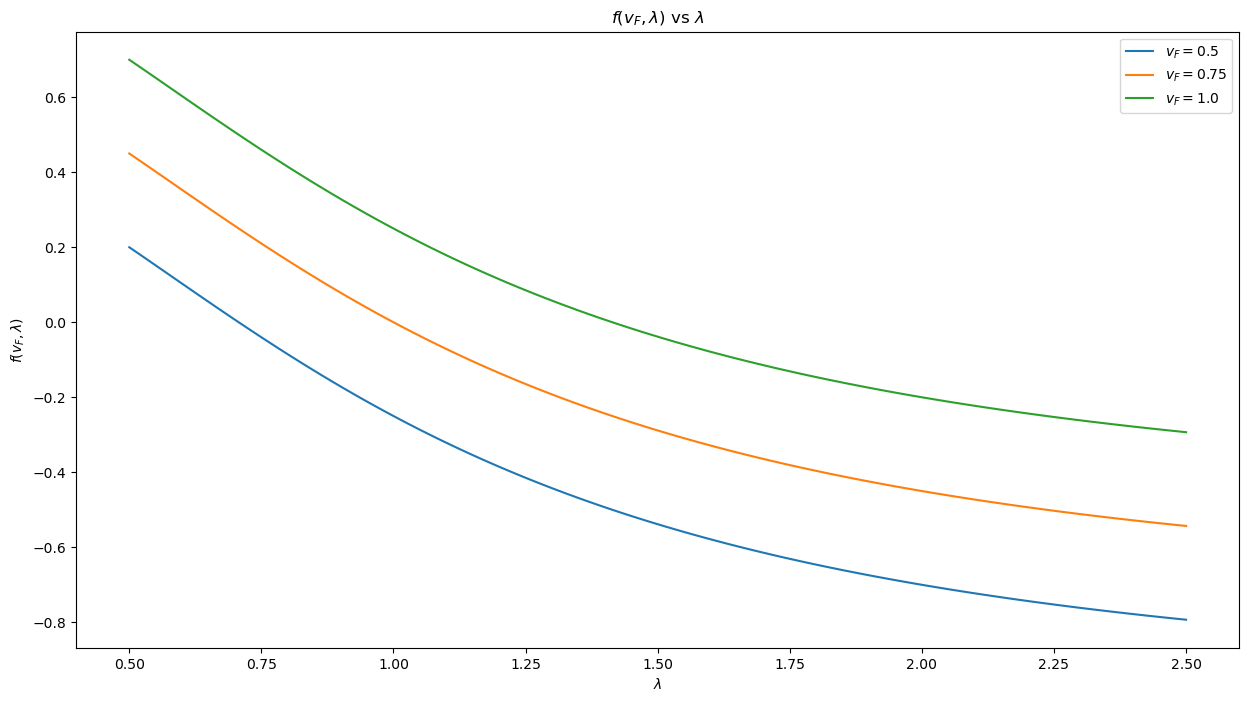

In [8]:
vF_list = [2/4, 3/4, 4/4]
kappa = 1
V = [[-1, 0] [0, -1]]
plot_coupling(vF_list, kappa, V)

In [9]:
# set the relevant parameters
lambda = 1
n = 12
vF = 3/2
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
bc_spacing = 10^(-4)
ky = 0
llm = 0.99
ulm = 1.01
mod_plot_energy_line(lambda, n, vF, kappa, V, shells, bc_spacing, ky, llm, ulm)

UndefVarError: UndefVarError: `mod_plot_energy_line` not defined

In [72]:
function plot_ev(alpha, vF, kappa, V, lambda, qy, deltVF)
    qx_list = range(-1, 1, 10^2)
    ev_list = Array{Float64}(undef, length(qx_list), 6)

    Delt = lambda_delta(kappa, lambda, V[1, 1], V[2, 2])
    delt = 0.002
    delta = Delt + delt

    # thing = (2/(3*abs(alpha)) * sqrt(3 * abs(Delt) * real(2 * delt - 2 * exp(-im*2*pi/3)*delt) + 
    # 9 * real(delt + exp(im*2*pi/3) * delt)^2 - real(delt - exp(im*2*pi/3) * delt)^2))
    for j in 1:length(qx_list)
        qx = qx_list[j]
        # delta = exp(-im * 2 * pi/3) - 0.002
        # alpha = 1/2 * lambda_alpha(kappa, lambda, V[1, 1], V[2, 2])
        
        # alpha = exp(im * pi/3) + 0.1
        # alpha = 1 * exp(im * pi/3)
        # vF = -2 * real(exp(im * 2 * pi/3) * alpha)
        ham = H_k_v2([qx, qy], vF + 2*deltVF) + H_mft_v2([qx, qy], delta, alpha)
        ev_list[j, 1] = eigvals(Hermitian(ham))[1]
        ev_list[j, 2] = eigvals(Hermitian(ham))[2]
        ev_list[j, 3] = eigvals(Hermitian(ham))[3]

        ev_list[j, 4] = abs(delta)/2 + deltVF/2 * qx - sqrt(qx^2 * (9*deltVF^2/4 + 9/2*abs2(alpha) + 6*abs(alpha)*deltVF) - 3/2 * abs(delta)*deltVF*qx + 9/4 * abs2(delta))
        ev_list[j, 5] = -abs(delta) - deltVF * qx
        ev_list[j, 6] = abs(delta)/2 + deltVF/2 * qx + sqrt(qx^2 * (9*deltVF^2/4 + 9/2*abs2(alpha) + 6*abs(alpha)*deltVF) - 3/2 * abs(delta)*deltVF*qx + 9/4 * abs2(delta))
    end
    fig, axs = plt.subplots(1,1,figsize=(5, 5))
    axs.set_xlabel(L"$q_x$", fontsize = 16)
    axs.set_ylabel("Energy", fontsize = 16)
    # axs.set_title(L"$\epsilon \text{ vs } q_x$", fontsize = 20)
    axs.plot(qx_list, ev_list[:, 1] , label = L"\epsilon_-")
    axs.plot(qx_list, ev_list[:, 2], label = L"\epsilon_0")

    #axs.plot(thing * ones(length(qx_list)), ev_list[:, 2] , label = L"s0")
    xticks = [0]
    xlabels = [L"0"]
    # axs.set_xticks(xticks, labels=xlabels)
    yticks = [-1]
    ylabels = [L"-|\Delta|"]
    # axs.set_yticks(yticks, labels=ylabels)
    # axs.set_ylim(-1.01, -0.99)
    #axs.plot(qx_list, ev_list[:, 3] , label = L"\epsilon_m")
    # axs.plot(qx_list, ev_list[:, 5], label = L"\epsilon_{00}")
    axs.plot(qx_list, ev_list[:, 3], label = L"\epsilon_+")
    # axs.plot(qx_list, ev_list[:, 6], label = L"\epsilon_p")
    # axs.legend()
    fig.tight_layout()

    fig
end

plot_ev (generic function with 1 method)

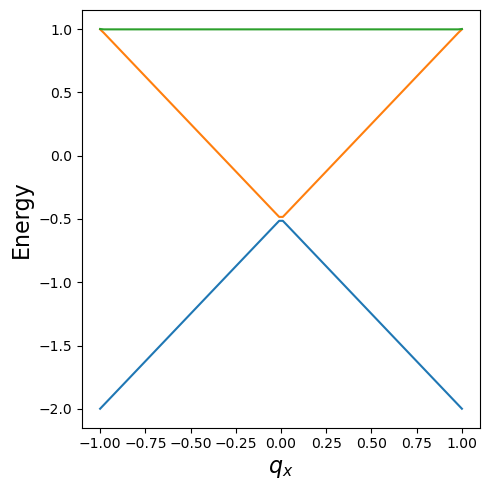

In [73]:
# deltVF = 0
kappa = 1
V = [[-1, 0] [0, -1]]
# lambda = 1
# # vF = -2 * real(exp(im * 2 * pi/3) * lambda_alpha(kappa, lambda, V[1, 1], V[2, 2]))
# vF = -0.975
# qy = 0
bc_spacing = 10^(-6)
lambda = 1
# rs = sqrt(2/10^(0))
alpha = exp(im*pi/3)
vF = -2 * real(exp(-im * 2 * pi/3) * alpha)
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
qy = 0
deltVF = 0

plot_ev(alpha, vF, kappa, V, lambda, qy, deltVF)

In [1]:
omega = exp(im*2*pi/3)
alpha = exp(-im*pi/3)
display(real(conj(omega) * alpha - omega * alpha))
display(real(alpha - omega * alpha))

-1.5

1.1102230246251565e-16

In [2]:
print(vF)

UndefVarError: UndefVarError: `vF` not defined

In [3]:
# deltVF = 0
# kappa = 1
# V = [[-1, 0] [0, -1]]
# lambda = 1
# # vF = -2 * real(exp(im * 2 * pi/3) * lambda_alpha(kappa, lambda, V[1, 1], V[2, 2]))
# vF = -0.975
# qy = 0
bc_spacing = 10^(-6)
lambda = 1.1
# rs = sqrt(2/10^(0))
vF = 1
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
qy = 0
deltVF = 0

plot_ev(vF, kappa, V, lambda, qy, deltVF)

UndefVarError: UndefVarError: `plot_ev` not defined

In [9]:
function plotter_ev(kappa, V, qy)
    qx_list = range(-1, 1, 10^2)
    ev_list = Array{Float64}(undef, length(qx_list), 6)
    delta = exp(-im * 2 * pi/3) 
    alpha = 1 * exp(im * pi/3) + 1.318 * exp(im*5*pi/6)
    vF = -2 * real(exp(im * 2 * pi/3) * exp(im * pi/3))
    for j in 1:length(qx_list)
        qx = qx_list[j]
        ham = H_k_v2([qx, qy], vF + 2*deltVF) + H_mft_v2([qx, qy], delta, alpha)
        ev_list[j, 1] = eigvals(Hermitian(ham))[1]
        ev_list[j, 2] = eigvals(Hermitian(ham))[2]
        ev_list[j, 3] = eigvals(Hermitian(ham))[3]

        ev_list[j, 4] = abs(delta)/2 + deltVF/2 * qx - sqrt(qx^2 * (9*deltVF^2/4 + 9/2*abs2(alpha) + 6*abs(alpha)*deltVF) - 3/2 * abs(delta)*deltVF*qx + 9/4 * abs2(delta))
        ev_list[j, 5] = -abs(delta) - deltVF * qx
        ev_list[j, 6] = abs(delta)/2 + deltVF/2 * qx + sqrt(qx^2 * (9*deltVF^2/4 + 9/2*abs2(alpha) + 6*abs(alpha)*deltVF) - 3/2 * abs(delta)*deltVF*qx + 9/4 * abs2(delta))
    end
    fig, axs = plt.subplots(1,1,figsize=(5, 5))
    axs.set_xlabel(L"$q_x$", fontsize = 16)
    axs.set_ylabel("Energy", fontsize = 16)
    axs.plot(qx_list, ev_list[:, 1] , label = L"\epsilon_-")
    axs.plot(qx_list, ev_list[:, 2], label = L"\epsilon_0")

    # g_close = 4 * (0.08/2) / (3 * abs2(alpha) + 4 * abs(alpha) * (0.08/2))

    xticks = [0]
    xlabels = [L"0"]
    axs.set_xticks(xticks, labels=xlabels)
    yticks = [-1]
    ylabels = [L"-|\Delta|"]
    axs.set_yticks(yticks, labels=ylabels)
    #axs.set_ylim(-1.01, -0.995)
    fig.tight_layout()

    fig
end

plotter_ev (generic function with 1 method)

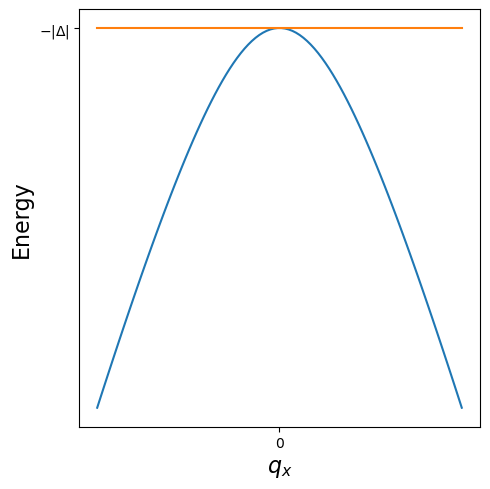

In [146]:
kappa = 1
V = [[-1, 0] [0, -1]]
qy = 0
plotter_ev(kappa, V, qy)

In [10]:
function plot_ev_lambdas(vF, kappa, V, lambda, lambda2, qy)
    qx_list = range(-0.1, 0.1, 10^2)
    ev_list = Array{Float64}(undef, length(qx_list), 3)
    for j in 1:length(qx_list)
        qx = qx_list[j]
        lambda = lambda1

        delta = lambda_delta(kappa, lambda, V[1, 1], V[2, 2])
        alpha = lambda_alpha(kappa, lambda, V[1, 1], V[2, 2])
        ham = H_k_v2([qx, qy], vF + deltaV) + H_mft_v2([qx, qy], delta, alpha)
        ev_list[j, 1] = eigvals(Hermitian(ham))[1]

        lambda = lambda2

        delta = lambda_delta(kappa, lambda, V[1, 1], V[2, 2])
        alpha = lambda_alpha(kappa, lambda, V[1, 1], V[2, 2])
        ham = H_k_v2([qx, qy], vF + deltaV) + H_mft_v2([qx, qy], delta, alpha)
        ev_list[j, 2] = eigvals(Hermitian(ham))[1]
    end
    fig, axs = plt.subplots(1,1,figsize=(15, 8))
    axs.set_xlabel(L"$q_x$")
    axs.set_ylabel(L"$\epsilon_0$")
    axs.set_title(L"$\epsilon_0 \text{ vs } q_x$")
    axs.plot(qx_list, ev_list[:, 1], label = L"\lambda_1")
    axs.plot(qx_list, ev_list[:, 2], label = L"\lambda_2")
    axs.legend()
    fig
end

plot_ev_lambdas (generic function with 1 method)

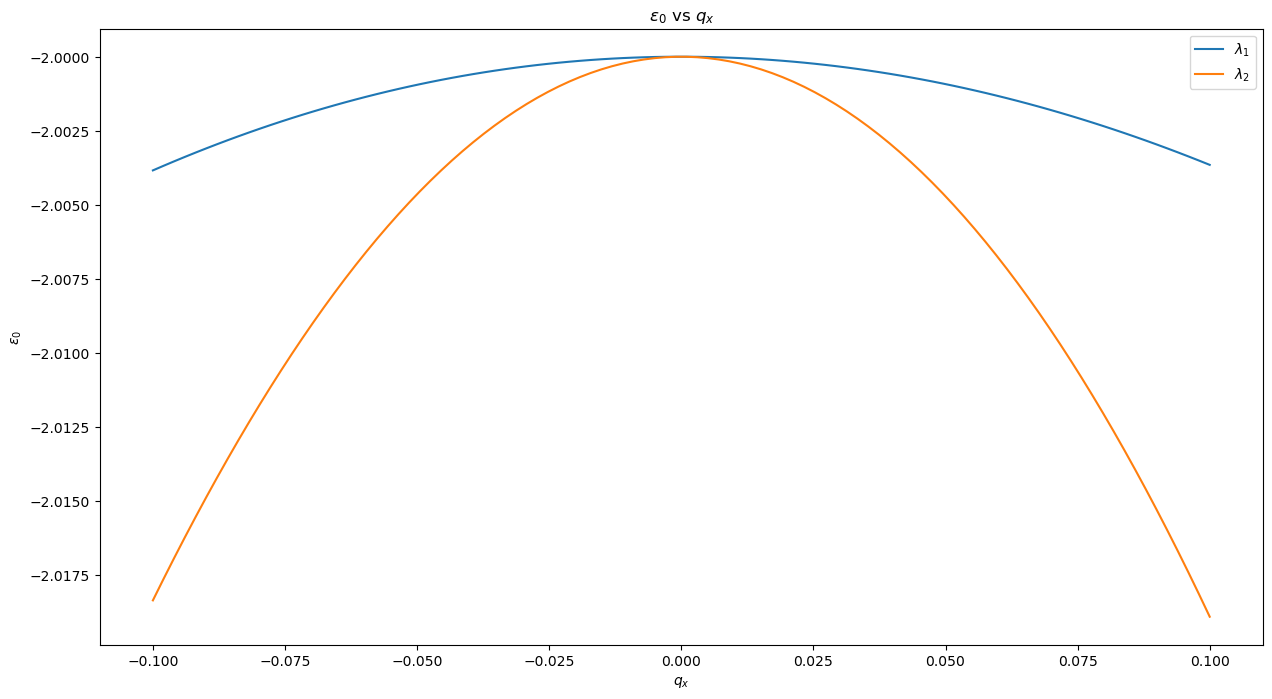

In [636]:
vF = 3/2
kappa = 1
V = [[-1, 0] [0, -1]]
lambda1 = 10^(-4)
lambda2 = 10^(4)
qy = 0
plot_ev_lambdas(vF, kappa, V, lambda1, lambda2, qy)

In [73]:
function plot_ff(kappa, V, lambda, qy)
    qx_list = range(-0.1, 0.1, 10^2)
    ff_list = Array{ComplexF64}(undef, length(qx_list), 2)
    omega = exp(im * 2 * pi/3)
    for j in 1:length(qx_list)
        qx = qx_list[j]
        q = qx + im * qy
        delta = lambda_delta(kappa, lambda, V[1, 1], V[2, 2])
        alpha = lambda_alpha(kappa, lambda, V[1, 1], V[2, 2])
        ff_list[j, 1] = lambda_ff(V, lambda, kappa * [1, 0] + [qx, qy], kappa * [cos(2*pi/3), sin(2*pi/3)] + [qx, qy])
        
        ff_list[j, 2] = delta + alpha/2 * (omega * q + conj(omega * q))
    end
    fig, axs = plt.subplots(1,1,figsize=(15, 8))
    axs.set_xlabel(L"$q_x$")
    axs.set_ylabel(L"$\Lambda$")
    axs.set_title(L"$\Lambda \text{ vs } q_x$")
    axs.plot(qx_list, real.(ff_list[:, 1]), label = L"\text{true}")
    axs.plot(qx_list, real.(ff_list[:, 2]), label = L"\text{linearized}")
    axs.legend()
    fig
end

plot_ff (generic function with 3 methods)

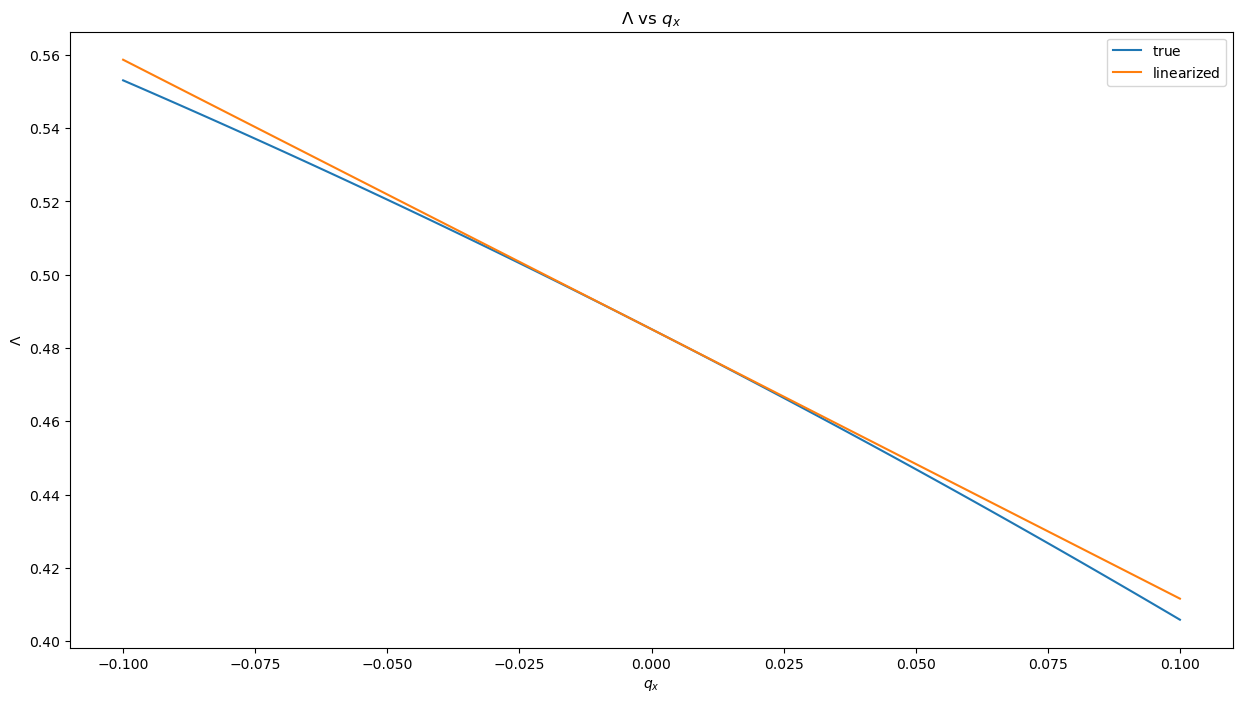

In [79]:
kappa = 1
V = [[-1, 0] [0, -1]]
lambda = 10
qy = 0
plot_ff(kappa, V, lambda, qy)